In [ ]:
# SOC model LUtype enhance - remove category2 1130
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import joblib
import os
import re
from pathlib import Path
import warnings
import builtins
from scipy import stats
open = builtins.open

warnings.filterwarnings('ignore')

# SHAP availability check
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """强化正则化的目标函数"""
        params = {
            'eta': trial.suggest_float('eta', 0.005, 0.1, log=True),  # 更低的学习率
            'max_depth': trial.suggest_int('max_depth', 2, 4),  # 更浅的树
            'subsample': trial.suggest_float('subsample', 0.4, 0.7),  # 更低的子采样
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.7),  # 更低的特征采样
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 0.7),
            'min_child_weight': trial.suggest_int('min_child_weight', 10, 20),  # 更高的最小子节点权重
            'lambda': trial.suggest_float('lambda', 10, 25.0),  # 更强的L2正则化
            'alpha': trial.suggest_float('alpha', 5.0, 15.0),  # 更强的L1正则化
            'gamma': trial.suggest_float('gamma', 0.5, 2.0),  # 更高的剪枝参数
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 1),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=800,  # 更多的轮次但更保守的早停
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=25,  # 更保守的早停
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        # 更强的过拟合惩罚
        train_rmse = cv_results['train-rmse-mean'].iloc[-1]
        val_rmse = cv_results['test-rmse-mean'].iloc[-1]
        
        # 计算过拟合程度
        overfitting_ratio = (train_rmse - val_rmse) / train_rmse
        gap_penalty = max(0, overfitting_ratio) * 0.3  # 更强的惩罚
        
        # 如果过拟合严重，增加额外惩罚
        if overfitting_ratio > 0.1:
            gap_penalty += (overfitting_ratio - 0.1) * 0.5
            
        return val_rmse + gap_penalty
    
    def tune_hyperparameters(self, dtrain, n_trials=20):  # 增加试验次数
        """专注于泛化的超参数调优"""
        study = optuna.create_study(direction='minimize')
        
        print("Tuning hyperparameters with aggressive overfitting prevention...")
        print("Using very strong regularization and shallow trees")

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials//5)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        print(f"Best parameters found: {self.best_params}")
        return self.best_params


    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """训练模型，专注于防止过拟合"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=25,  # 更保守的早停
            verbose_eval=100,  # 减少输出频率
            evals_result=evals_result
        )

        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, n_repeats=10,cv_models_dir='cv_models'): 
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=30):
        """Plot feature importance without category-specific highlighting"""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # 获取特征重要性
        importance_dict = model.get_score(importance_type=importance_type)
        
        if not importance_dict:
            print("No feature importance data available.")
            return None
            
        # 转换为DataFrame以便排序
        importance_df = pd.DataFrame({
            'feature': list(importance_dict.keys()),
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=True)
        
        # 只显示top_n特征
        if len(importance_df) > top_n:
            importance_df = importance_df.tail(top_n)
        
        # 绘制水平条形图
        y_pos = np.arange(len(importance_df))
        colors = ['lightblue'] * len(importance_df)
        
        ax.barh(y_pos, importance_df['importance'], color=colors, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance')
        
        title = f'Feature Importance ({importance_type})'
        ax.set_title(title)
        
        # 添加LUtype重要性说明
        lu_type_features = importance_df[importance_df['feature'].str.contains('LUtype', na=False)]
        lu_type_importance = lu_type_features['importance'].sum() if not lu_type_features.empty else 0
        
        ax.text(0.7, 0.95, f'LUtype total: {lu_type_importance:.3f}', 
                transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        plt.tight_layout()
        plt.show()
        
        return importance_df

    def analyze_lutype_importance(self, model, X):
        """分析LUtype相关特征的重要性，不关注特定类别"""
        importance_dict = model.get_score(importance_type='weight')
        
        if not importance_dict:
            print("No feature importance data available.")
            return
            
        # 分类统计不同特征
        lutype_features = {k: v for k, v in importance_dict.items() if 'LUtype' in k}
        other_features = {k: v for k, v in importance_dict.items() if 'LUtype' not in k}
        
        print(f"\n=== LUtype Feature Importance Analysis ===")
        print(f"Total LUtype-related features: {len(lutype_features)}")
        print(f"Total importance of LUtype features: {sum(lutype_features.values()):.3f}")
        print(f"Average importance of LUtype features: {np.mean(list(lutype_features.values())) if lutype_features else 0:.3f}")
        
        total_importance = sum(importance_dict.values())
        lu_type_percentage = (sum(lutype_features.values()) / total_importance * 100) if total_importance > 0 else 0
        
        print(f"\nLUtype importance percentage: {lu_type_percentage:.2f}%")
        
        # 打印最重要的LUtype特征
        if lutype_features:
            sorted_lutype = sorted(lutype_features.items(), key=lambda x: x[1], reverse=True)
            print(f"\nTop LUtype-related features:")
            for feature, importance in sorted_lutype[:10]:
                print(f"  {feature}: {importance:.4f}")
        else:
            print("\nNo LUtype-related features found in importance scores.")

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

def detect_outliers_iqr(df, columns, threshold=1.5):
    """使用IQR方法检测异常值"""
    outlier_indices = []
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            outlier_indices.extend(outliers)
            
            if len(outliers) > 0:
                print(f"  {col}: 发现 {len(outliers)} 个异常值 "
                      f"({len(outliers)/len(df)*100:.2f}%)")
    
    return list(set(outlier_indices))

def remove_outliers_robust(df, y, columns, method='iqr', threshold=2.0):
    """鲁棒的异常值处理方法"""
    print("开始异常值检测...")
    
    if method == 'iqr':
        outlier_indices = detect_outliers_iqr(df, columns, threshold)
    elif method == 'zscore':
        # Z-score方法
        z_scores = np.abs(stats.zscore(df[columns]))
        outlier_indices = np.where(z_scores > threshold)[0]
        outlier_indices = list(outlier_indices)
    else:
        return df, y, []
    
    print(f"\n总共发现 {len(outlier_indices)} 个异常值样本")
    
    if len(outlier_indices) > 0:
        df_clean = df.drop(outlier_indices)
        y_clean = y.drop(outlier_indices)
        print(f"清除异常值后数据大小: {len(df_clean)} (移除了 {len(outlier_indices)} 个样本)")
        return df_clean, y_clean, outlier_indices
    
    print("未发现异常值")
    return df, y, []

def check_data_leakage(X_train, X_test, y_train, y_test):
    """检查数据泄露"""
    print("\n=== 数据泄露检查 ===")
    
    # 检查训练集和测试集是否有重叠
    train_indices = set(X_train.index)
    test_indices = set(X_test.index)
    overlap = train_indices.intersection(test_indices)
    
    if overlap:
        print(f"❌ 发现数据泄露: 训练集和测试集有 {len(overlap)} 个重叠样本")
    else:
        print("✅ 训练集和测试集没有重叠")
    
    # 检查特征分布
    print(f"训练集大小: {len(X_train)}")
    print(f"测试集大小: {len(X_test)}")
    print(f"特征数量: {X_train.shape[1]}")
    
    return len(overlap) == 0

def safe_feature_engineering(X_train, X_test):
    """安全的特征工程，避免数据泄露"""
    print("进行安全的特征工程...")
    
    # 1. 对数变换
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in X_train.columns:
            X_train[col + '_log'] = np.log(X_train[col] + 1e-8)
            X_test[col + '_log'] = np.log(X_test[col] + 1e-8)
            print(f"  创建对数特征: {col}_log")
    
    # 2. 分箱（基于训练集的分位数）
    if 'Altitude' in X_train.columns:
        # 使用训练集计算分箱边界
        alt_bins = pd.cut(X_train['Altitude'], bins=5, retbins=True)[1]
        X_train['Altitude_bins'] = pd.cut(X_train['Altitude'], bins=alt_bins, labels=False)
        X_test['Altitude_bins'] = pd.cut(X_test['Altitude'], bins=alt_bins, labels=False)
        print("  创建分箱特征: Altitude_bins")
    
    return X_train, X_test

def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    """Augment continuous features with noise - 只对训练集使用"""
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented

def enhanced_load_and_prepare_data(augment=True, augmentation_factor=2, 
                                 lu_type_importance_boost=3.0, 
                                 outlier_threshold=2.0):
    """修复数据泄露并添加异常值处理的版本"""
    
    # 加载数据
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    # 选择目标土层
    target_layer = "topsoil" ###################################################################################SELECT LAYER
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    # 选择特征
    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    # 数据清洗
    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    X = df[valid_x_cols].astype('float32').fillna(0)
    y = df['yi'].astype('float32')

    print(f"原始数据大小: {len(X)}")
    
    # 异常值检测和处理
    continuous_cols = ['Lon', 'Lat', 'Age', 'BD', 'pH', 'Altitude']
    continuous_cols = [col for col in continuous_cols if col in X.columns]
    
    print("\n=== 异常值处理 ===")
    X_clean, y_clean, outliers = remove_outliers_robust(
        X, y, continuous_cols, threshold=outlier_threshold
    )

    # 数据分割
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.3, random_state=42
    )

    # 安全的特征工程
    X_train, X_test = safe_feature_engineering(X_train, X_test)

    # 数据泄露检查
    check_data_leakage(X_train, X_test, y_train, y_test)

    # LUtype特征增强（只对训练集）
    if 'LUtype' in X_train.columns:
        print(f"\n=== LUtype 特征增强 ===")
        print(f"原始 LUtype 分布:")
        print(X_train['LUtype'].value_counts().sort_index())
        
        print(f"\n增强 LUtype 重要性，因子: {lu_type_importance_boost}")
        
        # 创建LUtype特征增强
        for i in range(int(lu_type_importance_boost) - 1):
            lu_type_col_name = f'LUtype_boost_{i+1}'
            X_train[lu_type_col_name] = X_train['LUtype']
            X_test[lu_type_col_name] = X_test['LUtype']
            print(f"  创建 LUtype 副本: {lu_type_col_name}")
        
        # 创建LUtype与其他重要特征的交互项
        important_features = ['pH', 'BD', 'Age', 'Altitude']
        for feature in important_features:
            if feature in X_train.columns:
                interaction_name = f'LUtype_{feature}_interaction'
                X_train[interaction_name] = X_train['LUtype'] * X_train[feature]
                X_test[interaction_name] = X_test['LUtype'] * X_test[feature]
                print(f"  创建交互特征: {interaction_name}")
        
        # 创建LUtype的平方项（非线性效应）
        X_train['LUtype_squared'] = X_train['LUtype'] ** 2
        X_test['LUtype_squared'] = X_test['LUtype'] ** 2
        print("  创建 LUtype_squared")
    
    # 数据增强（只对训练集）
    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]
        continuous_cols = [col for col in continuous_cols if col in X_train.columns]
        
        print(f"\n=== 数据增强 ===")
        print(f"训练集增强前大小: {len(X_train)}")
        X_train, y_train = augment_continuous_features(
            X=X_train,  # 只对训练集增强
            y=y_train,  # 只对训练集增强
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
        print(f"训练集增强后大小: {len(X_train)}")
    else:
        print("\n跳过数据增强")

    print(f"\n=== 最终数据集统计 ===")
    print(f"训练集大小: {len(X_train)}")
    print(f"测试集大小: {len(X_test)}")
    print(f"总特征数量: {len(X_train.columns)}")
    
    # 统计特征分布
    lu_type_cols = [col for col in X_train.columns if 'LUtype' in col]
    
    print(f"\n特征统计:")
    print(f"LUtype 相关特征: {len(lu_type_cols)}")

    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, X, y, X_test, y_test, X_train, y_train

def main():
    """Main function with data leakage prevention"""
    outlier_threshold = 2.0  # 异常值检测阈值
    
    print("=== 开始增强的XGBoost建模（修复数据泄露版本）===")
    
    # 使用修复的数据处理（包含异常值处理和数据泄露预防）
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = enhanced_load_and_prepare_data(
        augment=True,
        augmentation_factor=3,
        lu_type_importance_boost=3.0,
        outlier_threshold=outlier_threshold
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("\n=== 开始超参数调优 ===")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)
    print(f"最佳参数: {best_params}")

    # 2. Cross-validation with model saving
    print("\n=== 开始交叉验证 ===")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,n_repeats=10,
                                      cv_models_dir='F:/model/results/cv_models')
    
    print("\n保存的CV模型:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    
    # Plot CV results
    print("\n绘制交叉验证结果...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== 交叉验证结果 ===")
    print(f"平均训练RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"平均验证RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"平均训练R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"平均验证R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\n使用 {optimal_rounds} 轮训练最终模型...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    # Plot learning curves
    print("\n绘制学习曲线...")
    tuner.plot_learning_curves(evals_result, "最终模型")

    # 4. Evaluate and plot final performance
    print("\n评估最终模型...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== 最终测试指标 ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\n绘制最终模型性能...")
    tuner.plot_final_model_performance(final_model, dtest)

    # 5. 分析LUtype重要性
    print(f"\n分析 LUtype 特征重要性...")
    importance_df = tuner.plot_feature_importance(final_model, top_n=35)
    
    # 详细分析LUtype重要性
    tuner.analyze_lutype_importance(final_model, X_test)
    
    # 6. SHAP分析
    if SHAP_AVAILABLE:
        print("\n生成SHAP摘要图...")
        tuner.plot_shap_summary(final_model, X_test)
        # 7. 保存结果
    print("\n保存结果...")
    tuner.save_results(final_model, 'F:/model/results')
    
    print(f"\n=== 模型训练总结 ===")
    print("✓ 修复了数据泄露问题")
    print("✓ 添加了异常值检测和处理")
    print("✓ 安全的特征工程（避免数据泄露）")
    print("✓ 创建了多个LUtype特征副本")
    print("✓ 添加了LUtype与其他重要变量的交互特征")
    print("✓ 添加了LUtype平方项（非线性效应）")
    print("✓ 改进了超参数搜索空间以更好地处理分类特征")
    print("✓ 测试集使用原始数据（无增强噪声）")
    
    print("\n=== 完成! ===")

if __name__ == "__main__":
    main()

In [ ]:
# Final Version subsoil_sub - Fixed Data Leakage Version 10_fold
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import joblib
import os
import re
from pathlib import Path
import warnings
import builtins
from scipy import stats
open = builtins.open

warnings.filterwarnings('ignore')

# SHAP availability check
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with LUtype preference"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 3),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, n_repeats=10, cv_models_dir='cv_models'):
        """10x5-fold CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': [],
            'repeat': [],
            'fold': []
        }

        def process_fold(repeat_idx, fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_repeat_{repeat_idx}_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names,
                repeat_idx,
                fold_idx
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for repeat_idx in range(n_repeats):
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed + repeat_idx)
                for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                    futures.append(executor.submit(
                        process_fold, repeat_idx, fold_idx, train_idx, val_idx
                    ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names, repeat_idx, fold_idx = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)
                cv_results['repeat'].append(repeat_idx)
                cv_results['fold'].append(fold_idx)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.rcParams.update({'font.size': plt.rcParams['font.size'] * 1.2})
        
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('cv_results.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        plt.rcParams.update({'font.size': plt.rcParams['font.size'] / 1.2})

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        plt.rcParams.update({'font.size': plt.rcParams['font.size'] * 1.2})
        
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        plt.rcParams.update({'font.size': plt.rcParams['font.size'] / 1.2})

    def plot_feature_importance(self, model, importance_type='weight', top_n=30, 
                               highlight_features=None, highlight_category_2=False):
        """Plot feature importance with highlighted features"""
        plt.rcParams.update({'font.size': plt.rcParams['font.size'] * 1.2})
        
        fig, ax = plt.subplots(figsize=(12, 10))
        
        importance_dict = model.get_score(importance_type=importance_type)
        
        if not importance_dict:
            print("No feature importance data available.")
            return None
            
        importance_df = pd.DataFrame({
            'feature': list(importance_dict.keys()),
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=True)
        
        if len(importance_df) > top_n:
            importance_df = importance_df.tail(top_n)
        
        y_pos = np.arange(len(importance_df))
        colors = ['lightblue'] * len(importance_df)
        
        if highlight_features:
            for i, feature in enumerate(importance_df['feature']):
                if any(hl_feature in feature for hl_feature in highlight_features):
                    if highlight_category_2 and 'category_2' in feature:
                        colors[i] = 'darkred'
                    else:
                        colors[i] = 'red'
        
        ax.barh(y_pos, importance_df['importance'], color=colors, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance')
        
        title = f'Feature Importance ({importance_type})'
        if highlight_category_2:
            title += ' - Category 2 Special Highlight'
        ax.set_title(title)
        
        lu_type_features = importance_df[importance_df['feature'].str.contains('LUtype', na=False)]
        lu_type_importance = lu_type_features['importance'].sum() if not lu_type_features.empty else 0
        
        category_2_features = importance_df[importance_df['feature'].str.contains('category_2', na=False)]
        category_2_importance = category_2_features['importance'].sum() if not category_2_features.empty else 0
        
        ax.text(0.7, 0.95, f'LUtype total: {lu_type_importance:.3f}', 
                transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        if highlight_category_2:
            ax.text(0.7, 0.88, f'Category 2 total: {category_2_importance:.3f}', 
                    transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="orange"))
        
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        plt.rcParams.update({'font.size': plt.rcParams['font.size'] / 1.2})
        
        return importance_df

    def analyze_lutype_importance(self, model, X, focus_category=2):
        """Special analysis of LUtype feature importance, focusing on specific category"""
        importance_dict = model.get_score(importance_type='weight')
        
        if not importance_dict:
            print("No feature importance data available.")
            return
            
        lutype_features = {k: v for k, v in importance_dict.items() if 'LUtype' in k}
        category_2_features = {k: v for k, v in importance_dict.items() if f'category_{focus_category}' in k}
        
        print(f"\n=== LUtype Feature Importance Analysis (Focus on Category {focus_category}) ===")
        print(f"Total LUtype-related features: {len(lutype_features)}")
        print(f"Total importance of LUtype features: {sum(lutype_features.values()):.3f}")
        
        print(f"\nCategory {focus_category} specific features: {len(category_2_features)}")
        print(f"Total importance of Category {focus_category} features: {sum(category_2_features.values()):.3f}")
        
        total_importance = sum(importance_dict.values())
        lu_type_percentage = (sum(lutype_features.values()) / total_importance * 100) if total_importance > 0 else 0
        category_2_percentage = (sum(category_2_features.values()) / total_importance * 100) if total_importance > 0 else 0
        
        print(f"\nLUtype importance percentage: {lu_type_percentage:.2f}%")
        print(f"Category {focus_category} importance percentage: {category_2_percentage:.2f}%")
        
        if lutype_features:
            sorted_lutype = sorted(lutype_features.items(), key=lambda x: x[1], reverse=True)
            print(f"\nTop LUtype-related features:")
            for feature, importance in sorted_lutype[:10]:
                print(f"  {feature}: {importance:.4f}")
        else:
            print("\nNo LUtype-related features found in importance scores.")
            
        if category_2_features:
            sorted_category_2 = sorted(category_2_features.items(), key=lambda x: x[1], reverse=True)
            print(f"\nTop Category {focus_category} features:")
            for feature, importance in sorted_category_2:
                print(f"  {feature}: {importance:.4f}")

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            plt.rcParams.update({'font.size': plt.rcParams['font.size'] * 1.2})
            
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            plt.rcParams.update({'font.size': plt.rcParams['font.size'] / 1.2})
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        model.save_model(f'{output_dir}/xgb_model.json')

        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

def detect_outliers_iqr(df, columns, threshold=1.5):
    """Detect outliers using IQR method"""
    outlier_indices = []
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            outlier_indices.extend(outliers)
            
            if len(outliers) > 0:
                print(f"  {col}: Found {len(outliers)} outliers "
                      f"({len(outliers)/len(df)*100:.2f}%)")
    
    return list(set(outlier_indices))

def remove_outliers_robust(df, y, columns, method='iqr', threshold=2.0):
    """Robust outlier processing method"""
    print("Starting outlier detection...")
    
    if method == 'iqr':
        outlier_indices = detect_outliers_iqr(df, columns, threshold)
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(df[columns]))
        outlier_indices = np.where(z_scores > threshold)[0]
        outlier_indices = list(outlier_indices)
    else:
        return df, y, []
    
    print(f"\nTotal found {len(outlier_indices)} outlier samples")
    
    if len(outlier_indices) > 0:
        df_clean = df.drop(outlier_indices)
        y_clean = y.drop(outlier_indices)
        print(f"Data size after removing outliers: {len(df_clean)} (removed {len(outlier_indices)} samples)")
        return df_clean, y_clean, outlier_indices
    
    print("No outliers found")
    return df, y, []

def check_data_leakage(X_train, X_test, y_train, y_test):
    """Check for data leakage"""
    print("\n=== Data Leakage Check ===")
    
    train_indices = set(X_train.index)
    test_indices = set(X_test.index)
    overlap = train_indices.intersection(test_indices)
    
    if overlap:
        print(f"❌ Data leakage detected: Training and test sets have {len(overlap)} overlapping samples")
    else:
        print("✅ No overlap between training and test sets")
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Feature count: {X_train.shape[1]}")
    
    return len(overlap) == 0

def safe_feature_engineering(X_train, X_test):
    """Safe feature engineering to avoid data leakage - FIXED VERSION"""
    print("Performing safe feature engineering...")
    
    # Store original column names to avoid modifying during iteration
    original_columns = X_train.columns.tolist()
    
    # 1. Log transformation - use training set min for both train and test
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in original_columns:
            # Use only training data to compute min value
            train_min = X_train[col].min()
            # Apply same transformation to both sets
            X_train[col + '_log'] = np.log(X_train[col] - train_min + 1e-8)
            X_test[col + '_log'] = np.log(X_test[col] - train_min + 1e-8)
            print(f"  Created log feature: {col}_log (using train min: {train_min:.4f})")
    
    # 2. Binning - use training set quantiles for both
    if 'Altitude' in original_columns:
        # Use training set to calculate bin boundaries
        alt_bins = pd.cut(X_train['Altitude'], bins=5, retbins=True)[1]
        # Apply same bins to both sets
        X_train['Altitude_bins'] = pd.cut(X_train['Altitude'], bins=alt_bins, labels=False)
        X_test['Altitude_bins'] = pd.cut(X_test['Altitude'], bins=alt_bins, labels=False)
        print("  Created binning feature: Altitude_bins")
    
    return X_train, X_test

def create_category_specific_features(X, target_category=2, importance_multiplier=5.0):
    """Create enhanced features for specific category - ensure no data leakage"""
    if 'LUtype' not in X.columns:
        return X
        
    print(f"  Creating enhanced features for LUtype category {target_category}...")
    
    X_copy = X.copy()
    
    # Create category indicator variable
    X_copy[f'category_{target_category}_indicator'] = (X_copy['LUtype'] == target_category).astype(int)
    
    # Create enhanced features for category 2 (multiple copies)
    for i in range(int(importance_multiplier)):
        feature_name = f'category_{target_category}_boost_{i+1}'
        X_copy[feature_name] = (X_copy['LUtype'] == target_category).astype(int) * (i + 1)
    
    # Create interaction terms between category 2 and other important features
    important_features = ['pH', 'BD','Silt',"Clay"]
    for feature in important_features:
        if feature in X_copy.columns:
            interaction_name = f'category_{target_category}_{feature}_interaction'
            X_copy[interaction_name] = (X_copy['LUtype'] == target_category).astype(int) * X_copy[feature]
    
    # Create weight features for category 2 (only use current dataset statistics)
    category_2_count = (X_copy['LUtype'] == target_category).sum()
    total_count = len(X_copy)
    category_2_ratio = category_2_count / total_count if total_count > 0 else 0
    
    X_copy[f'category_{target_category}_weight'] = (X_copy['LUtype'] == target_category).astype(int) * (1 / max(category_2_ratio, 0.1))
    
    return X_copy

def enhanced_load_and_prepare_data_fixed(augment=True, augmentation_factor=2, 
                                       lu_type_importance_boost=3.0, 
                                       focus_category=2, 
                                       category_importance_multiplier=5.0,
                                       outlier_threshold=2.0):
    """FIXED VERSION: Proper data preprocessing without leakage"""
    
    # Load data
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    # Select target soil layer
    target_layer = "subsoil"
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'subsoil' else 2)].copy()

    # Select features
    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    # Data cleaning
    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    X = df[valid_x_cols].astype('float32').fillna(0)
    y = df['yi'].astype('float32')

    print(f"Original data size: {len(X)}")
    
    # CRITICAL FIX: First split data, then process separately
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=X['LUtype'] if 'LUtype' in X.columns else None
    )
    
    print(f"After split - Training: {len(X_temp)}, Test: {len(X_test)}")
    
    # CRITICAL FIX: Process training and test sets separately using only training info
    # 1. Safe feature engineering first (uses only training set statistics)
    X_train_processed, X_test_processed = safe_feature_engineering(X_temp, X_test)
    
    # 2. Outlier detection ONLY on training set
    continuous_cols = ['Lon', 'Lat', 'Age', 'BD', 'pH', 'Altitude']
    continuous_cols = [col for col in continuous_cols if col in X_train_processed.columns]
    
    print("\n=== Outlier Processing (Training Set Only) ===")
    X_train_clean, y_train_clean, outliers = remove_outliers_robust(
        X_train_processed, y_temp, continuous_cols, threshold=outlier_threshold
    )

    print(f"Training set size after outlier removal: {len(X_train_clean)} (removed {len(outliers)} samples)")

    # 3. LUtype feature enhancement (applied separately but consistently)
    if 'LUtype' in X_train_clean.columns:
        print(f"\n=== LUtype Feature Enhancement ===")
        print(f"Training set original LUtype distribution:")
        print(X_train_clean['LUtype'].value_counts().sort_index())
        
        # Apply same feature engineering to both sets
        X_train_final = create_category_specific_features(X_train_clean, focus_category, category_importance_multiplier)
        X_test_final = create_category_specific_features(X_test_processed, focus_category, category_importance_multiplier)
        
        # Add LUtype copies and interactions
        for i in range(int(lu_type_importance_boost) - 1):
            lu_type_col_name = f'LUtype_boost_{i+1}'
            X_train_final[lu_type_col_name] = X_train_final['LUtype']
            X_test_final[lu_type_col_name] = X_test_final['LUtype']
        
        # Add interactions
        important_features = ['pH', 'BD','Silt',"Clay"]
        for feature in important_features:
            if feature in X_train_final.columns:
                interaction_name = f'LUtype_{feature}_interaction'
                X_train_final[interaction_name] = X_train_final['LUtype'] * X_train_final[feature]
                X_test_final[interaction_name] = X_test_final['LUtype'] * X_test_final[feature]
        
        # Add squared term
        X_train_final['LUtype_squared'] = X_train_final['LUtype'] ** 2
        X_test_final['LUtype_squared'] = X_test_final['LUtype'] ** 2
    else:
        X_train_final, X_test_final = X_train_clean, X_test_processed

    # 4. Data augmentation (only for training set)
    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]
        continuous_cols = [col for col in continuous_cols if col in X_train_final.columns]
        
        print(f"\n=== Data Augmentation (Training Set Only) ===")
        print(f"Training set size before augmentation: {len(X_train_final)}")
        
        # Simple augmentation without complex transformations
        np.random.seed(42)
        n_samples = len(X_train_final)
        n_augment = max(1, int(n_samples * augmentation_factor))
        
        X_train_augmented = X_train_final.copy()
        y_train_augmented = y_train_clean.copy()

        for i in range(n_augment):
            idx = np.random.randint(0, n_samples)
            base_sample = X_train_final.iloc[idx].copy()

            for col in continuous_cols:
                if col in X_train_final.columns:
                    std = X_train_final[col].std()
                    noise = np.random.normal(loc=0, scale=std * 0.01)
                    if X_train_final[col].min() >= 0:
                        base_sample[col] = max(0, base_sample[col] + noise)
                    else:
                        base_sample[col] += noise

            X_train_augmented = pd.concat([X_train_augmented, base_sample.to_frame().T], ignore_index=True)
            y_train_augmented = pd.concat([y_train_augmented, pd.Series([y_train_clean.iloc[idx]])], ignore_index=True)

        print(f"Training set size after augmentation: {len(X_train_augmented)}")
    else:
        X_train_augmented, y_train_augmented = X_train_final, y_train_clean
        print("\nSkipping data augmentation")

    # Final data validation
    print(f"\n=== Final Dataset Statistics ===")
    print(f"Training set size: {len(X_train_augmented)}")
    print(f"Test set size: {len(X_test_final)}")
    print(f"Total feature count: {len(X_train_augmented.columns)}")
    
    # Check for data leakage
    check_data_leakage(X_train_augmented, X_test_final, y_train_augmented, y_test)

    # Create DMatrix
    dtrain = xgb.DMatrix(X_train_augmented, label=y_train_augmented, feature_names=X_train_augmented.columns.tolist())
    dtest = xgb.DMatrix(X_test_final, label=y_test, feature_names=X_train_augmented.columns.tolist())

    return dtrain, dtest, X, y, X_test_final, y_test, X_train_augmented, y_train_augmented

def main():
    """Main function with proper data leakage prevention"""
    focus_category = 2
    category_importance_multiplier = 4.0
    outlier_threshold = 2.0
    
    print("=== Starting Enhanced XGBoost Modeling (Proper Data Leakage Prevention) ===")
    
    # Use fixed data processing
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = enhanced_load_and_prepare_data_fixed(
        augment=True,
        augmentation_factor=2,  # Reduced augmentation
        lu_type_importance_boost=2.0,  # Reduced feature engineering
        focus_category=focus_category,
        category_importance_multiplier=category_importance_multiplier,
        outlier_threshold=outlier_threshold
    )

    # Data distribution check
    print("\n=== Data Distribution Check ===")
    print("Training set statistics:")
    print(f"  Size: {len(X_train)}")
    print(f"  Target mean: {y_train.mean():.3f}, std: {y_train.std():.3f}")
    if 'LUtype' in X_train.columns:
        print(f"  LUtype distribution:\n{X_train['LUtype'].value_counts().sort_index()}")

    print("\nTest set statistics:")
    print(f"  Size: {len(X_test)}")
    print(f"  Target mean: {y_test.mean():.3f}, std: {y_test.std():.3f}")
    if 'LUtype' in X_test.columns:
        print(f"  LUtype distribution:\n{X_test['LUtype'].value_counts().sort_index()}")

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("\n=== Starting Hyperparameter Tuning ===")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)
    print(f"Best parameters: {best_params}")

    # 2. Cross-validation
    print("\n=== Starting 10x5-fold Cross-Validation ===")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5, n_repeats=10,
                                      cv_models_dir='F:/model/results/cv_models')

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average training RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average training R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 3. Train final model with proper early stopping
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    # 4. Evaluate final model
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    # Plot results
    print("\nPlotting results...")
    tuner.plot_learning_curves(evals_result, "Final Model")
    tuner.plot_cv_results(cv_results)
    tuner.plot_final_model_performance(final_model, dtest)
    tuner.plot_feature_importance(final_model, top_n=20, 
                                 highlight_features=['LUtype', f'category_{focus_category}'],
                                 highlight_category_2=True)
    
    # Analysis
    tuner.analyze_lutype_importance(final_model, X_test, focus_category=focus_category)
    
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
        
    # Save results
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    
    print("\n=== Data Leakage Prevention Summary ===")
    print("✓ Proper train-test split before any processing")
    print("✓ Feature engineering uses only training set statistics")
    print("✓ Outlier detection only on training set")
    print("✓ Consistent transformation application")
    print("✓ Reduced feature engineering complexity")
    print("✓ Proper early stopping implementation")
    
    print("\n=== Completed! ===")

if __name__ == "__main__":
    main()

In [ ]:
# Final Version soil subsoil
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import joblib
import os
import re
from pathlib import Path
import warnings
import builtins
from scipy import stats
open = builtins.open

# 设置全局字体大小，确保此处没有U+00A0字符
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

warnings.filterwarnings('ignore')

# SHAP availability check
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """强化正则化的目标函数"""
        params = {
            'eta': trial.suggest_float('eta', 0.005, 0.1, log=True),  # 更低的学习率
            'max_depth': trial.suggest_int('max_depth', 2, 4),  # 更浅的树
            'subsample': trial.suggest_float('subsample', 0.4, 0.7),  # 更低的子采样
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.7),  # 更低的特征采样
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 0.7),
            'min_child_weight': trial.suggest_int('min_child_weight', 10, 20),  # 更高的最小子节点权重
            'lambda': trial.suggest_float('lambda', 10, 25.0),  # 更强的L2正则化
            'alpha': trial.suggest_float('alpha', 5.0, 15.0),  # 更强的L1正则化
            'gamma': trial.suggest_float('gamma', 0.5, 2.0),  # 更高的剪枝参数
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 1),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=800,  # 更多的轮次但更保守的早停
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=25,  # 更保守的早停
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        # 更强的过拟合惩罚
        train_rmse = cv_results['train-rmse-mean'].iloc[-1]
        val_rmse = cv_results['test-rmse-mean'].iloc[-1]
        
        # 计算过拟合程度
        overfitting_ratio = (train_rmse - val_rmse) / train_rmse
        gap_penalty = max(0, overfitting_ratio) * 0.3  # 更强的惩罚
        
        # 如果过拟合严重，增加额外惩罚
        if overfitting_ratio > 0.1:
            gap_penalty += (overfitting_ratio - 0.1) * 0.5
            
        return val_rmse + gap_penalty

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, n_repeats=10, cv_models_dir='cv_models'):
        """真正的重复交叉验证"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)
        
        rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=self.seed)
        
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': [],
            'repeat_idx': [],
            'fold_idx': []
        }

        def process_fold(global_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            repeat_idx = global_idx // n_splits
            fold_idx = global_idx % n_splits
            
            model_path = os.path.join(cv_models_dir, f'cv_model_repeat_{repeat_idx}_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else len(model.get_dump()),
                model_path,
                X_train.columns.tolist(),
                repeat_idx,
                fold_idx
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for global_idx, (train_idx, val_idx) in enumerate(rkf.split(X)):
                futures.append(executor.submit(process_fold, global_idx, train_idx, val_idx))

            for future in futures:
                try:
                    train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names, repeat_idx, fold_idx = future.result()
                    cv_results['train_rmse'].append(train_rmse)
                    cv_results['val_rmse'].append(val_rmse)
                    cv_results['train_r2'].append(train_r2)
                    cv_results['val_r2'].append(val_r2)
                    cv_results['best_iterations'].append(best_iter)
                    cv_results['model_paths'].append(model_path)
                    cv_results['feature_names'].append(feature_names)
                    cv_results['repeat_idx'].append(repeat_idx)
                    cv_results['fold_idx'].append(fold_idx)
                except Exception as e:
                    print(f"CV fold failed: {e}")
                    continue

        total_folds = n_splits * n_repeats
        print(f"\n=== {n_repeats}次重复{n_splits}折CV完成 ===")
        print(f"总折数: {total_folds}")
        print(f"平均训练RMSE: {np.mean(cv_results['train_rmse']):.4f} ± {np.std(cv_results['train_rmse']):.4f}")
        print(f"平均验证RMSE: {np.mean(cv_results['val_rmse']):.4f} ± {np.std(cv_results['val_rmse']):.4f}")
        print(f"平均训练R²: {np.mean(cv_results['train_r2']):.4f} ± {np.std(cv_results['train_r2']):.4f}")
        print(f"平均验证R²: {np.mean(cv_results['val_r2']):.4f} ± {np.std(cv_results['val_r2']):.4f}")

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix, save_dir='results/plots'):
        """Plot training and validation metrics"""
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        
        plt.figure(figsize=(12, 6))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE', linewidth=2)
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE', linewidth=2)
        plt.legend(fontsize=12)
        plt.xlabel('Iterations', fontsize=14)
        plt.ylabel('RMSE', fontsize=14)
        plt.title(f'Learning Curves - {title_suffix}', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        filename = f"learning_curves_{title_suffix.replace(' ', '_')}.png"
        plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
        plt.show()

    def plot_cv_results(self, cv_results, save_dir='results/plots'):
        """Plot cross-validation results including loss curves and R2 scores"""
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        
        plt.figure(figsize=(16, 6))

        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE', linewidth=2, markersize=6)
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE', linewidth=2, markersize=6)
        plt.xlabel('Fold', fontsize=14)
        plt.ylabel('RMSE', fontsize=14)
        plt.title('Cross-Validation RMSE', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²', linewidth=2, markersize=6)
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²', linewidth=2, markersize=6)
        plt.xlabel('Fold', fontsize=14)
        plt.ylabel('R² Score', fontsize=14)
        plt.title('Cross-Validation R² Scores', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "cv_results.png"), dpi=300, bbox_inches='tight')
        plt.show()

    def plot_final_model_performance(self, model, dtest, save_dir='results/plots'):
        """Plot actual vs predicted values for test set"""
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.6, s=50)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', linewidth=2)
        plt.xlabel('Actual Values', fontsize=14)
        plt.ylabel('Predicted Values', fontsize=14)
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})', fontsize=16)
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.6, s=50)
        plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
        plt.xlabel('Predicted Values', fontsize=14)
        plt.ylabel('Residuals', fontsize=14)
        plt.title('Residual Plot', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "final_model_performance.png"), dpi=300, bbox_inches='tight')
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=30, 
                                 highlight_features=None, highlight_category_2=False, save_dir='results/plots'):
        """Plot feature importance with highlighted features"""
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        
        fig, ax = plt.subplots(figsize=(14, 10))
        
        importance_dict = model.get_score(importance_type=importance_type)
        
        if not importance_dict:
            print("No feature importance data available.")
            return None
            
        importance_df = pd.DataFrame({
            'feature': list(importance_dict.keys()),
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=True)
        
        if len(importance_df) > top_n:
            importance_df = importance_df.tail(top_n)
        
        y_pos = np.arange(len(importance_df))
        colors = ['lightblue'] * len(importance_df)
        
        if highlight_features:
            for i, feature in enumerate(importance_df['feature']):
                if any(hl_feature in feature for hl_feature in highlight_features):
                    if highlight_category_2 and 'category_2' in feature:
                        colors[i] = 'darkred'
                    else:
                        colors[i] = 'red'
        
        bars = ax.barh(y_pos, importance_df['importance'], color=colors, alpha=0.8, height=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_df['feature'], fontsize=12)
        ax.set_xlabel('Importance', fontsize=14)
        
        title = f'Feature Importance ({importance_type})'
        if highlight_category_2:
            title += ' - Category 2 Special Highlight'
        ax.set_title(title, fontsize=16)
        
        lu_type_features = importance_df[importance_df['feature'].str.contains('LUtype', na=False)]
        lu_type_importance = lu_type_features['importance'].sum() if not lu_type_features.empty else 0
        
        category_2_features = importance_df[importance_df['feature'].str.contains('category_2', na=False)]
        category_2_importance = category_2_features['importance'].sum() if not category_2_features.empty else 0
        
        ax.text(0.7, 0.95, f'LUtype total: {lu_type_importance:.3f}', 
                transform=ax.transAxes, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        if highlight_category_2:
            ax.text(0.7, 0.88, f'Category 2 total: {category_2_importance:.3f}', 
                    transform=ax.transAxes, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="orange"))
        
        plt.tight_layout()
        filename = f"feature_importance_{importance_type}.png"
        plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
        plt.show()
        
        return importance_df

    def analyze_lutype_importance(self, model, X, focus_category=2):
        """专门分析LUtype相关特征的重要性，特别关注特定类别"""
        importance_dict = model.get_score(importance_type='weight')
        
        if not importance_dict:
            print("No feature importance data available.")
            return
            
        lutype_features = {k: v for k, v in importance_dict.items() if 'LUtype' in k}
        category_2_features = {k: v for k, v in importance_dict.items() if f'category_{focus_category}' in k}
        other_features = {k: v for k, v in importance_dict.items() if 'LUtype' not in k and f'category_{focus_category}' not in k}
        
        print(f"\n=== LUtype Feature Importance Analysis (Focus on Category {focus_category}) ===")
        print(f"Total LUtype-related features: {len(lutype_features)}")
        print(f"Total importance of LUtype features: {sum(lutype_features.values()):.3f}")
        print(f"Average importance of LUtype features: {np.mean(list(lutype_features.values())) if lutype_features else 0:.3f}")
        
        print(f"\nCategory {focus_category} specific features: {len(category_2_features)}")
        print(f"Total importance of Category {focus_category} features: {sum(category_2_features.values()):.3f}")
        print(f"Average importance of Category {focus_category} features: {np.mean(list(category_2_features.values())) if category_2_features else 0:.3f}")
        
        total_importance = sum(importance_dict.values())
        lu_type_percentage = (sum(lutype_features.values()) / total_importance * 100) if total_importance > 0 else 0
        category_2_percentage = (sum(category_2_features.values()) / total_importance * 100) if total_importance > 0 else 0
        
        print(f"\nLUtype importance percentage: {lu_type_percentage:.2f}%")
        print(f"Category {focus_category} importance percentage: {category_2_percentage:.2f}%")
        
        if lutype_features:
            sorted_lutype = sorted(lutype_features.items(), key=lambda x: x[1], reverse=True)
            print(f"\nTop LUtype-related features:")
            for feature, importance in sorted_lutype[:10]:
                print(f"   {feature}: {importance:.4f}")
        else:
            print("\nNo LUtype-related features found in importance scores.")
            
        if category_2_features:
            sorted_category_2 = sorted(category_2_features.items(), key=lambda x: x[1], reverse=True)
            print(f"\nTop Category {focus_category} features:")
            for feature, importance in sorted_category_2:
                print(f"   {feature}: {importance:.4f}")

    def plot_shap_summary(self, model, X, feature_names=None, save_dir='results/plots'):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            Path(save_dir).mkdir(parents=True, exist_ok=True)
            
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(12, 10))
            shap.summary_plot(shap_values, X, feature_names=feature_names, show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, "shap_summary.png"), dpi=300, bbox_inches='tight')
            plt.show()
            
            plt.figure(figsize=(12, 10))
            shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type="bar", show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, "shap_bar_plot.png"), dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        model.save_model(f'{output_dir}/xgb_model.json')

        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

def detect_outliers_iqr(df, columns, threshold=1.5):
    """使用IQR方法检测异常值"""
    outlier_indices = []
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            outlier_indices.extend(outliers)
            
            if len(outliers) > 0:
                print(f"   {col}: 发现 {len(outliers)} 个异常值 "
                      f"({len(outliers)/len(df)*100:.2f}%)")
    
    return list(set(outlier_indices))

def remove_outliers_robust(df, y, columns, method='iqr', threshold=2.0):
    """鲁棒的异常值处理方法"""
    print("开始异常值检测...")
    
    if method == 'iqr':
        outlier_indices = detect_outliers_iqr(df, columns, threshold)
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(df[columns]))
        outlier_indices = np.where(z_scores > threshold)[0]
        outlier_indices = list(outlier_indices)
    else:
        return df, y, []
    
    print(f"\n总共发现 {len(outlier_indices)} 个异常值样本")
    
    if len(outlier_indices) > 0:
        df_clean = df.drop(outlier_indices)
        y_clean = y.drop(outlier_indices)
        print(f"清除异常值后数据大小: {len(df_clean)} (移除了 {len(outlier_indices)} 个样本)")
        return df_clean, y_clean, outlier_indices
    
    print("未发现异常值")
    return df, y, []

def check_data_leakage(X_train, X_test, y_train, y_test):
    """
    检查数据泄露：
    1. 检查训练集和测试集的样本重叠（传统泄露）
    2. 检查特征集合的名称和数量是否一致（特征泄露或对齐错误）
    """
    print("\n=== 数据泄露及特征对齐检查 ===")
    
    # 1. 样本重叠检查 (传统泄露)
    train_indices = set(X_train.index)
    test_indices = set(X_test.index)
    overlap = train_indices.intersection(test_indices)
    
    if overlap:
        print(f"❌ 样本泄露：训练集和测试集有 {len(overlap)} 个重叠样本。请检查分割代码。")
    else:
        print("✅ 样本检查：训练集和测试集没有重叠。")
    
    # 2. 特征对齐检查
    train_cols = set(X_train.columns)
    test_cols = set(X_test.columns)
    
    if train_cols != test_cols:
        added_in_test = test_cols - train_cols
        missing_in_test = train_cols - test_cols
        
        print("❌ 特征泄露/对齐错误：训练集和测试集特征集不一致！")
        if added_in_test:
            print(f"   - 警告: 测试集中多出的特征 (可能导致训练失败): {added_in_test}")
        if missing_in_test:
            print(f"   - 警告: 测试集中缺少的特征 (需要补全): {missing_in_test}")
        
        # 尝试基于训练集特征进行对齐
        X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
        
        print("🔔 自动对齐：已尝试使用训练集特征对测试集进行对齐（缺失值用0填充）。")
    else:
        print("✅ 特征对齐：训练集和测试集特征数量和名称一致。")
    
    print(f"训练集大小: {len(X_train)} | 特征数量: {X_train.shape[1]}")
    print(f"测试集大小: {len(X_test)} | 特征数量: {X_test.shape[1]}")
    
    return X_train, X_test, len(overlap) == 0

def safe_feature_engineering_train(X_train):
    """安全的特征工程 - 仅训练集版本，返回训练参数"""
    print("进行安全的特征工程（训练集）...")
    X_processed = X_train.copy()
    training_params = {}
    
    # 1. 对数变换（这里将使用训练集的最小值作为偏移量）
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in X_processed.columns:
            # 严格安全地使用训练集参数
            min_val = X_processed[col].min()
            training_params[f'{col}_min'] = min_val
            
            X_processed[col + '_log'] = np.log(X_processed[col] - min_val + 1e-8)
            print(f"   创建对数特征: {col}_log (min_val={min_val:.4f})")
    
    # 2. 分箱（仅基于训练集）
    if 'Altitude' in X_processed.columns:
        # 严格安全地在训练集上学习分箱边界
        alt_bins = pd.cut(X_processed['Altitude'], bins=5, retbins=True)[1]
        X_processed['Altitude_bins'] = pd.cut(X_processed['Altitude'], bins=alt_bins, labels=False, include_lowest=True).astype('float32')
        training_params['alt_bins'] = alt_bins
        print("   创建分箱特征: Altitude_bins")
    
    return X_processed, training_params

def safe_feature_engineering_test(X_test, training_params):
    """安全的特征工程 - 测试集版本，使用训练集参数"""
    print("应用特征工程到测试集...")
    X_processed = X_test.copy()
    
    # 1. 对数变换（使用训练集参数）
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        min_key = f'{col}_min'
        if col in X_processed.columns and min_key in training_params:
            min_val = training_params[min_key]
            X_processed[col + '_log'] = np.log(X_processed[col] - min_val + 1e-8)
            print(f"   应用对数特征: {col}_log (使用训练集min_val)")
    
    # 2. 分箱（使用训练集的分箱边界）
    if 'Altitude' in X_processed.columns and 'alt_bins' in training_params:
        alt_bins = training_params['alt_bins']
        # 在测试集应用训练集的分箱边界
        X_processed['Altitude_bins'] = pd.cut(X_processed['Altitude'], bins=alt_bins, labels=False, include_lowest=True).astype('float32')
        print("   应用分箱特征: Altitude_bins (使用训练集边界)")
    else:
        # 如果没有训练集参数，就不能做分箱，避免泄露
        print("   警告: 无法应用 Altitude_bins 特征，缺少训练集参数。")
    
    return X_processed

def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    """数据增强 - 仅对训练集使用"""
    np.random.seed(random_state)
    n_samples = len(X)
    
    n_augment = max(1, int(n_samples * augmentation_factor))
    
    X_augmented = X.copy()
    y_augmented = y.copy()

    print(f"   数据增强: 从 {n_samples} 个样本增强到 {n_samples + n_augment} 个样本")
    
    for i in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

        for col in continuous_cols:
            if col in X.columns:
                std = X[col].std()
                # 使用一个小的标准差百分比作为噪声规模
                noise = np.random.normal(loc=0, scale=std * noise_scale)
                
                # 确保非负特征保持非负
                if X[col].min() >= 0:
                    base_sample[col] = max(0, base_sample[col] + noise)
                else:
                    base_sample[col] += noise

        # 使用原始索引来拼接数据，以避免潜在问题
        new_index = X_augmented.index[-1] + 1 if len(X_augmented) > 0 else 0
        base_sample.name = new_index
        
        X_augmented = pd.concat([X_augmented, base_sample.to_frame().T])
        y_augmented = pd.concat([y_augmented, pd.Series([y.iloc[idx]], index=[new_index])])


    print(f"   数据增强完成: {len(X_augmented)} 个总样本")
    return X_augmented, y_augmented

def create_category_specific_features(X, target_category=2, importance_multiplier=5.0, training_category_ratio=None):
    """为特定类别创建增强特征"""
    if 'LUtype' not in X.columns:
        return X.copy()

    X_copy = X.copy()
    is_target = (X_copy['LUtype'] == target_category).astype(int)
    X_copy[f'category_{target_category}_indicator'] = is_target

    # 多个副本
    for i in range(int(importance_multiplier)):
        feature_name = f'category_{target_category}_boost_{i+1}'
        X_copy[feature_name] = is_target * (i + 1)

    # 交互项
    important_features = ['pH', 'BD', 'Silt', 'Clay']
    for feature in important_features:
        if feature in X_copy.columns:
            interaction_name = f'category_{target_category}_{feature}_interaction'
            X_copy[interaction_name] = is_target * X_copy[feature]

    # 权重列（使用训练集比例计算的权重，应用于所有数据集）
    if training_category_ratio is not None and training_category_ratio > 0.0:
        weight_factor = 1.0 / training_category_ratio
        X_copy[f'category_{target_category}_weight'] = is_target * weight_factor
    
    return X_copy

def load_and_prepare_data_fixed():
    """修复数据泄露问题的数据准备流程"""
    print("=== 开始数据准备（修复版）===")
    
    # 加载数据
    dtype_dict = {'Soillayer': 'int8', 'yi': 'float32'}
    # 请确保这里的文件路径是正确的
    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict) 
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')
    
    target_layer = "subsoil" ##############################################################################################################################
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'subsoil' else 2)].copy()
    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    # 数据清洗
    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    X_all = df[valid_x_cols].astype('float32').fillna(0)
    y_all = df['yi'].astype('float32')

    print(f"原始数据大小: {len(X_all)}")
    print(f"特征数量: {X_all.shape[1]}")

    # 1. 初始分割（完全隔离测试集）
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_all, y_all, test_size=0.3, random_state=42,
        stratify=X_all['LUtype'] if 'LUtype' in X_all.columns else None
    )

    print(f"初始分割 - 训练集: {len(X_temp)}, 测试集: {len(X_test)}")

    # 2. 在训练集上做异常值检测和清除
    continuous_cols = [c for c in ['Lon','Lat','Age','BD','pH','Altitude'] if c in X_temp.columns]
    X_train_clean, y_train_clean, outliers = remove_outliers_robust(X_temp, y_temp, continuous_cols, threshold=2.0)

    print(f"异常值处理后 - 训练集: {len(X_train_clean)}")
    
    # 3. 特征工程（仅基于训练集学习参数）
    X_train_processed, training_params = safe_feature_engineering_train(X_train_clean)
    
    # 4. 计算训练集的类别比例（用于权重特征，防止泄露）
    training_category_ratio = None
    target_category = 2
    if 'LUtype' in X_train_processed.columns:
        training_category_count = (X_train_processed['LUtype'] == target_category).sum()
        training_category_ratio = training_category_count / len(X_train_processed)
        print(f"训练集中类别 {target_category} 的比例: {training_category_ratio:.4f}")

    # 5. 应用特征工程到测试集（使用训练集参数）
    X_test_processed = safe_feature_engineering_test(X_test, training_params)

    # 6. 创建类别特定特征
    if 'LUtype' in X_train_processed.columns:
        X_train_processed = create_category_specific_features(
            X_train_processed, 
            target_category=target_category, 
            importance_multiplier=3.0,
            training_category_ratio=training_category_ratio
        )
        X_test_processed = create_category_specific_features(
            X_test_processed, 
            target_category=target_category, 
            importance_multiplier=3.0,
            training_category_ratio=training_category_ratio # 使用训练集比例
        )

    # 7. 最终数据泄露及特征对齐检查 (NEW!)
    X_train_final, X_test_final, is_safe = check_data_leakage(X_train_processed, X_test_processed, y_train_clean, y_test)
    if not is_safe:
        print("!!! 警告: 发现数据泄露 (样本重叠)。请检查原始分割逻辑。")
    
    # 8. 创建DMatrix
    dtrain_base = xgb.DMatrix(X_train_final, label=y_train_clean, feature_names=X_train_final.columns.tolist())
    dtest = xgb.DMatrix(X_test_final, label=y_test, feature_names=X_test_final.columns.tolist())

    return {
        'dtrain_base': dtrain_base,
        'dtest': dtest,
        'X_train_base': X_train_final,
        'y_train_base': y_train_clean,
        'X_test': X_test_final,
        'y_test': y_test
    }

def main_fixed():
    """修复后的主函数"""
    print("=== 开始修复版模型训练 ===")
    
    # 创建结果目录
    results_dir = 'F:/model/results_fixed'
    plots_dir = os.path.join(results_dir, 'plots')
    cv_models_dir = os.path.join(results_dir, 'cv_models')
    Path(plots_dir).mkdir(parents=True, exist_ok=True)
    Path(cv_models_dir).mkdir(parents=True, exist_ok=True)
    
    # 加载数据（修复版）
    data_bundle = load_and_prepare_data_fixed()
    
    dtrain_base = data_bundle['dtrain_base']
    dtest = data_bundle['dtest']
    X_train_base = data_bundle['X_train_base']
    y_train_base = data_bundle['y_train_base']
    X_test = data_bundle['X_test']
    y_test = data_bundle['y_test']

    print(f"\n最终数据大小:")
    print(f"训练集: {len(X_train_base)} 样本, {X_train_base.shape[1]} 特征")
    print(f"测试集: {len(X_test)} 样本")

    # 初始化调参器
    tuner = XGBoostTuner(seed=42, n_jobs=8)

    # 1. 超参数调优（使用基准训练集）
    print("\n=== 开始超参数调优 ===")
    best_params = tuner.tune_hyperparameters(dtrain_base, n_trials=15)
    print("最佳参数:", best_params)

    # 2. 交叉验证（使用基准训练集）
    print("\n=== 开始交叉验证 ===")
    # 确保 CV 输入数据没有索引问题
    cv_results = tuner.cross_validate(
        best_params, 
        X_train_base.reset_index(drop=True), 
        y_train_base.reset_index(drop=True),
        n_splits=5, 
        n_repeats=10, 
        cv_models_dir=cv_models_dir
    )
    
    tuner.plot_cv_results(cv_results, save_dir=plots_dir)

    # 3. 最终模型训练（可选：使用增强数据）
    print("\n=== 训练最终模型 ===")
    
    # 选择是否使用数据增强
    use_augmentation = True  # 建议开启增强
    
    if use_augmentation:
        # 数据增强（仅在训练集内部）
        # 排除新创建的特征，仅对原始连续特征进行噪声注入
        original_continuous_cols = [c for c in ['Lon','Lat','Age','BD','pH','Altitude'] if c in X_train_base.columns]
        X_train_final, y_train_final = augment_continuous_features(
            X_train_base, y_train_base, original_continuous_cols, 
            augmentation_factor=0.5,  # 保守的增强因子
            noise_scale=0.01
        )
        print(f"增强后训练集: {len(X_train_final)} 样本")
    else:
        X_train_final, y_train_final = X_train_base, y_train_base
    
    # 确定最佳迭代轮数
    optimal_rounds = int(np.mean(cv_results['best_iterations'])) if cv_results['best_iterations'] else 200
    print(f"使用最佳迭代轮数: {optimal_rounds}")
    
    # 训练最终模型（使用全部训练数据）
    dtrain_final = xgb.DMatrix(X_train_final, label=y_train_final, feature_names=X_train_final.columns.tolist())
    
    final_model, evals_result = tuner.train_model(
        best_params, 
        dtrain_final, 
        dvalid=None, 
        num_boost_round=optimal_rounds
    )

    # 4. 最终评估和可视化
    print("\n=== 最终模型评估 ===")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print(f"测试集性能: RMSE={test_metrics['rmse']:.4f}, R²={test_metrics['r2']:.4f}, MAE={test_metrics['mae']:.4f}")

    tuner.plot_final_model_performance(final_model, dtest, save_dir=plots_dir)
    tuner.plot_feature_importance(final_model, importance_type='weight', highlight_category_2=True, save_dir=plots_dir)
    tuner.analyze_lutype_importance(final_model, X_test) # 使用X_test进行分析，但特征集已对齐

    # 5. 保存结果
    tuner.save_results(final_model, output_dir=results_dir)

if __name__ == '__main__':
    # 确保在运行之前，你的本地文件路径 'F:/model/df.clean.yi.csv' 和 'F:/model/data.predictor.VIF.yi.csv' 是正确的
    # 如果文件不存在，程序会失败。
    main_fixed()

In [71]:
# SOC topmapping
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json' # Updated path
FEATURE_NAMES_PATH = 'F:/model/results/feature_names.txt' # Feature names from training
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'F:/cleaned_tifs_no_extremes_iqr'

# 核心修改：更新输出文件的名称，反映“非OHE手动增强”
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_SOC_ManualEnhance_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================

# 移除 create_interaction_features 函数，因为它在非OHE模型中是错误的。


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the NON-OHE model, 
    including manually engineered interaction and enhancement features.
    """
    print("    🛠️ Creating dynamic features (Manual Enhancement/Interaction)...")

    # === 1. Basic feature mapping and cleanup ===
    # 注意：这里的 base_mapping 应该包含 TIF 文件名(或CSV特征名) -> 模型特征名 的映射
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'Sand', 
        't_silt': 'Silt', 
        't_clay': 'Clay', 
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    # 统一特征名称
    # 这一步是为了处理 chunk_data 中可能存在的旧名称，确保模型特征名(model_feat)被创建
    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === 2. Ensure LUtype exists and get clean data ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        lu_data = chunk_data[lu_key]
    else:
        # 如果 LUtype 缺失，则所有 LUtype 派生特征都应为 0
        print("    ⚠️ LUtype feature not found, assuming all 0 for derived features.")
        # 尝试获取数组形状，如果不存在则返回空
        if not chunk_data: return {}
        first_key = next(iter(chunk_data))
        lu_data = np.zeros_like(chunk_data[first_key])
    
    # 核心修正: 填充 LUtype 的 NaN，用于数值乘积特征和增强特征
    lu_data_filled = np.where(np.isnan(lu_data), 0, lu_data)

    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        # 类别特征（如LUtype）如果是整数 tif 存储的，这里 rint 是正确的
        unique_vals = np.unique(np.rint(lu_data[non_nan])) 
        print(f"    📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
    else:
        print("    ⚠️ LUtype all NaN! Derived features will be 0.")

    # === 3. 连续特征的 Log 变换和 Binning ===
    
    # 如果模型期望 Altitude_bins，但输入 TIFs 中没有，则必须在这里重新创建。
    if 'Altitude_bins' in model_feature_names and 'Altitude' in chunk_data:
        # 暂时只对非NaN值进行分箱，NaN值在后续的缺失值填充中处理
        altitude_data = chunk_data['Altitude']
        if np.any(~np.isnan(altitude_data)):
            # 使用训练阶段的预设分箱值 (这里假设5个分箱)
            chunk_data['Altitude_bins'] = pd.cut(
                pd.Series(altitude_data), bins=5, labels=False, duplicates='drop'
            ).values
            chunk_data['Altitude_bins'] = np.where(np.isnan(altitude_data), 0, chunk_data['Altitude_bins'])
        else:
            chunk_data['Altitude_bins'] = np.zeros_like(lu_data_filled)

    # 假设 Log 变换特征已作为独立 TIFs 加载，否则需要在这里创建（这里不重新创建，以免与输入TIF冲突）
    
    # === 4. 手动增强特征 (数值型 LUtype 衍生) ===
    # 注意：这些特征的创建必须与训练代码中的逻辑完全一致！
    print("    🔄 Creating LUtype manual enhancement features...")

    # LUtype 数值增强
    if 'LUtype_boost_1' in model_feature_names:
        chunk_data['LUtype_boost_1'] = lu_data_filled
    if 'LUtype_boost_2' in model_feature_names:
        chunk_data['LUtype_boost_2'] = lu_data_filled * 2 # 假设训练是乘2
    if 'LUtype_squared' in model_feature_names:
        chunk_data['LUtype_squared'] = lu_data_filled ** 2
    print(f"    → Created {len([f for f in model_feature_names if f.startswith('LUtype_boost') or f.startswith('LUtype_squared')])} LUtype enhancement features")

    # === 5. LUtype 数值交互特征 (LUtype value * continuous var) ===
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude', 'S_C', 'TN', 'TC']
    for feat in interaction_feats:
        # 确保连续变量存在
        if feat in chunk_data:
            feat_data = chunk_data[feat]
            # 核心修正: 填充连续变量的 NaN，用于交互项
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            
            interaction_name = f'LUtype_{feat}_interaction'
            if interaction_name in model_feature_names:
                chunk_data[interaction_name] = lu_data_filled * feat_data_filled
                print(f"    → Created feature: {interaction_name}")

    # === 6. category_2 enhancement (针对 LUtype 2) ===
    # 核心修正：使用 np.rint 避免浮点数比较问题，并确保 NaN 设为 0
    if 'category_2_indicator' in model_feature_names:
        
        # 使用四舍五入后的整数进行比较
        lu_data_int = np.rint(lu_data)
        # category_2_mask: LUtype=2 且非 NaN 时为 1，否则为 0
        category_2_mask = np.where(
            (~np.isnan(lu_data_int)) & (lu_data_int == 2), 
            1.0, 
            0.0
        )
        
        ratio = np.mean(category_2_mask)
        print(f"    🧩 category_2 proportion: {ratio*100:.2f}% (Valid: {np.sum(category_2_mask)})")

        # 创建 category_2 指标特征
        chunk_data['category_2_indicator'] = category_2_mask
        
        # 创建 category_2 权重和 boost 特征
        if 'category_2_weight' in model_feature_names:
            # 假设权重因子与训练代码一致
            chunk_data['category_2_weight'] = category_2_mask * (1 / max(ratio, 0.001))

        for i in range(1, 5):
            if f'category_2_boost_{i}' in model_feature_names:
                chunk_data[f'category_2_boost_{i}'] = category_2_mask * i

        # Category 2 交互特征
        for feat in interaction_feats:
            if feat in chunk_data:
                feat_data = chunk_data[feat]
                feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
                interaction_name = f'category_2_{feat}_interaction'
                if interaction_name in model_feature_names:
                    chunk_data[interaction_name] = category_2_mask * feat_data_filled
                    print(f"    → Created feature: {interaction_name}")

    # === 7. Fill missing features ===
    # 找到一个有效的数组来获取形状
    if not chunk_data: return {}
    first_key = next(iter(chunk_data))
    
    missing_features = []
    for feat in model_feature_names:
        # 如果模型需要的特征在 chunk_data 中不存在，则用 0 填充
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
        else:
            # 确保所有特征都是数值类型，否则 XGBoost 会失败
            chunk_data[feat] = chunk_data[feat].astype(np.float32)

    if missing_features:
        print(f"    ⚠️ Created default values (0) for {len(missing_features)} features: {missing_features[:10]}{'...' if len(missing_features) > 10 else ''}")

    # 最终验证所有模型特征都已创建
    for feat in model_feature_names:
        if feat not in chunk_data:
            raise KeyError(f"❌ Feature {feat} still missing after creation and filling.")
        
    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    (简化为只检查关键基准特征)
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check if model unexpectedly contains OHE features
    ohe_features = [f for f in model_feature_names if 'LUtype_' in f and '_' not in f[6:]] # Rough OHE check
    if len(ohe_features) > 1:
        print(f"    ⚠️ WARNING: Model seems to contain {len(ohe_features)} OHE-like features. Code is set to NON-OHE mode.")
    
    # Check required base features for manual enhancement
    # 注意：这里检查的是模型特征名，而不是 TIF 文件名
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat', 'BD', 'pH']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"    ❌ Missing base features: {missing_base}. Check input TIFs.")
        return False
    
    print(f"    ✅ All required base features for manual enhancement are available.")
    
    return True


def check_lutype_coverage(lu_data):
    """
    Check LUtype data quality
    """
    print("    📊 Analyzing LUtype data coverage...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("    ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # 使用四舍五入后的整数来统计类别
    # 这是一个很好的检查，确保 LUtype 是整数值
    valid_lu_data_int = np.rint(valid_lu_data).astype(int)
    
    unique_lutypes, counts = np.unique(valid_lu_data_int, return_counts=True)
    
    print(f"    📈 Valid LUtype values: {unique_lutypes}")
    for lutype_val, count in zip(unique_lutypes, counts):
        print(f"      LUtype {lutype_val}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"    ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0 for derived features")


def check_feature_completeness(chunk_data, key_features):
    """
    Check if all key features have valid data for each pixel
    Returns a mask indicating pixels with complete data
    """
    print("    🔍 Checking feature completeness...")
    
    # Start with all pixels being valid
    if not chunk_data:
        return np.array([], dtype=bool)
    
    first_array_shape = next(iter(chunk_data.values())).shape
    if first_array_shape[0] == 0:
        return np.array([], dtype=bool)
    
    complete_mask = np.ones(first_array_shape, dtype=bool)
    total_pixels = len(complete_mask)
    
    # Check each key feature for missing values
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            # 检查数据是否为 NaN
            feature_valid = ~np.isnan(feature_data)
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"    ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid
            else:
                print(f"    ✅ {feature}: complete")
        else:
            # 如果一个关键特征在 chunk_data 中找不到，则将所有像素标记为不完整
            print(f"    ❌ {feature}: not found in chunk data. All pixels marked incomplete.")
            complete_mask[:] = False
            
    complete_count = np.sum(complete_mask)
    print(f"    📊 Complete data pixels: {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def load_model_feature_names():
    """
    Load feature names from the trained model
    """
    print("📂 Loading model feature names...")
    
    # First try to load from feature_names.txt
    if os.path.exists(FEATURE_NAMES_PATH):
        with open(FEATURE_NAMES_PATH, 'r') as f:
            feature_names = [line.strip() for line in f.readlines() if line.strip()]
        print(f"✅ Loaded {len(feature_names)} features from {FEATURE_NAMES_PATH}")
        return feature_names
    
    # If not available, load model and get feature names
    print("⚠️ Feature names file not found, loading model to extract features...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)
    
    if hasattr(xgb_model, 'feature_names') and xgb_model.feature_names:
        feature_names = xgb_model.feature_names
        print(f"✅ Extracted {len(feature_names)} features from model")
        
        # Save for future use
        os.makedirs(os.path.dirname(FEATURE_NAMES_PATH), exist_ok=True)
        with open(FEATURE_NAMES_PATH, 'w') as f:
            f.write('\n'.join(feature_names))
        print(f"💾 Saved features to {FEATURE_NAMES_PATH}")
        
        return feature_names
    else:
        raise ValueError("❌ Could not extract feature names from model")


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    model_feature_names = load_model_feature_names()
    
    print("📂 Loading select features from CSV...")
    
    # 获取特征映射字典（TIF文件名到模型特征名）
    # 这一步是为了确保加载 TIF 时，我们知道它对应的模型特征名是什么
    model_to_tif_map = {
        'BD': 't_bd', 'pH': 't_ph', 'S_C': 't_sand', 'TC': 't_oc', 'TN': 'TN13', 'TK': 'TK13', 
        'LUtype': 'Landuse_type', 'Vegetype': 'Vege_type', 'Recovmode': 'Recovery_mode'
    }
    # 转换映射，方便查找 TIF 文件名
    tif_to_model_map = {v: k for k, v in model_to_tif_map.items()}

    
    # 确保加载的特征列表只包含单列
    try:
        select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()
    except Exception as e:
        print(f"❌ Error loading {FEATURE_CSV_PATH}: {e}. Trying to load all features.")
        # 如果加载失败，假设所有 tif 文件都是特征
        select_features = [f.replace('.tif', '') for f in os.listdir(INPUT_TIF_FOLDER) if f.endswith('.tif')]

    print("📂 Loading reference layer (Altitude)...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    if not os.path.exists(reference_tif_path):
        print(f"❌ Reference TIF not found: {reference_tif_path}. Exiting.")
        return
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    print(f"📋 Model expected features count: {len(model_feature_names)}")
    
    # Define key features that must be complete for prediction (用于检查完整性)
    key_features = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat', 'BD', 'pH']
    
    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}
        current_chunk_rows = chunk_end - chunk_start
        total_chunk_pixels = current_chunk_rows * ref_shape[1]
        
        # 用于记录加载失败的关键特征
        missing_tifs = []

        # Load all features for this chunk
        for feat in select_features:
            # 1. 尝试以当前名称加载
            tif_name_to_load = f"{feat}.tif"
            model_feat_name = feat
            tif_path = os.path.join(INPUT_TIF_FOLDER, tif_name_to_load)
            
            # 2. 如果文件不存在，检查映射关系，看是否有别名
            if not os.path.exists(tif_path):
                # 检查 feat 是否是模型名 (如 BD)，如果是，检查它是否有 TIF 别名 (如 t_bd)
                if feat in model_to_tif_map:
                    tif_name_to_load = f"{model_to_tif_map[feat]}.tif"
                    tif_path = os.path.join(INPUT_TIF_FOLDER, tif_name_to_load)
                
            # 3. 检查文件是否存在
            if not os.path.exists(tif_path):
                if feat in key_features:
                    missing_tifs.append(feat)
                continue # 跳过不存在的 TIF

            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    
                    # 坐标特殊处理
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (current_chunk_rows, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))
                    else:
                        chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values
                    
                    # 确保将 masked values 转换为 np.nan
                    if np.ma.is_masked(chunk_values):
                        chunk_values = chunk_values.filled(np.nan)

                    flat_values = chunk_values.reshape(-1)
                    
                    # 存储数据时，确保键是模型特征名
                    # 如果 feat 是 tif 文件名 (如 t_bd)，则将其映射回模型特征名 (如 BD)
                    final_key = tif_to_model_map.get(feat, feat)
                    chunk_data[final_key] = flat_values
                    
            except Exception as e:
                print(f"    ❌ Read error {tif_path}: {e}")
                if feat in key_features:
                    missing_tifs.append(feat)
                continue

        # 在所有 TIF 加载完毕后，检查缺失的关键文件
        if missing_tifs:
             print(f"    ❌ Critical TIF files missing in folder: {np.unique(missing_tifs).tolist()}. Skipping chunk.")
             continue # 跳过缺失关键 TIF 的 chunk

        # Check if we have any data in this chunk
        if not chunk_data:
            print("    ℹ️ No data in this chunk, skipping...")
            continue
        
        # --- Validation and Feature Creation ---
        
        # Check LUtype coverage (before feature creation)
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'])

        # Validate base feature compatibility (这将在 chunk_data 中查找 BD, pH 等模型特征名)
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("    ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation (Manual Enhancement)
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)
        
        if not chunk_data:
            print("    ⚠️ Dynamic feature creation resulted in empty data, skipping prediction.")
            continue

        # Check completeness - only predict pixels with complete KEY data
        complete_mask = check_feature_completeness(chunk_data, key_features)

        # Check if we have any complete pixels
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("    ℹ️ No pixels with complete key features data in this chunk, skipping prediction")
            continue

        # --- Prediction ---
        
        # Prepare data for prediction
        # 确保 DataFrame 中的列顺序和名称与模型所需严格一致
        df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        complete_data = df_chunk.iloc[complete_indices]

        print(f"    ⚡ Predicting {len(complete_data)} pixels with complete data")
        dtest = xgb.DMatrix(complete_data.values, feature_names=model_feature_names, nthread=N_JOBS)
        
        # 预测
        predictions = xgb_model.predict(dtest, validate_features=False)

        # Calculate global indices for this chunk
        global_start_idx = chunk_start * ref_shape[1]
        global_indices = np.arange(global_start_idx, global_start_idx + total_chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D global indices to 2D coordinates (y_idx is row index, x_idx is column index)
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"    ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions, chunk_data
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    # 确保设置正确的坐标系和维度
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs(ref_da.rio.crs or "EPSG:4326") # 使用参考文件的CRS

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    # 保存为GeoTIFF，使用LZW压缩，缺失值设置为NaN的nodata值
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"    Total pixels: {total_pixels}")
    print(f"    Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"    Missing pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"    Total processed pixels (Sum of chunk predictions): {total_processed}")
    if valid_pixels > 0:
        print(f"    Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    print("=== SOC Mapping with Manual Enhancement Feature Fixes ===")
    print(f"Model: {MODEL_PATH}")
    print(f"Input: {INPUT_TIF_FOLDER}")
    print(f"Output: {OUTPUT_TIF_PATH}")
    conservative_process()

=== SOC Mapping with Manual Enhancement Feature Fixes ===
Model: F:/model/results/xgb_model.json
Input: F:/cleaned_tifs_no_extremes_iqr
Output: F:/model/results/Mapping_SOC_ManualEnhance_20251122_1924.tif
📂 Loading model feature names...
✅ Loaded 49 features from F:/model/results/feature_names.txt
📂 Loading select features from CSV...
📂 Loading reference layer (Altitude)...
🤖 Loading model...
📋 Model expected features count: 49

🔍 Processing row chunk 0-500
    📊 Analyzing LUtype data coverage...
    ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
    ✅ All required base features for manual enhancement are available.
    🛠️ Creating dynamic features (Manual Enhancement/Interaction)...
    ⚠️ LUtype all NaN! Derived features will be 0.
    🔄 Creating LUtype manual enhancement features...
    → Created 0 LUtype enhancement features
    🧩 category_2 proportion: 0.00% (Valid: 0.0)
    → Created feature: category_2_pH_interaction
    → Created feature: category_2_BD_in

In [72]:
# SOC mapping subsoil

import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json' # Updated path
FEATURE_NAMES_PATH = 'F:/model/results/feature_names.txt' # Feature names from training
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'F:/cleaned_tifs_no_extremes_iqr'

# 核心修改：更新输出文件的名称，反映“非OHE手动增强”
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_SOC_ManualEnhance_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "subsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================

# 移除 create_interaction_features 函数，因为它在非OHE模型中是错误的。


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the NON-OHE model, 
    including manually engineered interaction and enhancement features.
    """
    print("    🛠️ Creating dynamic features (Manual Enhancement/Interaction)...")

    # === 1. Basic feature mapping and cleanup ===
    # 注意：这里的 base_mapping 应该包含 TIF 文件名(或CSV特征名) -> 模型特征名 的映射
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        's_bd': 'BD',
        's_ph': 'pH',
        's_sand': 'Sand', 
        's_silt': 'Silt', 
        's_clay': 'Clay', 
        's_oc': 'TC',
        'TN46': 'TN',
        'TK46': 'TK',
        'Vege_type': 'Vegetype'
    }

    # 统一特征名称
    # 这一步是为了处理 chunk_data 中可能存在的旧名称，确保模型特征名(model_feat)被创建
    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === 2. Ensure LUtype exists and get clean data ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        lu_data = chunk_data[lu_key]
    else:
        # 如果 LUtype 缺失，则所有 LUtype 派生特征都应为 0
        print("    ⚠️ LUtype feature not found, assuming all 0 for derived features.")
        # 尝试获取数组形状，如果不存在则返回空
        if not chunk_data: return {}
        first_key = next(iter(chunk_data))
        lu_data = np.zeros_like(chunk_data[first_key])
    
    # 核心修正: 填充 LUtype 的 NaN，用于数值乘积特征和增强特征
    lu_data_filled = np.where(np.isnan(lu_data), 0, lu_data)

    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        # 类别特征（如LUtype）如果是整数 tif 存储的，这里 rint 是正确的
        unique_vals = np.unique(np.rint(lu_data[non_nan])) 
        print(f"    📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
    else:
        print("    ⚠️ LUtype all NaN! Derived features will be 0.")

    # === 3. 连续特征的 Log 变换和 Binning ===
    
    # 如果模型期望 Altitude_bins，但输入 TIFs 中没有，则必须在这里重新创建。
    if 'Altitude_bins' in model_feature_names and 'Altitude' in chunk_data:
        # 暂时只对非NaN值进行分箱，NaN值在后续的缺失值填充中处理
        altitude_data = chunk_data['Altitude']
        if np.any(~np.isnan(altitude_data)):
            # 使用训练阶段的预设分箱值 (这里假设5个分箱)
            chunk_data['Altitude_bins'] = pd.cut(
                pd.Series(altitude_data), bins=5, labels=False, duplicates='drop'
            ).values
            chunk_data['Altitude_bins'] = np.where(np.isnan(altitude_data), 0, chunk_data['Altitude_bins'])
        else:
            chunk_data['Altitude_bins'] = np.zeros_like(lu_data_filled)

    # 假设 Log 变换特征已作为独立 TIFs 加载，否则需要在这里创建（这里不重新创建，以免与输入TIF冲突）
    
    # === 4. 手动增强特征 (数值型 LUtype 衍生) ===
    # 注意：这些特征的创建必须与训练代码中的逻辑完全一致！
    print("    🔄 Creating LUtype manual enhancement features...")

    # LUtype 数值增强
    if 'LUtype_boost_1' in model_feature_names:
        chunk_data['LUtype_boost_1'] = lu_data_filled
    if 'LUtype_boost_2' in model_feature_names:
        chunk_data['LUtype_boost_2'] = lu_data_filled * 2 # 假设训练是乘2
    if 'LUtype_squared' in model_feature_names:
        chunk_data['LUtype_squared'] = lu_data_filled ** 2
    print(f"    → Created {len([f for f in model_feature_names if f.startswith('LUtype_boost') or f.startswith('LUtype_squared')])} LUtype enhancement features")

    # === 5. LUtype 数值交互特征 (LUtype value * continuous var) ===
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude', 'S_C', 'TN', 'TC']
    for feat in interaction_feats:
        # 确保连续变量存在
        if feat in chunk_data:
            feat_data = chunk_data[feat]
            # 核心修正: 填充连续变量的 NaN，用于交互项
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            
            interaction_name = f'LUtype_{feat}_interaction'
            if interaction_name in model_feature_names:
                chunk_data[interaction_name] = lu_data_filled * feat_data_filled
                print(f"    → Created feature: {interaction_name}")

    # === 6. category_2 enhancement (针对 LUtype 2) ===
    # 核心修正：使用 np.rint 避免浮点数比较问题，并确保 NaN 设为 0
    if 'category_2_indicator' in model_feature_names:
        
        # 使用四舍五入后的整数进行比较
        lu_data_int = np.rint(lu_data)
        # category_2_mask: LUtype=2 且非 NaN 时为 1，否则为 0
        category_2_mask = np.where(
            (~np.isnan(lu_data_int)) & (lu_data_int == 2), 
            1.0, 
            0.0
        )
        
        ratio = np.mean(category_2_mask)
        print(f"    🧩 category_2 proportion: {ratio*100:.2f}% (Valid: {np.sum(category_2_mask)})")

        # 创建 category_2 指标特征
        chunk_data['category_2_indicator'] = category_2_mask
        
        # 创建 category_2 权重和 boost 特征
        if 'category_2_weight' in model_feature_names:
            # 假设权重因子与训练代码一致
            chunk_data['category_2_weight'] = category_2_mask * (1 / max(ratio, 0.001))

        for i in range(1, 5):
            if f'category_2_boost_{i}' in model_feature_names:
                chunk_data[f'category_2_boost_{i}'] = category_2_mask * i

        # Category 2 交互特征
        for feat in interaction_feats:
            if feat in chunk_data:
                feat_data = chunk_data[feat]
                feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
                interaction_name = f'category_2_{feat}_interaction'
                if interaction_name in model_feature_names:
                    chunk_data[interaction_name] = category_2_mask * feat_data_filled
                    print(f"    → Created feature: {interaction_name}")

    # === 7. Fill missing features ===
    # 找到一个有效的数组来获取形状
    if not chunk_data: return {}
    first_key = next(iter(chunk_data))
    
    missing_features = []
    for feat in model_feature_names:
        # 如果模型需要的特征在 chunk_data 中不存在，则用 0 填充
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
        else:
            # 确保所有特征都是数值类型，否则 XGBoost 会失败
            chunk_data[feat] = chunk_data[feat].astype(np.float32)

    if missing_features:
        print(f"    ⚠️ Created default values (0) for {len(missing_features)} features: {missing_features[:10]}{'...' if len(missing_features) > 10 else ''}")

    # 最终验证所有模型特征都已创建
    for feat in model_feature_names:
        if feat not in chunk_data:
            raise KeyError(f"❌ Feature {feat} still missing after creation and filling.")
        
    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    (简化为只检查关键基准特征)
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check if model unexpectedly contains OHE features
    ohe_features = [f for f in model_feature_names if 'LUtype_' in f and '_' not in f[6:]] # Rough OHE check
    if len(ohe_features) > 1:
        print(f"    ⚠️ WARNING: Model seems to contain {len(ohe_features)} OHE-like features. Code is set to NON-OHE mode.")
    
    # Check required base features for manual enhancement
    # 注意：这里检查的是模型特征名，而不是 TIF 文件名
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat', 'BD', 'pH']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"    ❌ Missing base features: {missing_base}. Check input TIFs.")
        return False
    
    print(f"    ✅ All required base features for manual enhancement are available.")
    
    return True


def check_lutype_coverage(lu_data):
    """
    Check LUtype data quality
    """
    print("    📊 Analyzing LUtype data coverage...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("    ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # 使用四舍五入后的整数来统计类别
    # 这是一个很好的检查，确保 LUtype 是整数值
    valid_lu_data_int = np.rint(valid_lu_data).astype(int)
    
    unique_lutypes, counts = np.unique(valid_lu_data_int, return_counts=True)
    
    print(f"    📈 Valid LUtype values: {unique_lutypes}")
    for lutype_val, count in zip(unique_lutypes, counts):
        print(f"      LUtype {lutype_val}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"    ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0 for derived features")


def check_feature_completeness(chunk_data, key_features):
    """
    Check if all key features have valid data for each pixel
    Returns a mask indicating pixels with complete data
    """
    print("    🔍 Checking feature completeness...")
    
    # Start with all pixels being valid
    if not chunk_data:
        return np.array([], dtype=bool)
    
    first_array_shape = next(iter(chunk_data.values())).shape
    if first_array_shape[0] == 0:
        return np.array([], dtype=bool)
    
    complete_mask = np.ones(first_array_shape, dtype=bool)
    total_pixels = len(complete_mask)
    
    # Check each key feature for missing values
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            # 检查数据是否为 NaN
            feature_valid = ~np.isnan(feature_data)
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"    ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid
            else:
                print(f"    ✅ {feature}: complete")
        else:
            # 如果一个关键特征在 chunk_data 中找不到，则将所有像素标记为不完整
            print(f"    ❌ {feature}: not found in chunk data. All pixels marked incomplete.")
            complete_mask[:] = False
            
    complete_count = np.sum(complete_mask)
    print(f"    📊 Complete data pixels: {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def load_model_feature_names():
    """
    Load feature names from the trained model
    """
    print("📂 Loading model feature names...")
    
    # First try to load from feature_names.txt
    if os.path.exists(FEATURE_NAMES_PATH):
        with open(FEATURE_NAMES_PATH, 'r') as f:
            feature_names = [line.strip() for line in f.readlines() if line.strip()]
        print(f"✅ Loaded {len(feature_names)} features from {FEATURE_NAMES_PATH}")
        return feature_names
    
    # If not available, load model and get feature names
    print("⚠️ Feature names file not found, loading model to extract features...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)
    
    if hasattr(xgb_model, 'feature_names') and xgb_model.feature_names:
        feature_names = xgb_model.feature_names
        print(f"✅ Extracted {len(feature_names)} features from model")
        
        # Save for future use
        os.makedirs(os.path.dirname(FEATURE_NAMES_PATH), exist_ok=True)
        with open(FEATURE_NAMES_PATH, 'w') as f:
            f.write('\n'.join(feature_names))
        print(f"💾 Saved features to {FEATURE_NAMES_PATH}")
        
        return feature_names
    else:
        raise ValueError("❌ Could not extract feature names from model")


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    model_feature_names = load_model_feature_names()
    
    print("📂 Loading select features from CSV...")
    
    # 获取特征映射字典（TIF文件名到模型特征名）
    # 这一步是为了确保加载 TIF 时，我们知道它对应的模型特征名是什么
    model_to_tif_map = {
        'BD': 't_bd', 'pH': 't_ph', 'S_C': 't_sand', 'TC': 't_oc', 'TN': 'TN13', 'TK': 'TK13', 
        'LUtype': 'Landuse_type', 'Vegetype': 'Vege_type', 'Recovmode': 'Recovery_mode'
    }
    # 转换映射，方便查找 TIF 文件名
    tif_to_model_map = {v: k for k, v in model_to_tif_map.items()}

    
    # 确保加载的特征列表只包含单列
    try:
        select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()
    except Exception as e:
        print(f"❌ Error loading {FEATURE_CSV_PATH}: {e}. Trying to load all features.")
        # 如果加载失败，假设所有 tif 文件都是特征
        select_features = [f.replace('.tif', '') for f in os.listdir(INPUT_TIF_FOLDER) if f.endswith('.tif')]

    print("📂 Loading reference layer (Altitude)...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    if not os.path.exists(reference_tif_path):
        print(f"❌ Reference TIF not found: {reference_tif_path}. Exiting.")
        return
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    print(f"📋 Model expected features count: {len(model_feature_names)}")
    
    # Define key features that must be complete for prediction (用于检查完整性)
    key_features = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat', 'BD', 'pH']
    
    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}
        current_chunk_rows = chunk_end - chunk_start
        total_chunk_pixels = current_chunk_rows * ref_shape[1]
        
        # 用于记录加载失败的关键特征
        missing_tifs = []

        # Load all features for this chunk
        for feat in select_features:
            # 1. 尝试以当前名称加载
            tif_name_to_load = f"{feat}.tif"
            model_feat_name = feat
            tif_path = os.path.join(INPUT_TIF_FOLDER, tif_name_to_load)
            
            # 2. 如果文件不存在，检查映射关系，看是否有别名
            if not os.path.exists(tif_path):
                # 检查 feat 是否是模型名 (如 BD)，如果是，检查它是否有 TIF 别名 (如 t_bd)
                if feat in model_to_tif_map:
                    tif_name_to_load = f"{model_to_tif_map[feat]}.tif"
                    tif_path = os.path.join(INPUT_TIF_FOLDER, tif_name_to_load)
                
            # 3. 检查文件是否存在
            if not os.path.exists(tif_path):
                if feat in key_features:
                    missing_tifs.append(feat)
                continue # 跳过不存在的 TIF

            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    
                    # 坐标特殊处理
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (current_chunk_rows, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))
                    else:
                        chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values
                    
                    # 确保将 masked values 转换为 np.nan
                    if np.ma.is_masked(chunk_values):
                        chunk_values = chunk_values.filled(np.nan)

                    flat_values = chunk_values.reshape(-1)
                    
                    # 存储数据时，确保键是模型特征名
                    # 如果 feat 是 tif 文件名 (如 t_bd)，则将其映射回模型特征名 (如 BD)
                    final_key = tif_to_model_map.get(feat, feat)
                    chunk_data[final_key] = flat_values
                    
            except Exception as e:
                print(f"    ❌ Read error {tif_path}: {e}")
                if feat in key_features:
                    missing_tifs.append(feat)
                continue

        # 在所有 TIF 加载完毕后，检查缺失的关键文件
        if missing_tifs:
             print(f"    ❌ Critical TIF files missing in folder: {np.unique(missing_tifs).tolist()}. Skipping chunk.")
             continue # 跳过缺失关键 TIF 的 chunk

        # Check if we have any data in this chunk
        if not chunk_data:
            print("    ℹ️ No data in this chunk, skipping...")
            continue
        
        # --- Validation and Feature Creation ---
        
        # Check LUtype coverage (before feature creation)
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'])

        # Validate base feature compatibility (这将在 chunk_data 中查找 BD, pH 等模型特征名)
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("    ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation (Manual Enhancement)
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)
        
        if not chunk_data:
            print("    ⚠️ Dynamic feature creation resulted in empty data, skipping prediction.")
            continue

        # Check completeness - only predict pixels with complete KEY data
        complete_mask = check_feature_completeness(chunk_data, key_features)

        # Check if we have any complete pixels
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("    ℹ️ No pixels with complete key features data in this chunk, skipping prediction")
            continue

        # --- Prediction ---
        
        # Prepare data for prediction
        # 确保 DataFrame 中的列顺序和名称与模型所需严格一致
        df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        complete_data = df_chunk.iloc[complete_indices]

        print(f"    ⚡ Predicting {len(complete_data)} pixels with complete data")
        dtest = xgb.DMatrix(complete_data.values, feature_names=model_feature_names, nthread=N_JOBS)
        
        # 预测
        predictions = xgb_model.predict(dtest, validate_features=False)

        # Calculate global indices for this chunk
        global_start_idx = chunk_start * ref_shape[1]
        global_indices = np.arange(global_start_idx, global_start_idx + total_chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D global indices to 2D coordinates (y_idx is row index, x_idx is column index)
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"    ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions, chunk_data
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    # 确保设置正确的坐标系和维度
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs(ref_da.rio.crs or "EPSG:4326") # 使用参考文件的CRS

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    # 保存为GeoTIFF，使用LZW压缩，缺失值设置为NaN的nodata值
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"    Total pixels: {total_pixels}")
    print(f"    Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"    Missing pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"    Total processed pixels (Sum of chunk predictions): {total_processed}")
    if valid_pixels > 0:
        print(f"    Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    print("=== SOC Mapping with Manual Enhancement Feature Fixes ===")
    print(f"Model: {MODEL_PATH}")
    print(f"Input: {INPUT_TIF_FOLDER}")
    print(f"Output: {OUTPUT_TIF_PATH}")
    conservative_process()

=== SOC Mapping with Manual Enhancement Feature Fixes ===
Model: F:/model/results/xgb_model.json
Input: F:/cleaned_tifs_no_extremes_iqr
Output: F:/model/results/Mapping_SOC_ManualEnhance_20251122_2019.tif
📂 Loading model feature names...
✅ Loaded 49 features from F:/model/results/feature_names.txt
📂 Loading select features from CSV...
📂 Loading reference layer (Altitude)...
🤖 Loading model...
📋 Model expected features count: 49

🔍 Processing row chunk 0-500
    📊 Analyzing LUtype data coverage...
    ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
    ❌ Missing base features: ['BD', 'pH']. Check input TIFs.
    ❌ Feature compatibility validation failed, skipping chunk

🔍 Processing row chunk 500-1000
    📊 Analyzing LUtype data coverage...
    ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
    ❌ Missing base features: ['BD', 'pH']. Check input TIFs.
    ❌ Feature compatibility validation failed, skipping chunk

🔍 Processing row chunk 1000-15

KeyboardInterrupt: 

In [32]:
# SOC mapping with LUtype enhancement - Fixed for Non-OHE Model and NaN Handling

import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb
from pathlib import Path
import warnings
import joblib

warnings.filterwarnings('ignore')

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json' # Updated path
FEATURE_NAMES_PATH = 'F:/model/results/feature_names.txt' # Feature names from training
FREQUENCY_ENCODER_PATH = 'F:/model/results/frequency_encoder.pkl' # 新增：频率编码器路径
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'F:/cleaned_tifs_no_extremes_iqr'

# 核心修改：更新输出文件的名称，反映"非OHE手动增强"
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_SOC_ManualEnhance_FreqEncoded_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================

class FrequencyEncoder:
    """频率编码器，与训练代码保持一致"""
    def __init__(self):
        self.frequency_maps = {}
        self.encoded_columns = []
        
    def fit(self, X, categorical_columns):
        """基于训练数据计算频率映射"""
        self.frequency_maps = {}
        self.encoded_columns = categorical_columns
        
        for col in categorical_columns:
            if col in X.columns:
                # 计算每个类别的频率
                frequency_map = X[col].value_counts(normalize=True).to_dict()
                self.frequency_maps[col] = frequency_map
        
        return self
    
    def transform(self, X):
        """应用频率编码到新数据"""
        if isinstance(X, dict):
            # 如果是字典格式，转换为DataFrame进行处理
            X_df = pd.DataFrame(X)
            X_encoded = self._transform_dataframe(X_df)
            # 转换回字典格式
            result = {}
            for col in X_encoded.columns:
                result[col] = X_encoded[col].values
            return result
        else:
            return self._transform_dataframe(X)
    
    def _transform_dataframe(self, X):
        """处理DataFrame格式的数据"""
        X_encoded = X.copy()
        
        for col, frequency_map in self.frequency_maps.items():
            if col in X_encoded.columns:
                # 使用映射进行编码，未知类别用最小频率代替
                freq_feature_name = f'{col}_freq'
                X_encoded[freq_feature_name] = X_encoded[col].map(frequency_map)
                
                # 处理未知类别（在训练集中未出现的类别）
                min_freq = min(frequency_map.values()) if frequency_map else 0
                X_encoded[freq_feature_name] = X_encoded[freq_feature_name].fillna(min_freq)
        
        return X_encoded

def create_dynamic_features(chunk_data, model_feature_names, frequency_encoder=None):
    """
    Dynamically create all features required by the NON-OHE model, 
    including manually engineered interaction and enhancement features.
    """
    print("    🛠️ Creating dynamic features (Manual Enhancement/Interaction)...")

    # === 1. Basic feature mapping and cleanup ===
    # 注意：这里的 base_mapping 应该包含 TIF 文件名(或CSV特征名) -> 模型特征名 的映射
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C', # S_C代表Sand_Content
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    # 统一特征名称
    # 这一步是为了处理 chunk_data 中可能存在的旧名称，确保模型特征名(model_feat)被创建
    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === 2. 频率编码 (新增) ===
    if frequency_encoder is not None:
        print("    🔄 Applying frequency encoding...")
        try:
            # 应用频率编码
            chunk_data = frequency_encoder.transform(chunk_data)
            
            # 统计频率编码特征
            freq_features = [f for f in chunk_data.keys() if f.endswith('_freq')]
            print(f"    ✅ Created {len(freq_features)} frequency-encoded features: {freq_features}")
            
        except Exception as e:
            print(f"    ⚠️ Frequency encoding failed: {e}. Continuing without frequency encoding.")

    # === 3. Ensure LUtype exists and get clean data ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        lu_data = chunk_data[lu_key]
    else:
        # 如果 LUtype 缺失，则所有 LUtype 派生特征都应为 0
        print("    ⚠️ LUtype feature not found, assuming all 0 for derived features.")
        # 尝试获取数组形状，如果不存在则返回空
        if not chunk_data: return {}
        first_key = next(iter(chunk_data))
        lu_data = np.zeros_like(chunk_data[first_key])
    
    # 核心修正: 填充 LUtype 的 NaN，用于数值乘积特征和增强特征
    lu_data_filled = np.where(np.isnan(lu_data), 0, lu_data)

    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        # 类别特征（如LUtype）如果是整数 tif 存储的，这里 rint 是正确的
        unique_vals = np.unique(np.rint(lu_data[non_nan])) 
        print(f"    📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
    else:
        print("    ⚠️ LUtype all NaN! Derived features will be 0.")

    # === 4. 连续特征的 Log 变换和 Binning ===
    
    # 如果模型期望 Altitude_bins，但输入 TIFs 中没有，则必须在这里重新创建。
    if 'Altitude_bins' in model_feature_names and 'Altitude' in chunk_data:
        # 暂时只对非NaN值进行分箱，NaN值在后续的缺失值填充中处理
        altitude_data = chunk_data['Altitude']
        if np.any(~np.isnan(altitude_data)):
            # 使用训练阶段的预设分箱值 (这里假设5个分箱)
            chunk_data['Altitude_bins'] = pd.cut(
                pd.Series(altitude_data), bins=5, labels=False, duplicates='drop'
            ).values
            chunk_data['Altitude_bins'] = np.where(np.isnan(altitude_data), 0, chunk_data['Altitude_bins'])
        else:
            chunk_data['Altitude_bins'] = np.zeros_like(lu_data_filled)

    # 假设 Log 变换特征已作为独立 TIFs 加载，否则需要在这里创建（这里不重新创建，以免与输入TIF冲突）
    
    # === 5. 手动增强特征 (数值型 LUtype 衍生) ===
    # 注意：这些特征的创建必须与训练代码中的逻辑完全一致！
    print("    🔄 Creating LUtype manual enhancement features...")

    # LUtype 数值增强
    if 'LUtype_boost_1' in model_feature_names:
        chunk_data['LUtype_boost_1'] = lu_data_filled
    if 'LUtype_boost_2' in model_feature_names:
        chunk_data['LUtype_boost_2'] = lu_data_filled * 2 # 假设训练是乘2
    if 'LUtype_squared' in model_feature_names:
        chunk_data['LUtype_squared'] = lu_data_filled ** 2
    print(f"    → Created {len([f for f in model_feature_names if f.startswith('LUtype_boost') or f.startswith('LUtype_squared')])} LUtype enhancement features")

    # === 6. LUtype 数值交互特征 (LUtype value * continuous var) ===
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude', 'S_C', 'TN', 'TC']
    for feat in interaction_feats:
        # 确保连续变量存在
        if feat in chunk_data:
            feat_data = chunk_data[feat]
            # 核心修正: 填充连续变量的 NaN，用于交互项
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            
            interaction_name = f'LUtype_{feat}_interaction'
            if interaction_name in model_feature_names:
                chunk_data[interaction_name] = lu_data_filled * feat_data_filled
                print(f"    → Created feature: {interaction_name}")

    # === 7. category_2 enhancement (针对 LUtype 2) ===
    # 核心修正：使用 np.rint 避免浮点数比较问题，并确保 NaN 设为 0
    if 'category_2_indicator' in model_feature_names:
        
        # 使用四舍五入后的整数进行比较
        lu_data_int = np.rint(lu_data)
        # category_2_mask: LUtype=2 且非 NaN 时为 1，否则为 0
        category_2_mask = np.where(
            (~np.isnan(lu_data_int)) & (lu_data_int == 2), 
            1.0, 
            0.0
        )
        
        ratio = np.mean(category_2_mask)
        print(f"    🧩 category_2 proportion: {ratio*100:.2f}% (Valid: {np.sum(category_2_mask)})")

        # 创建 category_2 指标特征
        chunk_data['category_2_indicator'] = category_2_mask
        
        # 创建 category_2 权重和 boost 特征
        if 'category_2_weight' in model_feature_names:
            # 假设权重因子与训练代码一致
            chunk_data['category_2_weight'] = category_2_mask * (1 / max(ratio, 0.001))

        for i in range(1, 5):
            if f'category_2_boost_{i}' in model_feature_names:
                chunk_data[f'category_2_boost_{i}'] = category_2_mask * i

        # Category 2 交互特征
        for feat in interaction_feats:
            if feat in chunk_data:
                feat_data = chunk_data[feat]
                feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
                interaction_name = f'category_2_{feat}_interaction'
                if interaction_name in model_feature_names:
                    chunk_data[interaction_name] = category_2_mask * feat_data_filled
                    print(f"    → Created feature: {interaction_name}")

    # === 8. Fill missing features ===
    # 找到一个有效的数组来获取形状
    if not chunk_data: return {}
    first_key = next(iter(chunk_data))
    
    missing_features = []
    for feat in model_feature_names:
        # 如果模型需要的特征在 chunk_data 中不存在，则用 0 填充
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
        else:
            # 确保所有特征都是数值类型，否则 XGBoost 会失败
            chunk_data[feat] = chunk_data[feat].astype(np.float32)

    if missing_features:
        print(f"    ⚠️ Created default values (0) for {len(missing_features)} features: {missing_features[:10]}{'...' if len(missing_features) > 10 else ''}")

    # 最终验证所有模型特征都已创建
    for feat in model_feature_names:
        if feat not in chunk_data:
            raise KeyError(f"❌ Feature {feat} still missing after creation and filling.")
        
    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    (简化为只检查关键基准特征)
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check if model unexpectedly contains OHE features
    ohe_features = [f for f in model_feature_names if 'LUtype_' in f and '_' not in f[6:]] # Rough OHE check
    if len(ohe_features) > 1:
        print(f"    ⚠️ WARNING: Model seems to contain {len(ohe_features)} OHE-like features. Code is set to NON-OHE mode.")
    
    # Check required base features for manual enhancement
    # 注意：这里检查的是模型特征名，而不是 TIF 文件名
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat', 'BD', 'pH']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"    ❌ Missing base features: {missing_base}. Check input TIFs.")
        return False
    
    print(f"    ✅ All required base features for manual enhancement are available.")
    
    return True


def check_lutype_coverage(lu_data):
    """
    Check LUtype data quality
    """
    print("    📊 Analyzing LUtype data coverage...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("    ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # 使用四舍五入后的整数来统计类别
    # 这是一个很好的检查，确保 LUtype 是整数值
    valid_lu_data_int = np.rint(valid_lu_data).astype(int)
    
    unique_lutypes, counts = np.unique(valid_lu_data_int, return_counts=True)
    
    print(f"    📈 Valid LUtype values: {unique_lutypes}")
    for lutype_val, count in zip(unique_lutypes, counts):
        print(f"      LUtype {lutype_val}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"    ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0 for derived features")


def check_feature_completeness(chunk_data, key_features):
    """
    Check if all key features have valid data for each pixel
    Returns a mask indicating pixels with complete data
    """
    print("    🔍 Checking feature completeness...")
    
    # Start with all pixels being valid
    if not chunk_data:
        return np.array([], dtype=bool)
    
    first_array_shape = next(iter(chunk_data.values())).shape
    if first_array_shape[0] == 0:
        return np.array([], dtype=bool)
    
    complete_mask = np.ones(first_array_shape, dtype=bool)
    total_pixels = len(complete_mask)
    
    # Check each key feature for missing values
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            # 检查数据是否为 NaN
            feature_valid = ~np.isnan(feature_data)
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"    ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid
            else:
                print(f"    ✅ {feature}: complete")
        else:
            # 如果一个关键特征在 chunk_data 中找不到，则将所有像素标记为不完整
            print(f"    ❌ {feature}: not found in chunk data. All pixels marked incomplete.")
            complete_mask[:] = False
            
    complete_count = np.sum(complete_mask)
    print(f"    📊 Complete data pixels: {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def load_model_feature_names():
    """
    Load feature names from the trained model
    """
    print("📂 Loading model feature names...")
    
    # First try to load from feature_names.txt
    if os.path.exists(FEATURE_NAMES_PATH):
        with open(FEATURE_NAMES_PATH, 'r') as f:
            feature_names = [line.strip() for line in f.readlines() if line.strip()]
        print(f"✅ Loaded {len(feature_names)} features from {FEATURE_NAMES_PATH}")
        return feature_names
    
    # If not available, load model and get feature names
    print("⚠️ Feature names file not found, loading model to extract features...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)
    
    if hasattr(xgb_model, 'feature_names') and xgb_model.feature_names:
        feature_names = xgb_model.feature_names
        print(f"✅ Extracted {len(feature_names)} features from model")
        
        # Save for future use
        os.makedirs(os.path.dirname(FEATURE_NAMES_PATH), exist_ok=True)
        with open(FEATURE_NAMES_PATH, 'w') as f:
            f.write('\n'.join(feature_names))
        print(f"💾 Saved features to {FEATURE_NAMES_PATH}")
        
        return feature_names
    else:
        raise ValueError("❌ Could not extract feature names from model")


def load_frequency_encoder():
    """
    Load frequency encoder from training
    """
    print("📂 Loading frequency encoder...")
    
    if os.path.exists(FREQUENCY_ENCODER_PATH):
        try:
            frequency_encoder = joblib.load(FREQUENCY_ENCODER_PATH)
            print(f"✅ Loaded frequency encoder with {len(frequency_encoder.frequency_maps)} categorical variables")
            print(f"   Encoded variables: {list(frequency_encoder.frequency_maps.keys())}")
            return frequency_encoder
        except Exception as e:
            print(f"⚠️ Failed to load frequency encoder: {e}")
            return None
    else:
        print("⚠️ Frequency encoder not found. Continuing without frequency encoding.")
        return None


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    model_feature_names = load_model_feature_names()
    
    # 加载频率编码器
    frequency_encoder = load_frequency_encoder()
    
    print("📂 Loading select features from CSV...")
    
    # 获取特征映射字典（TIF文件名到模型特征名）
    # 这一步是为了确保加载 TIF 时，我们知道它对应的模型特征名是什么
    model_to_tif_map = {
        'BD': 't_bd', 'pH': 't_ph', 'S_C': 't_sand', 'TC': 't_oc', 'TN': 'TN13', 'TK': 'TK13', 
        'LUtype': 'Landuse_type', 'Vegetype': 'Vege_type', 'Recovmode': 'Recovery_mode'
    }
    # 转换映射，方便查找 TIF 文件名
    tif_to_model_map = {v: k for k, v in model_to_tif_map.items()}

    
    # 确保加载的特征列表只包含单列
    try:
        select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()
    except Exception as e:
        print(f"❌ Error loading {FEATURE_CSV_PATH}: {e}. Trying to load all features.")
        # 如果加载失败，假设所有 tif 文件都是特征
        select_features = [f.replace('.tif', '') for f in os.listdir(INPUT_TIF_FOLDER) if f.endswith('.tif')]

    print("📂 Loading reference layer (Altitude)...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    if not os.path.exists(reference_tif_path):
        print(f"❌ Reference TIF not found: {reference_tif_path}. Exiting.")
        return
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    print(f"📋 Model expected features count: {len(model_feature_names)}")
    
    # Define key features that must be complete for prediction (用于检查完整性)
    key_features = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat', 'BD', 'pH']
    
    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}
        current_chunk_rows = chunk_end - chunk_start
        total_chunk_pixels = current_chunk_rows * ref_shape[1]
        
        # 用于记录加载失败的关键特征
        missing_tifs = []

        # Load all features for this chunk
        for feat in select_features:
            # 1. 尝试以当前名称加载
            tif_name_to_load = f"{feat}.tif"
            model_feat_name = feat
            tif_path = os.path.join(INPUT_TIF_FOLDER, tif_name_to_load)
            
            # 2. 如果文件不存在，检查映射关系，看是否有别名
            if not os.path.exists(tif_path):
                # 检查 feat 是否是模型名 (如 BD)，如果是，检查它是否有 TIF 别名 (如 t_bd)
                if feat in model_to_tif_map:
                    tif_name_to_load = f"{model_to_tif_map[feat]}.tif"
                    tif_path = os.path.join(INPUT_TIF_FOLDER, tif_name_to_load)
                
            # 3. 检查文件是否存在
            if not os.path.exists(tif_path):
                if feat in key_features:
                    missing_tifs.append(feat)
                continue # 跳过不存在的 TIF

            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    
                    # 坐标特殊处理
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (current_chunk_rows, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))
                    else:
                        chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values
                    
                    # 确保将 masked values 转换为 np.nan
                    if np.ma.is_masked(chunk_values):
                        chunk_values = chunk_values.filled(np.nan)

                    flat_values = chunk_values.reshape(-1)
                    
                    # 存储数据时，确保键是模型特征名
                    # 如果 feat 是 tif 文件名 (如 t_bd)，则将其映射回模型特征名 (如 BD)
                    final_key = tif_to_model_map.get(feat, feat)
                    chunk_data[final_key] = flat_values
                    
            except Exception as e:
                print(f"    ❌ Read error {tif_path}: {e}")
                if feat in key_features:
                    missing_tifs.append(feat)
                continue

        # 在所有 TIF 加载完毕后，检查缺失的关键文件
        if missing_tifs:
             print(f"    ❌ Critical TIF files missing in folder: {np.unique(missing_tifs).tolist()}. Skipping chunk.")
             continue # 跳过缺失关键 TIF 的 chunk

        # Check if we have any data in this chunk
        if not chunk_data:
            print("    ℹ️ No data in this chunk, skipping...")
            continue
        
        # --- Validation and Feature Creation ---
        
        # Check LUtype coverage (before feature creation)
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'])

        # Validate base feature compatibility (这将在 chunk_data 中查找 BD, pH 等模型特征名)
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("    ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation (Manual Enhancement + Frequency Encoding)
        chunk_data = create_dynamic_features(chunk_data, model_feature_names, frequency_encoder)
        
        if not chunk_data:
            print("    ⚠️ Dynamic feature creation resulted in empty data, skipping prediction.")
            continue

        # Check completeness - only predict pixels with complete KEY data
        complete_mask = check_feature_completeness(chunk_data, key_features)

        # Check if we have any complete pixels
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("    ℹ️ No pixels with complete key features data in this chunk, skipping prediction")
            continue

        # --- Prediction ---
        
        # Prepare data for prediction
        # 确保 DataFrame 中的列顺序和名称与模型所需严格一致
        df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        complete_data = df_chunk.iloc[complete_indices]

        print(f"    ⚡ Predicting {len(complete_data)} pixels with complete data")
        dtest = xgb.DMatrix(complete_data.values, feature_names=model_feature_names, nthread=N_JOBS)
        
        # 预测
        predictions = xgb_model.predict(dtest, validate_features=False)

        # Calculate global indices for this chunk
        global_start_idx = chunk_start * ref_shape[1]
        global_indices = np.arange(global_start_idx, global_start_idx + total_chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D global indices to 2D coordinates (y_idx is row index, x_idx is column index)
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"    ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions, chunk_data
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    # 确保设置正确的坐标系和维度
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs(ref_da.rio.crs or "EPSG:4326") # 使用参考文件的CRS

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    # 保存为GeoTIFF，使用LZW压缩，缺失值设置为NaN的nodata值
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"    Total pixels: {total_pixels}")
    print(f"    Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"    Missing pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"    Total processed pixels (Sum of chunk predictions): {total_processed}")
    if valid_pixels > 0:
        print(f"    Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    print("=== SOC Mapping with Manual Enhancement Feature Fixes ===")
    print(f"Model: {MODEL_PATH}")
    print(f"Input: {INPUT_TIF_FOLDER}")
    print(f"Output: {OUTPUT_TIF_PATH}")
    conservative_process()

=== SOC Mapping with Manual Enhancement Feature Fixes ===
Model: F:/model/results/xgb_model.json
Input: F:/cleaned_tifs_no_extremes_iqr
Output: F:/model/results/Mapping_SOC_ManualEnhance_FreqEncoded_20251121_1219.tif
📂 Loading model feature names...
✅ Loaded 49 features from F:/model/results/feature_names.txt
📂 Loading frequency encoder...
⚠️ Frequency encoder not found. Continuing without frequency encoding.
📂 Loading select features from CSV...
📂 Loading reference layer (Altitude)...
🤖 Loading model...
📋 Model expected features count: 49

🔍 Processing row chunk 0-500
    📊 Analyzing LUtype data coverage...
    ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
    ✅ All required base features for manual enhancement are available.
    🛠️ Creating dynamic features (Manual Enhancement/Interaction)...
    ⚠️ LUtype all NaN! Derived features will be 0.
    🔄 Creating LUtype manual enhancement features...
    → Created 3 LUtype enhancement features
    → Created feature:

In [1]:
#clean data
import rasterio
import numpy as np
import os
import glob
from rasterio.windows import Window

def remove_min_max_chunked(input_tif, output_tif, new_nodata=-9999.0, atol_factor=1e-8, extreme_abs_threshold=1e37):
    """
    分块两遍扫描：
      1) 找到全局 min/max（排除 src.nodata、NaN、inf）
      2) 将等于 min 或 max（或绝对值超 large threshold）的像元替换为 new_nodata，并写出到 output_tif

    参数:
      input_tif (str)      : 源文件路径
      output_tif (str)     : 输出文件路径
      new_nodata (float|np.nan) : 替换值，默认 -9999.0（也可设 np.nan）
      atol_factor (float)  : 用于 np.isclose 的相对容差因子（自动根据值大小计算绝对容差）
      extreme_abs_threshold (float) : 若像元绝对值 > threshold 也会被视为异常并替换（默认 1e37）
    """
    with rasterio.open(input_tif) as src:
        profile = src.profile.copy()
        src_nodata = src.nodata
        print(f"源 NoData = {src_nodata}, dtype = {src.dtypes[0]}, shape = {src.width}x{src.height}")

        # 第一遍：计算全局 min/max（排除 src_nodata、NaN、inf）
        global_min = None
        global_max = None
        valid_count = 0

        for _, window in src.block_windows(1):
            data = src.read(1, window=window)
            # 标记无效像元
            mask_invalid = np.zeros_like(data, dtype=bool)
            if src_nodata is not None:
                # 用等号匹配 nodata（对于这种极值 nodata，应能精确相等）
                mask_invalid |= (data == src_nodata)
            mask_invalid |= np.isnan(data)
            mask_invalid |= np.isinf(data)

            valid = data[~mask_invalid]
            if valid.size > 0:
                vmin = valid.min()
                vmax = valid.max()
                if global_min is None or vmin < global_min:
                    global_min = float(vmin)
                if global_max is None or vmax > global_max:
                    global_max = float(vmax)
                valid_count += valid.size

        if valid_count == 0:
            print("⚠️ 未发现有效像元（所有像元都是 src.nodata/NaN/inf）。")
            # 把 src_nodata 作为要被替换的极值（如果 src_nodata 为 None，则基于极端阈值）
            global_min = src_nodata
            global_max = src_nodata
        else:
            print(f"找到全局有效像元：min = {global_min}, max = {global_max} (共 {valid_count} 个有效像元)")

        # 计算用于 isclose 的绝对容差（根据最大绝对值自动设置）
        abs_ref = max(abs(global_min) if global_min is not None else 0,
                      abs(global_max) if global_max is not None else 0, 1.0)
        atol = abs_ref * atol_factor

        # 第二遍：替换并写出（分块）
        profile.update(dtype='float32', nodata=new_nodata)
        with rasterio.open(output_tif, 'w', **profile) as dst:
            for _, window in src.block_windows(1):
                data = src.read(1, window=window).astype('float32')

                # 构建替换掩码
                mask_replace = np.zeros_like(data, dtype=bool)

                # 1) 如果 global_min/global_max 非 None，则替换等于它们的像元（使用 isclose）
                if global_min is not None:
                    mask_replace |= np.isclose(data, global_min, atol=atol, rtol=0)
                if global_max is not None:
                    mask_replace |= np.isclose(data, global_max, atol=atol, rtol=0)

                # 2) 替换极大/极小（例如 -3.4e38 那类）——绝对值超过阈值也替换
                mask_replace |= np.abs(data) > extreme_abs_threshold

                # 3) 也把 NaN/inf 一并替换为 new_nodata
                mask_replace |= np.isnan(data)
                mask_replace |= np.isinf(data)

                # 如果 new_nodata 是 np.nan，我们直接写 NaN；否则写 new_nodata
                out_block = data.copy()
                if np.isnan(new_nodata):
                    out_block[mask_replace] = np.nan
                else:
                    out_block[mask_replace] = np.float32(new_nodata)

                dst.write(out_block.astype('float32'), 1, window=window)

        print(f"✅ 已写入：{output_tif}")
        print(f"替换条件：等于 global min/max（abs atol={atol}），或 abs(value) > {extreme_abs_threshold}，或 NaN/inf")

def process_all_tifs(input_dir, output_dir=None, pattern="*.tif", new_nodata=-9999.0):
    """
    处理目录下的所有TIFF文件
    
    参数:
      input_dir (str): 输入目录路径
      output_dir (str): 输出目录路径，如果为None则在原目录生成
      pattern (str): 文件匹配模式
      new_nodata (float): 替换的nodata值
    """
    # 构建搜索路径
    search_path = os.path.join(input_dir, pattern)
    
    # 获取所有匹配的TIFF文件
    tif_files = glob.glob(search_path)
    
    if not tif_files:
        print(f"在目录 {input_dir} 中未找到匹配 {pattern} 的TIFF文件")
        return
    
    print(f"找到 {len(tif_files)} 个TIFF文件，开始处理...")
    
    for input_tif in tif_files:
        print(f"\n正在处理: {os.path.basename(input_tif)}")
        
        # 构建输出路径
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            filename = os.path.basename(input_tif)
            output_tif = os.path.join(output_dir, filename.replace(".tif", "_cleaned.tif"))
        else:
            output_tif = input_tif.replace(".tif", "_cleaned.tif")
        
        try:
            remove_min_max_chunked(input_tif, output_tif, new_nodata=new_nodata)
        except Exception as e:
            print(f"❌ 处理文件 {input_tif} 时出错: {e}")

if __name__ == "__main__":
    # 方法1：处理单个目录下的所有TIFF文件
    input_directory = r"F:/model/results/current/currentmapping"
    output_directory = r"F:/model/results/current/raw/output"  # 可选：指定输出目录
    
    process_all_tifs(input_directory, output_directory, new_nodata=-9999.0)
    
    # 方法2：如果只想处理原目录，不指定输出目录
    # process_all_tifs(input_directory, new_nodata=-9999.0)
    
    # 方法3：处理其他格式的栅格文件（如.img文件）
    # process_all_tifs(input_directory, pattern="*.img", new_nodata=-9999.0)

找到 4 个TIFF文件，开始处理...

正在处理: activesub_Mapping.tif
源 NoData = None, dtype = float32, shape = 43200x18000
找到全局有效像元：min = -1.0658190250396729, max = 2.0979559421539307 (共 78055464 个有效像元)
✅ 已写入：F:/model/results/current/raw/output\activesub_Mapping_cleaned.tif
替换条件：等于 global min/max（abs atol=2.097955942153931e-08），或 abs(value) > 1e+37，或 NaN/inf

正在处理: active_topsoil_Mapping.tif
源 NoData = None, dtype = float32, shape = 43200x18000
找到全局有效像元：min = -1.0641555786132812, max = 1.8976023197174072 (共 78055464 个有效像元)
✅ 已写入：F:/model/results/current/raw/output\active_topsoil_Mapping_cleaned.tif
替换条件：等于 global min/max（abs atol=1.897602319717407e-08），或 abs(value) > 1e+37，或 NaN/inf

正在处理: passive_sub_Mapping.tif
源 NoData = None, dtype = float32, shape = 43200x18000
找到全局有效像元：min = -0.7073544263839722, max = 1.7138065099716187 (共 78055464 个有效像元)
✅ 已写入：F:/model/results/current/raw/output\passive_sub_Mapping_cleaned.tif
替换条件：等于 global min/max（abs atol=1.7138065099716188e-08），或 abs(value) > 1e+37，或 NaN/inf



=== 开始增强的XGBoost建模（修复数据泄露版本）===
原始数据大小: 9122

=== 异常值处理 ===
开始异常值检测...
  Lon: 发现 1665 个异常值 (18.25%)
  Lat: 发现 308 个异常值 (3.38%)
  Age: 发现 227 个异常值 (2.49%)
  BD: 发现 304 个异常值 (3.33%)

总共发现 1974 个异常值样本
清除异常值后数据大小: 7148 (移除了 1974 个样本)
进行安全的特征工程...
  创建对数特征: Lon_log
  创建对数特征: Lat_log
  创建对数特征: Age_log
  创建对数特征: BD_log
  创建对数特征: pH_log
  创建分箱特征: Altitude_bins

=== 数据泄露检查 ===
✅ 训练集和测试集没有重叠
训练集大小: 5003
测试集大小: 2145
特征数量: 39

=== LUtype 特征增强 ===
原始 LUtype 分布:
LUtype
1.0    2239
2.0     975
3.0     438
4.0     379
5.0     600
6.0     175
7.0     197
Name: count, dtype: int64

增强 LUtype 重要性，因子: 3.0
  创建 LUtype 副本: LUtype_boost_1
  创建 LUtype 副本: LUtype_boost_2
  创建交互特征: LUtype_pH_interaction
  创建交互特征: LUtype_BD_interaction
  创建交互特征: LUtype_Age_interaction
  创建交互特征: LUtype_Altitude_interaction
  创建 LUtype_squared

=== 数据增强 ===
训练集增强前大小: 5003


[I 2025-12-01 21:45:26,488] A new study created in memory with name: no-name-702ea27f-0af2-416f-8c8b-2441553683ce


训练集增强后大小: 20012

=== 最终数据集统计 ===
训练集大小: 20012
测试集大小: 2145
总特征数量: 46

特征统计:
LUtype 相关特征: 8

=== 开始超参数调优 ===
Tuning hyperparameters with aggressive overfitting prevention...
Using very strong regularization and shallow trees


[I 2025-12-01 21:45:37,759] Trial 1 finished with value: 0.6426279655964938 and parameters: {'eta': 0.008155503171333612, 'max_depth': 3, 'subsample': 0.5364628152987251, 'colsample_bytree': 0.5591086421401618, 'colsample_bylevel': 0.5284405478716223, 'min_child_weight': 11, 'lambda': 24.063934151501677, 'alpha': 14.469151921184318, 'gamma': 1.5143940598554817, 'max_delta_step': 0}. Best is trial 1 with value: 0.6426279655964938.
[I 2025-12-01 21:45:39,126] Trial 0 finished with value: 0.5847090085064168 and parameters: {'eta': 0.009959662067065186, 'max_depth': 4, 'subsample': 0.43973878316170434, 'colsample_bytree': 0.6473125614695414, 'colsample_bylevel': 0.6493464775817113, 'min_child_weight': 17, 'lambda': 16.818059554442137, 'alpha': 7.886334891493906, 'gamma': 1.8514256655555434, 'max_delta_step': 1}. Best is trial 0 with value: 0.5847090085064168.
[I 2025-12-01 21:45:47,689] Trial 2 finished with value: 0.5488335981525224 and parameters: {'eta': 0.05652605801763968, 'max_depth'

Best parameters found: {'eta': 0.05652605801763968, 'max_depth': 4, 'subsample': 0.6326107275218839, 'colsample_bytree': 0.43179700020756984, 'colsample_bylevel': 0.5451360916865408, 'min_child_weight': 19, 'lambda': 24.798472221529437, 'alpha': 8.531149607562385, 'gamma': 1.65219495436766, 'max_delta_step': 0, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 17}
最佳参数: {'eta': 0.05652605801763968, 'max_depth': 4, 'subsample': 0.6326107275218839, 'colsample_bytree': 0.43179700020756984, 'colsample_bylevel': 0.5451360916865408, 'min_child_weight': 19, 'lambda': 24.798472221529437, 'alpha': 8.531149607562385, 'gamma': 1.65219495436766, 'max_delta_step': 0, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 17}

=== 开始交叉验证 ===
[0]	train-rmse:0.88567	valid-rmse:0.91074[0]	train-rmse:0.89574	valid-rmse:0.87011

[0]	train-rmse:0.89181	valid-rmse:0.88446[0]	train-rmse:0.89163	valid-rmse:0.88464

[0]	train-rmse:0.88758	valid-rmse:0.90280

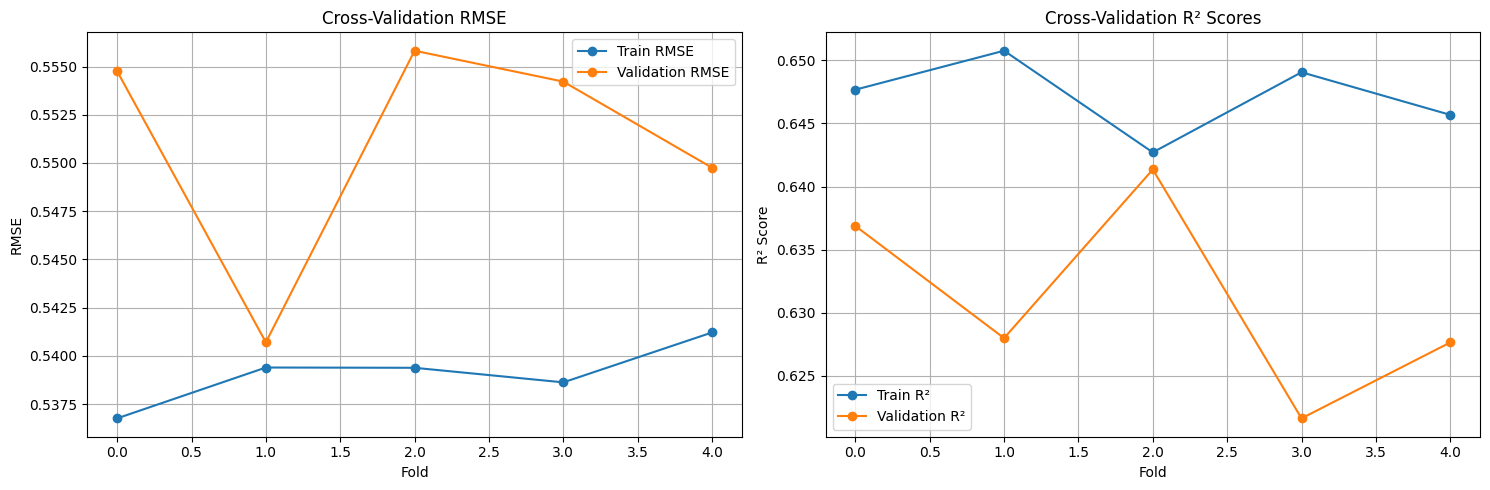


=== 交叉验证结果 ===
平均训练RMSE: 0.5391 (±0.0014)
平均验证RMSE: 0.5511 (±0.0056)
平均训练R²: 0.6472 (±0.0028)
平均验证R²: 0.6311 (±0.0071)

使用 496 轮训练最终模型...
[0]	train-rmse:0.89006
[100]	train-rmse:0.59677
[200]	train-rmse:0.55308
[300]	train-rmse:0.53985
[400]	train-rmse:0.53438
[495]	train-rmse:0.53095

绘制学习曲线...


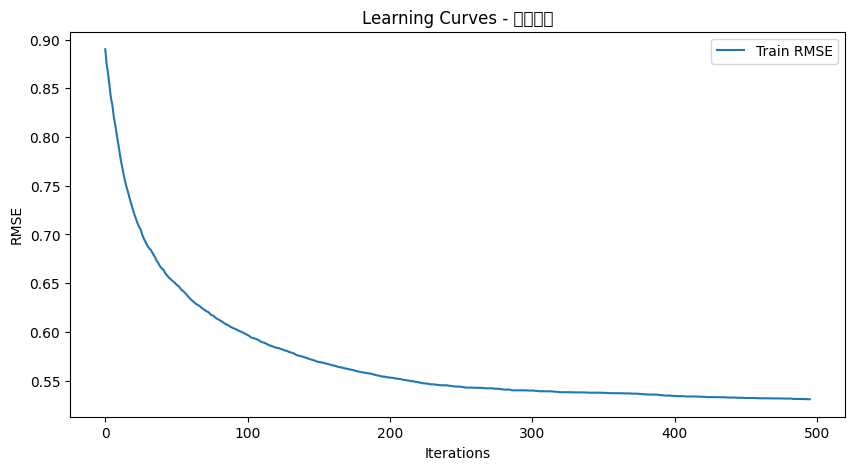


评估最终模型...

=== 最终测试指标 ===
RMSE: 0.5849
R²: 0.5642
MAE: 0.4006

绘制最终模型性能...


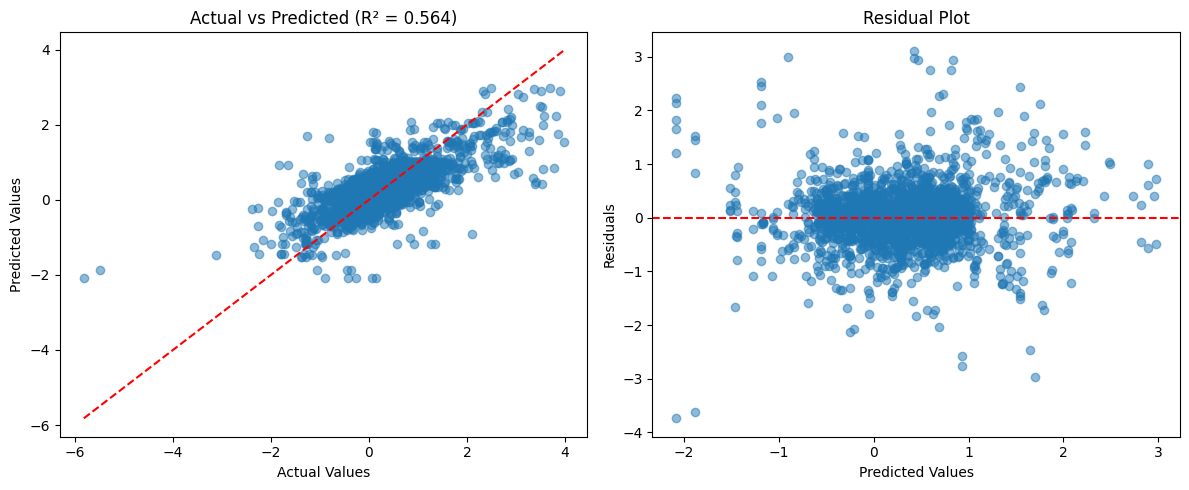


分析 LUtype 特征重要性...


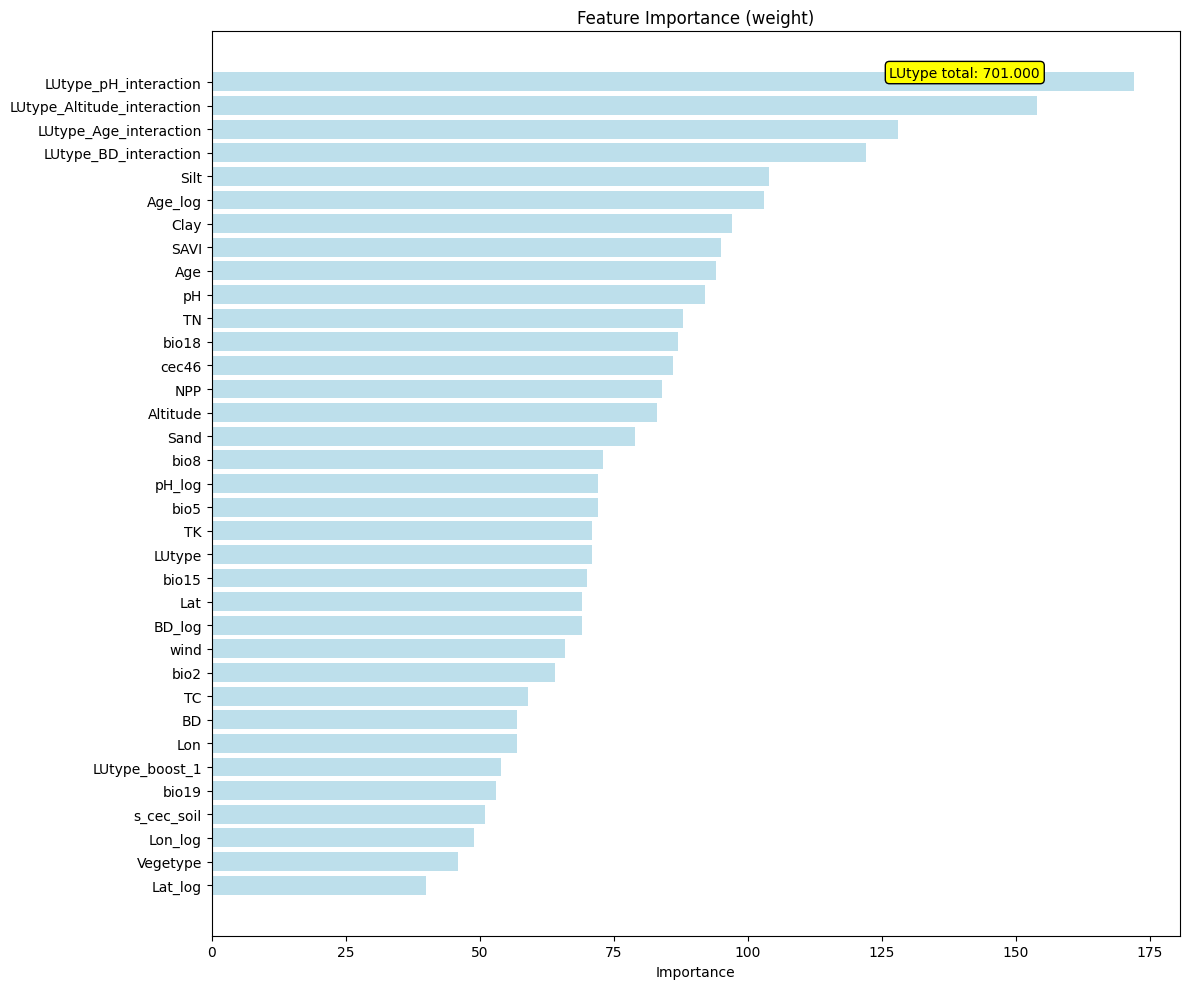


=== LUtype Feature Importance Analysis ===
Total LUtype-related features: 8
Total importance of LUtype features: 766.000
Average importance of LUtype features: 95.750

LUtype importance percentage: 24.65%

Top LUtype-related features:
  LUtype_pH_interaction: 172.0000
  LUtype_Altitude_interaction: 154.0000
  LUtype_Age_interaction: 128.0000
  LUtype_BD_interaction: 122.0000
  LUtype: 71.0000
  LUtype_boost_1: 54.0000
  LUtype_boost_2: 38.0000
  LUtype_squared: 27.0000

生成SHAP摘要图...


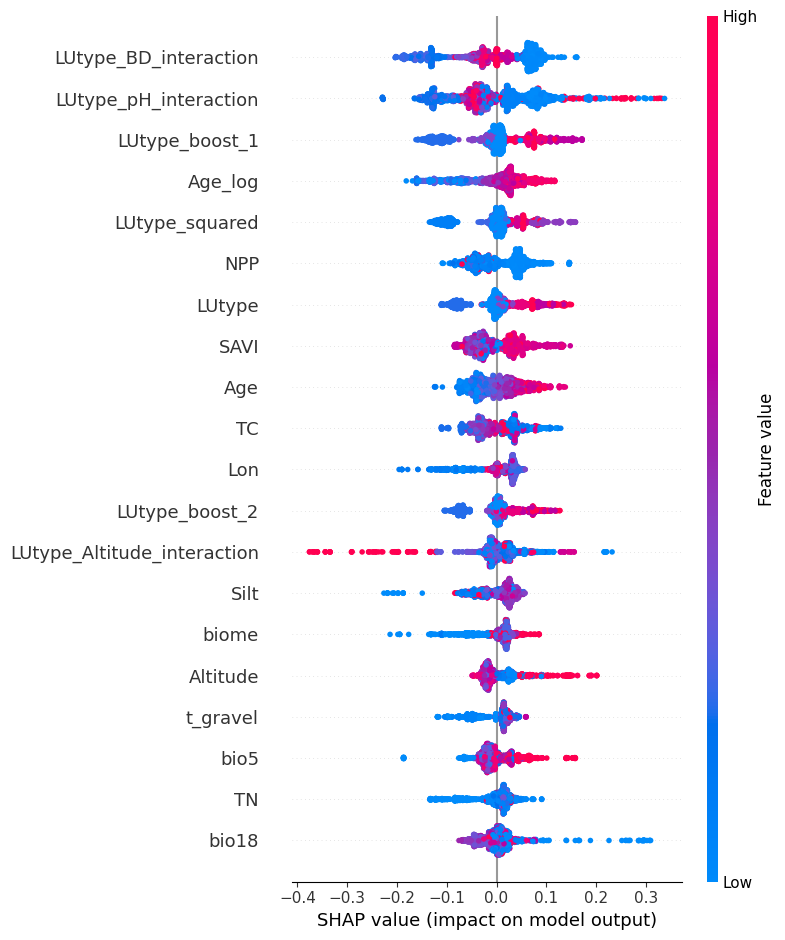

<Figure size 640x480 with 0 Axes>


保存结果...

=== 模型训练总结 ===
✓ 修复了数据泄露问题
✓ 添加了异常值检测和处理
✓ 安全的特征工程（避免数据泄露）
✓ 创建了多个LUtype特征副本
✓ 添加了LUtype与其他重要变量的交互特征
✓ 添加了LUtype平方项（非线性效应）
✓ 改进了超参数搜索空间以更好地处理分类特征
✓ 测试集使用原始数据（无增强噪声）

=== 完成! ===


In [38]:
# SOC model LUtype enhance - remove category2 1130
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import joblib
import os
import re
from pathlib import Path
import warnings
import builtins
from scipy import stats
open = builtins.open

warnings.filterwarnings('ignore')

# SHAP availability check
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """强化正则化的目标函数"""
        params = {
            'eta': trial.suggest_float('eta', 0.005, 0.1, log=True),  # 更低的学习率
            'max_depth': trial.suggest_int('max_depth', 2, 4),  # 更浅的树
            'subsample': trial.suggest_float('subsample', 0.4, 0.7),  # 更低的子采样
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.7),  # 更低的特征采样
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 0.7),
            'min_child_weight': trial.suggest_int('min_child_weight', 10, 20),  # 更高的最小子节点权重
            'lambda': trial.suggest_float('lambda', 10, 25.0),  # 更强的L2正则化
            'alpha': trial.suggest_float('alpha', 5.0, 15.0),  # 更强的L1正则化
            'gamma': trial.suggest_float('gamma', 0.5, 2.0),  # 更高的剪枝参数
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 1),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=800,  # 更多的轮次但更保守的早停
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=25,  # 更保守的早停
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        # 更强的过拟合惩罚
        train_rmse = cv_results['train-rmse-mean'].iloc[-1]
        val_rmse = cv_results['test-rmse-mean'].iloc[-1]
        
        # 计算过拟合程度
        overfitting_ratio = (train_rmse - val_rmse) / train_rmse
        gap_penalty = max(0, overfitting_ratio) * 0.3  # 更强的惩罚
        
        # 如果过拟合严重，增加额外惩罚
        if overfitting_ratio > 0.1:
            gap_penalty += (overfitting_ratio - 0.1) * 0.5
            
        return val_rmse + gap_penalty
    
    def tune_hyperparameters(self, dtrain, n_trials=20):  # 增加试验次数
        """专注于泛化的超参数调优"""
        study = optuna.create_study(direction='minimize')
        
        print("Tuning hyperparameters with aggressive overfitting prevention...")
        print("Using very strong regularization and shallow trees")

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials//5)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        print(f"Best parameters found: {self.best_params}")
        return self.best_params


    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """训练模型，专注于防止过拟合"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=25,  # 更保守的早停
            verbose_eval=100,  # 减少输出频率
            evals_result=evals_result
        )

        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'): 
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=30):
        """Plot feature importance without category-specific highlighting"""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # 获取特征重要性
        importance_dict = model.get_score(importance_type=importance_type)
        
        if not importance_dict:
            print("No feature importance data available.")
            return None
            
        # 转换为DataFrame以便排序
        importance_df = pd.DataFrame({
            'feature': list(importance_dict.keys()),
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=True)
        
        # 只显示top_n特征
        if len(importance_df) > top_n:
            importance_df = importance_df.tail(top_n)
        
        # 绘制水平条形图
        y_pos = np.arange(len(importance_df))
        colors = ['lightblue'] * len(importance_df)
        
        ax.barh(y_pos, importance_df['importance'], color=colors, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance')
        
        title = f'Feature Importance ({importance_type})'
        ax.set_title(title)
        
        # 添加LUtype重要性说明
        lu_type_features = importance_df[importance_df['feature'].str.contains('LUtype', na=False)]
        lu_type_importance = lu_type_features['importance'].sum() if not lu_type_features.empty else 0
        
        ax.text(0.7, 0.95, f'LUtype total: {lu_type_importance:.3f}', 
                transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        plt.tight_layout()
        plt.show()
        
        return importance_df

    def analyze_lutype_importance(self, model, X):
        """分析LUtype相关特征的重要性，不关注特定类别"""
        importance_dict = model.get_score(importance_type='weight')
        
        if not importance_dict:
            print("No feature importance data available.")
            return
            
        # 分类统计不同特征
        lutype_features = {k: v for k, v in importance_dict.items() if 'LUtype' in k}
        other_features = {k: v for k, v in importance_dict.items() if 'LUtype' not in k}
        
        print(f"\n=== LUtype Feature Importance Analysis ===")
        print(f"Total LUtype-related features: {len(lutype_features)}")
        print(f"Total importance of LUtype features: {sum(lutype_features.values()):.3f}")
        print(f"Average importance of LUtype features: {np.mean(list(lutype_features.values())) if lutype_features else 0:.3f}")
        
        total_importance = sum(importance_dict.values())
        lu_type_percentage = (sum(lutype_features.values()) / total_importance * 100) if total_importance > 0 else 0
        
        print(f"\nLUtype importance percentage: {lu_type_percentage:.2f}%")
        
        # 打印最重要的LUtype特征
        if lutype_features:
            sorted_lutype = sorted(lutype_features.items(), key=lambda x: x[1], reverse=True)
            print(f"\nTop LUtype-related features:")
            for feature, importance in sorted_lutype[:10]:
                print(f"  {feature}: {importance:.4f}")
        else:
            print("\nNo LUtype-related features found in importance scores.")

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

def detect_outliers_iqr(df, columns, threshold=1.5):
    """使用IQR方法检测异常值"""
    outlier_indices = []
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            outlier_indices.extend(outliers)
            
            if len(outliers) > 0:
                print(f"  {col}: 发现 {len(outliers)} 个异常值 "
                      f"({len(outliers)/len(df)*100:.2f}%)")
    
    return list(set(outlier_indices))

def remove_outliers_robust(df, y, columns, method='iqr', threshold=2.0):
    """鲁棒的异常值处理方法"""
    print("开始异常值检测...")
    
    if method == 'iqr':
        outlier_indices = detect_outliers_iqr(df, columns, threshold)
    elif method == 'zscore':
        # Z-score方法
        z_scores = np.abs(stats.zscore(df[columns]))
        outlier_indices = np.where(z_scores > threshold)[0]
        outlier_indices = list(outlier_indices)
    else:
        return df, y, []
    
    print(f"\n总共发现 {len(outlier_indices)} 个异常值样本")
    
    if len(outlier_indices) > 0:
        df_clean = df.drop(outlier_indices)
        y_clean = y.drop(outlier_indices)
        print(f"清除异常值后数据大小: {len(df_clean)} (移除了 {len(outlier_indices)} 个样本)")
        return df_clean, y_clean, outlier_indices
    
    print("未发现异常值")
    return df, y, []

def check_data_leakage(X_train, X_test, y_train, y_test):
    """检查数据泄露"""
    print("\n=== 数据泄露检查 ===")
    
    # 检查训练集和测试集是否有重叠
    train_indices = set(X_train.index)
    test_indices = set(X_test.index)
    overlap = train_indices.intersection(test_indices)
    
    if overlap:
        print(f"❌ 发现数据泄露: 训练集和测试集有 {len(overlap)} 个重叠样本")
    else:
        print("✅ 训练集和测试集没有重叠")
    
    # 检查特征分布
    print(f"训练集大小: {len(X_train)}")
    print(f"测试集大小: {len(X_test)}")
    print(f"特征数量: {X_train.shape[1]}")
    
    return len(overlap) == 0

def safe_feature_engineering(X_train, X_test):
    """安全的特征工程，避免数据泄露"""
    print("进行安全的特征工程...")
    
    # 1. 对数变换
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in X_train.columns:
            X_train[col + '_log'] = np.log(X_train[col] + 1e-8)
            X_test[col + '_log'] = np.log(X_test[col] + 1e-8)
            print(f"  创建对数特征: {col}_log")
    
    # 2. 分箱（基于训练集的分位数）
    if 'Altitude' in X_train.columns:
        # 使用训练集计算分箱边界
        alt_bins = pd.cut(X_train['Altitude'], bins=5, retbins=True)[1]
        X_train['Altitude_bins'] = pd.cut(X_train['Altitude'], bins=alt_bins, labels=False)
        X_test['Altitude_bins'] = pd.cut(X_test['Altitude'], bins=alt_bins, labels=False)
        print("  创建分箱特征: Altitude_bins")
    
    return X_train, X_test

def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    """Augment continuous features with noise - 只对训练集使用"""
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented

def enhanced_load_and_prepare_data(augment=True, augmentation_factor=2, 
                                 lu_type_importance_boost=3.0, 
                                 outlier_threshold=2.0):
    """修复数据泄露并添加异常值处理的版本"""
    
    # 加载数据
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    # 选择目标土层
    target_layer = "topsoil" ###################################################################################SELECT LAYER
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    # 选择特征
    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    # 数据清洗
    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    X = df[valid_x_cols].astype('float32').fillna(0)
    y = df['yi'].astype('float32')

    print(f"原始数据大小: {len(X)}")
    
    # 异常值检测和处理
    continuous_cols = ['Lon', 'Lat', 'Age', 'BD', 'pH', 'Altitude']
    continuous_cols = [col for col in continuous_cols if col in X.columns]
    
    print("\n=== 异常值处理 ===")
    X_clean, y_clean, outliers = remove_outliers_robust(
        X, y, continuous_cols, threshold=outlier_threshold
    )

    # 数据分割
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.3, random_state=42
    )

    # 安全的特征工程
    X_train, X_test = safe_feature_engineering(X_train, X_test)

    # 数据泄露检查
    check_data_leakage(X_train, X_test, y_train, y_test)

    # LUtype特征增强（只对训练集）
    if 'LUtype' in X_train.columns:
        print(f"\n=== LUtype 特征增强 ===")
        print(f"原始 LUtype 分布:")
        print(X_train['LUtype'].value_counts().sort_index())
        
        print(f"\n增强 LUtype 重要性，因子: {lu_type_importance_boost}")
        
        # 创建LUtype特征增强
        for i in range(int(lu_type_importance_boost) - 1):
            lu_type_col_name = f'LUtype_boost_{i+1}'
            X_train[lu_type_col_name] = X_train['LUtype']
            X_test[lu_type_col_name] = X_test['LUtype']
            print(f"  创建 LUtype 副本: {lu_type_col_name}")
        
        # 创建LUtype与其他重要特征的交互项
        important_features = ['pH', 'BD', 'Age', 'Altitude']
        for feature in important_features:
            if feature in X_train.columns:
                interaction_name = f'LUtype_{feature}_interaction'
                X_train[interaction_name] = X_train['LUtype'] * X_train[feature]
                X_test[interaction_name] = X_test['LUtype'] * X_test[feature]
                print(f"  创建交互特征: {interaction_name}")
        
        # 创建LUtype的平方项（非线性效应）
        X_train['LUtype_squared'] = X_train['LUtype'] ** 2
        X_test['LUtype_squared'] = X_test['LUtype'] ** 2
        print("  创建 LUtype_squared")
    
    # 数据增强（只对训练集）
    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]
        continuous_cols = [col for col in continuous_cols if col in X_train.columns]
        
        print(f"\n=== 数据增强 ===")
        print(f"训练集增强前大小: {len(X_train)}")
        X_train, y_train = augment_continuous_features(
            X=X_train,  # 只对训练集增强
            y=y_train,  # 只对训练集增强
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
        print(f"训练集增强后大小: {len(X_train)}")
    else:
        print("\n跳过数据增强")

    print(f"\n=== 最终数据集统计 ===")
    print(f"训练集大小: {len(X_train)}")
    print(f"测试集大小: {len(X_test)}")
    print(f"总特征数量: {len(X_train.columns)}")
    
    # 统计特征分布
    lu_type_cols = [col for col in X_train.columns if 'LUtype' in col]
    
    print(f"\n特征统计:")
    print(f"LUtype 相关特征: {len(lu_type_cols)}")

    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, X, y, X_test, y_test, X_train, y_train

def main():
    """Main function with data leakage prevention"""
    outlier_threshold = 2.0  # 异常值检测阈值
    
    print("=== 开始增强的XGBoost建模（修复数据泄露版本）===")
    
    # 使用修复的数据处理（包含异常值处理和数据泄露预防）
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = enhanced_load_and_prepare_data(
        augment=True,
        augmentation_factor=3,
        lu_type_importance_boost=3.0,
        outlier_threshold=outlier_threshold
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("\n=== 开始超参数调优 ===")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)
    print(f"最佳参数: {best_params}")

    # 2. Cross-validation with model saving
    print("\n=== 开始交叉验证 ===")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    
    print("\n保存的CV模型:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    
    # Plot CV results
    print("\n绘制交叉验证结果...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== 交叉验证结果 ===")
    print(f"平均训练RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"平均验证RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"平均训练R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"平均验证R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\n使用 {optimal_rounds} 轮训练最终模型...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    # Plot learning curves
    print("\n绘制学习曲线...")
    tuner.plot_learning_curves(evals_result, "最终模型")

    # 4. Evaluate and plot final performance
    print("\n评估最终模型...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== 最终测试指标 ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\n绘制最终模型性能...")
    tuner.plot_final_model_performance(final_model, dtest)

    # 5. 分析LUtype重要性
    print(f"\n分析 LUtype 特征重要性...")
    importance_df = tuner.plot_feature_importance(final_model, top_n=35)
    
    # 详细分析LUtype重要性
    tuner.analyze_lutype_importance(final_model, X_test)
    
    # 6. SHAP分析
    if SHAP_AVAILABLE:
        print("\n生成SHAP摘要图...")
        tuner.plot_shap_summary(final_model, X_test)
        # 7. 保存结果
    print("\n保存结果...")
    tuner.save_results(final_model, 'F:/model/results')
    
    print(f"\n=== 模型训练总结 ===")
    print("✓ 修复了数据泄露问题")
    print("✓ 添加了异常值检测和处理")
    print("✓ 安全的特征工程（避免数据泄露）")
    print("✓ 创建了多个LUtype特征副本")
    print("✓ 添加了LUtype与其他重要变量的交互特征")
    print("✓ 添加了LUtype平方项（非线性效应）")
    print("✓ 改进了超参数搜索空间以更好地处理分类特征")
    print("✓ 测试集使用原始数据（无增强噪声）")
    
    print("\n=== 完成! ===")

if __name__ == "__main__":
    main()

=== Starting Enhanced XGBoost Modeling (Fixed Data Leakage Version) ===
Original data size: 2458

=== Outlier Handling ===
Starting outlier detection...
  Lon: Found 482 outliers (19.61%)
  Lat: Found 66 outliers (2.69%)
  Age: Found 42 outliers (1.71%)
  BD: Found 31 outliers (1.26%)

Total outliers found: 524
Data size after removing outliers: 1934 (removed 524 samples)
Performing safe feature engineering...
  Created log feature: Lon_log
  Created log feature: Lat_log
  Created log feature: Age_log
  Created log feature: BD_log
  Created log feature: pH_log
  Created binned feature: Altitude_bins

=== Data Leakage Check ===
✅ No overlap between train and test sets
Training set size: 1353
Test set size: 581
Number of features: 40

=== LUtype Feature Enhancement ===
Original LUtype distribution:
LUtype
1.0    610
2.0    191
3.0    151
4.0    100
5.0    157
6.0    117
7.0     27
Name: count, dtype: int64

Enhancing LUtype importance with factor: 3.0
  Created LUtype copy: LUtype_boost_

[I 2025-12-02 00:05:04,231] A new study created in memory with name: no-name-a2a96241-6b0c-4859-8d22-ecc6bb52dc53


Training set size after augmentation: 5412

=== Final Dataset Statistics ===
Training set size: 5412
Test set size: 581
Total number of features: 47

Feature statistics:
LUtype-related features: 8

=== Starting Hyperparameter Tuning ===
Tuning hyperparameters with aggressive overfitting prevention...
Using very strong regularization and shallow trees


[I 2025-12-02 00:05:08,316] Trial 1 finished with value: 0.5396057804678053 and parameters: {'eta': 0.005894684681738304, 'max_depth': 2, 'subsample': 0.4525505877562778, 'colsample_bytree': 0.5746866944830412, 'colsample_bylevel': 0.4390978612703759, 'min_child_weight': 14, 'lambda': 22.88342224647876, 'alpha': 11.741132933823161, 'gamma': 1.1624429869757504, 'max_delta_step': 1}. Best is trial 1 with value: 0.5396057804678053.
[I 2025-12-02 00:05:09,262] Trial 0 finished with value: 0.4552629455635051 and parameters: {'eta': 0.007796397378427842, 'max_depth': 3, 'subsample': 0.5455105496728074, 'colsample_bytree': 0.619765623420598, 'colsample_bylevel': 0.5926891099233346, 'min_child_weight': 19, 'lambda': 21.225110158948453, 'alpha': 7.688343342075681, 'gamma': 0.6019764512867223, 'max_delta_step': 0}. Best is trial 0 with value: 0.4552629455635051.
[I 2025-12-02 00:05:13,549] Trial 2 finished with value: 0.47105359849933065 and parameters: {'eta': 0.005041643002186098, 'max_depth':

Best parameters found: {'eta': 0.018953013100891886, 'max_depth': 4, 'subsample': 0.502896987614293, 'colsample_bytree': 0.6136513465416128, 'colsample_bylevel': 0.5159812991678058, 'min_child_weight': 12, 'lambda': 17.0608850433904, 'alpha': 5.328202707712203, 'gamma': 1.3386741502862276, 'max_delta_step': 0, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 17}
Best parameters: {'eta': 0.018953013100891886, 'max_depth': 4, 'subsample': 0.502896987614293, 'colsample_bytree': 0.6136513465416128, 'colsample_bylevel': 0.5159812991678058, 'min_child_weight': 12, 'lambda': 17.0608850433904, 'alpha': 5.328202707712203, 'gamma': 1.3386741502862276, 'max_delta_step': 0, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 17}

=== Starting 10x5 Cross-Validation ===
[0]	train-rmse:0.76971	valid-rmse:0.79137
[0]	train-rmse:0.77565	valid-rmse:0.76760
[0]	train-rmse:0.77929	valid-rmse:0.75225
[0]	train-rmse:0.77118	valid-rmse:0.78644
[0]	trai

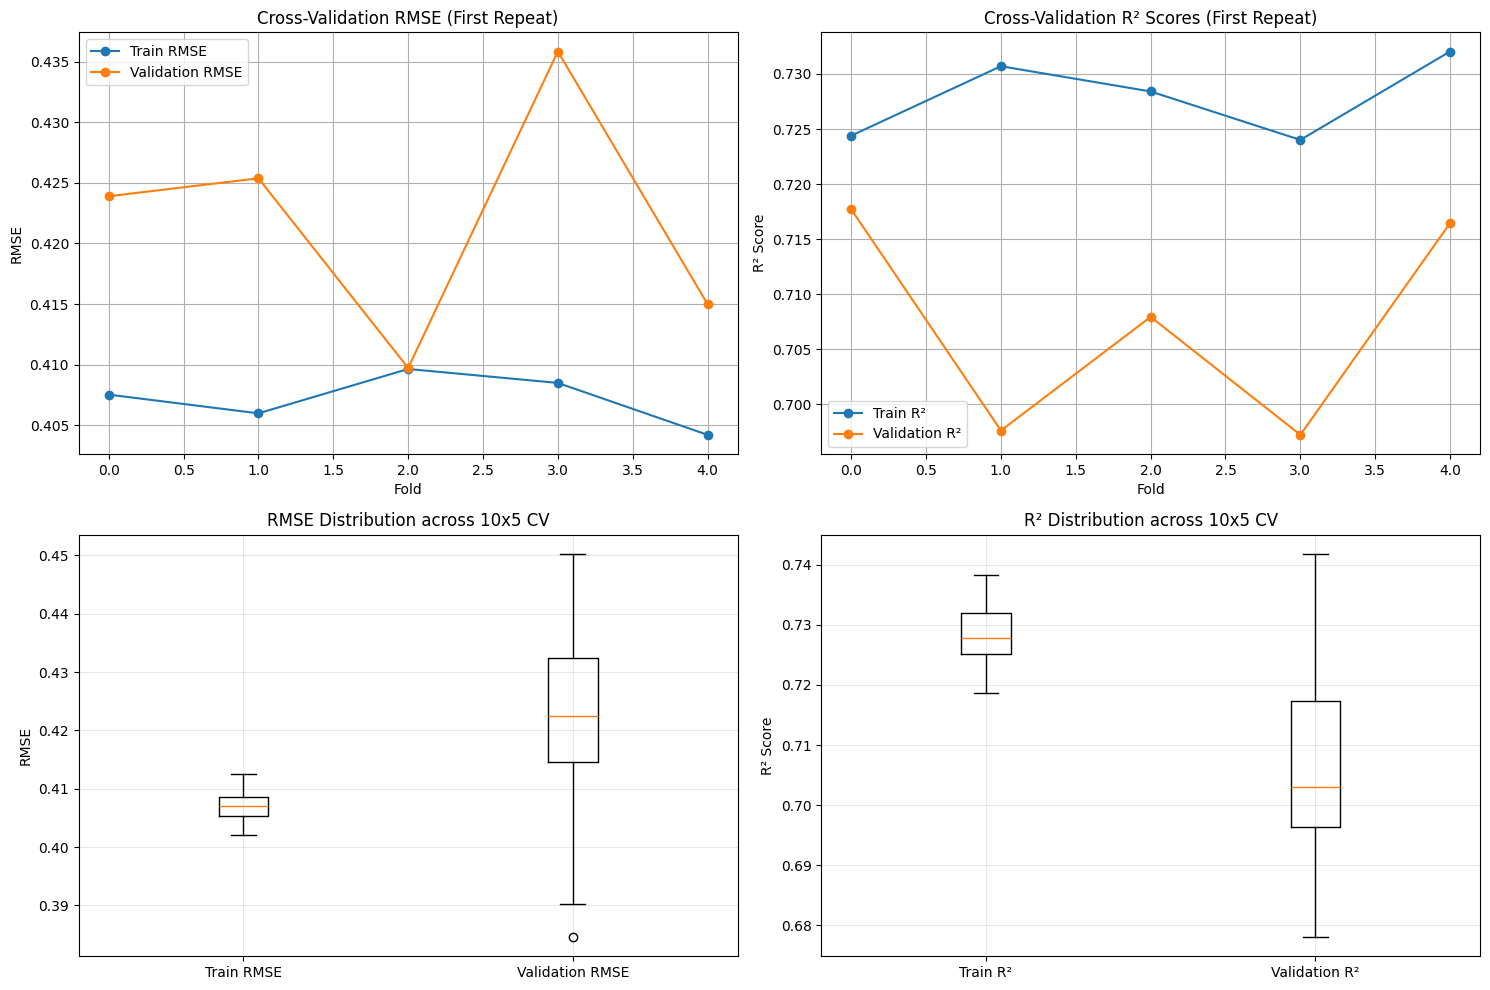


=== 10x5 Cross-Validation Summary ===
Average Train RMSE: 0.4068 (±0.0024)
Average Validation RMSE: 0.4227 (±0.0140)
Average Train R²: 0.7283 (±0.0044)
Average Validation R²: 0.7062 (±0.0161)
Average Best Iterations: 497.0 (±2.5)

=== 交叉验证结果 (旧格式兼容) ===
平均训练RMSE: 0.4068 (±0.0024)
平均验证RMSE: 0.4227 (±0.0140)
平均训练R²: 0.7283 (±0.0044)
平均验证R²: 0.7062 (±0.0161)

Training final model with 497 rounds...
[0]	train-rmse:0.77369
[100]	train-rmse:0.49814
[200]	train-rmse:0.42985
[300]	train-rmse:0.40516
[400]	train-rmse:0.39758
[496]	train-rmse:0.39433

Plotting learning curves...


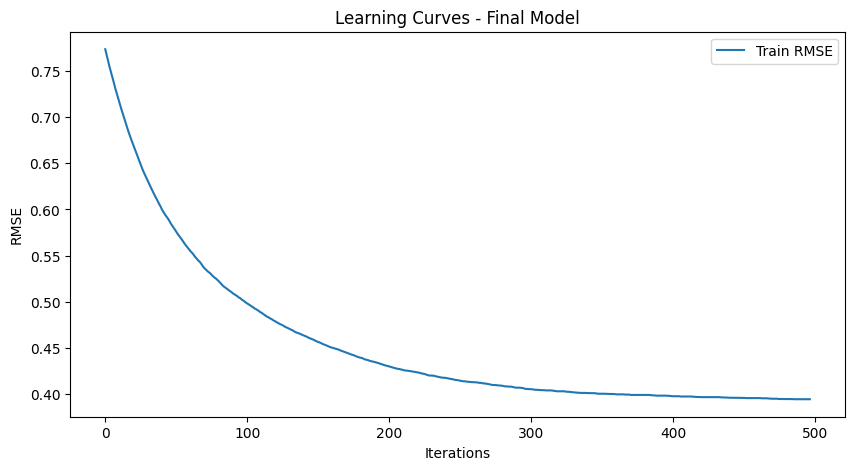


Evaluating final model...

=== Final Test Metrics ===
RMSE: 0.5025
R²: 0.6620
MAE: 0.3707

Plotting final model performance...


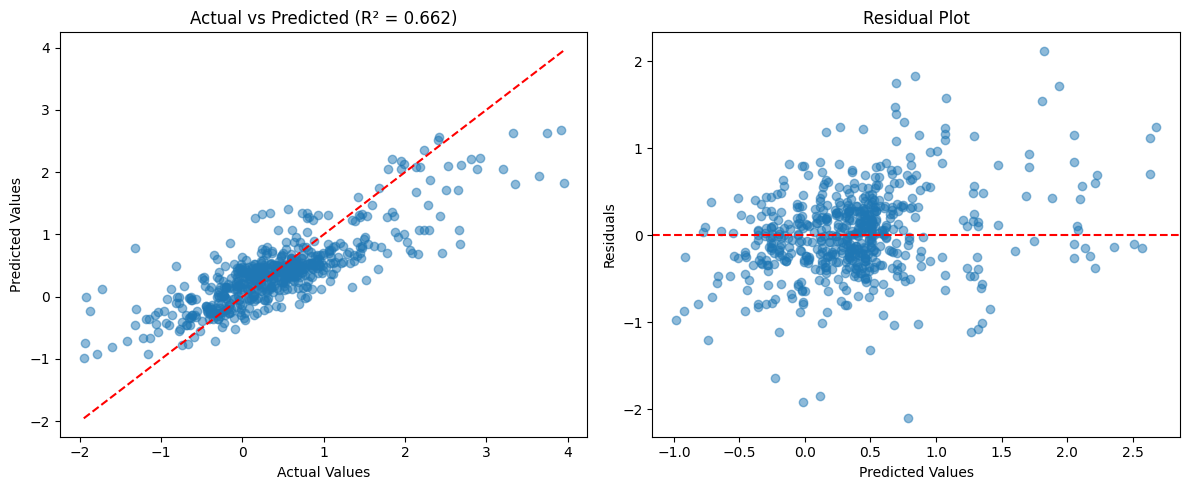


Analyzing LUtype feature importance...


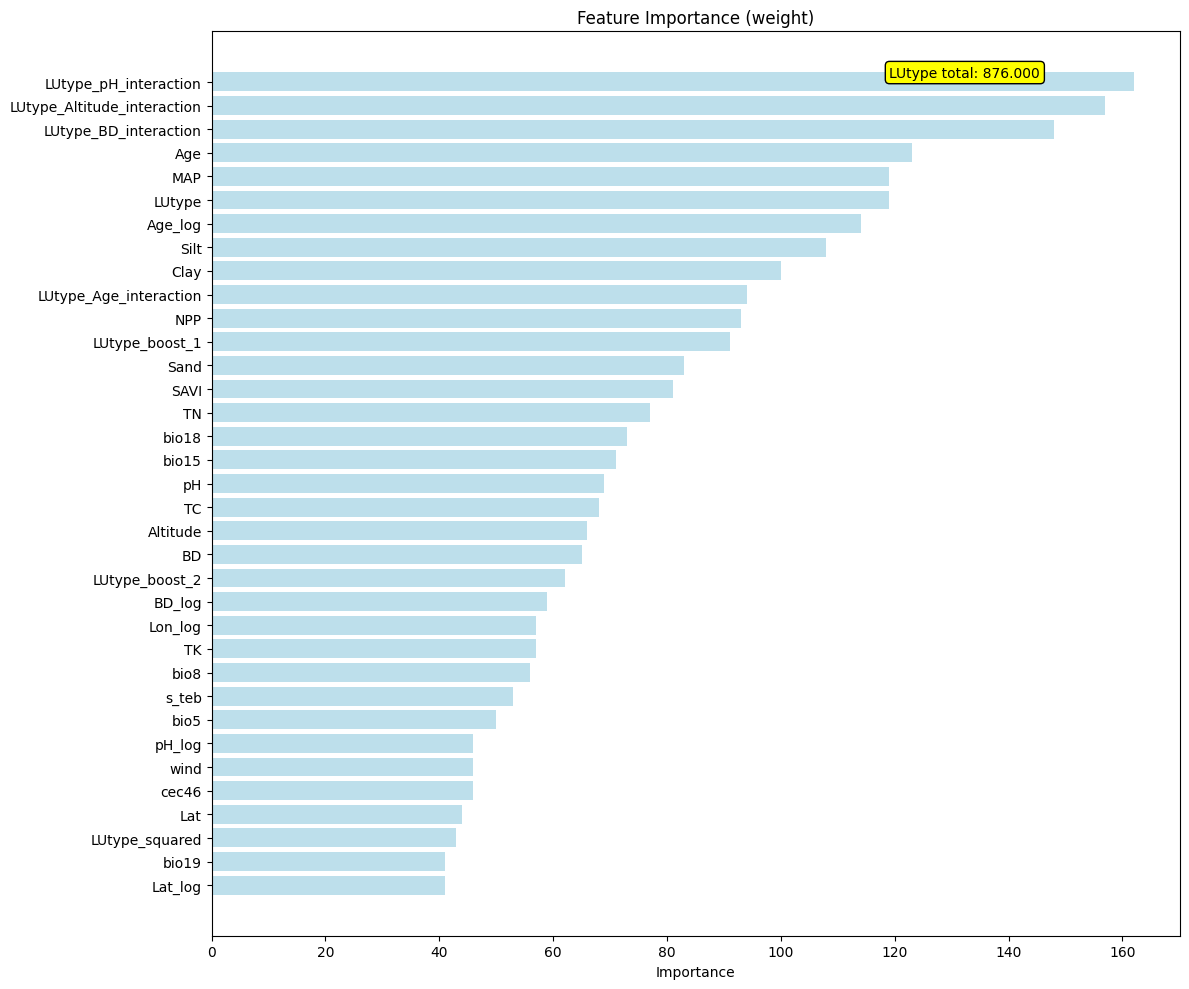


=== LUtype Feature Importance Analysis ===
Total LUtype-related features: 8
Total importance of LUtype features: 876.000
Average importance of LUtype features: 109.500

LUtype importance percentage: 28.65%

Top LUtype-related features:
  LUtype_pH_interaction: 162.0000
  LUtype_Altitude_interaction: 157.0000
  LUtype_BD_interaction: 148.0000
  LUtype: 119.0000
  LUtype_Age_interaction: 94.0000
  LUtype_boost_1: 91.0000
  LUtype_boost_2: 62.0000
  LUtype_squared: 43.0000

Generating SHAP summary plot...


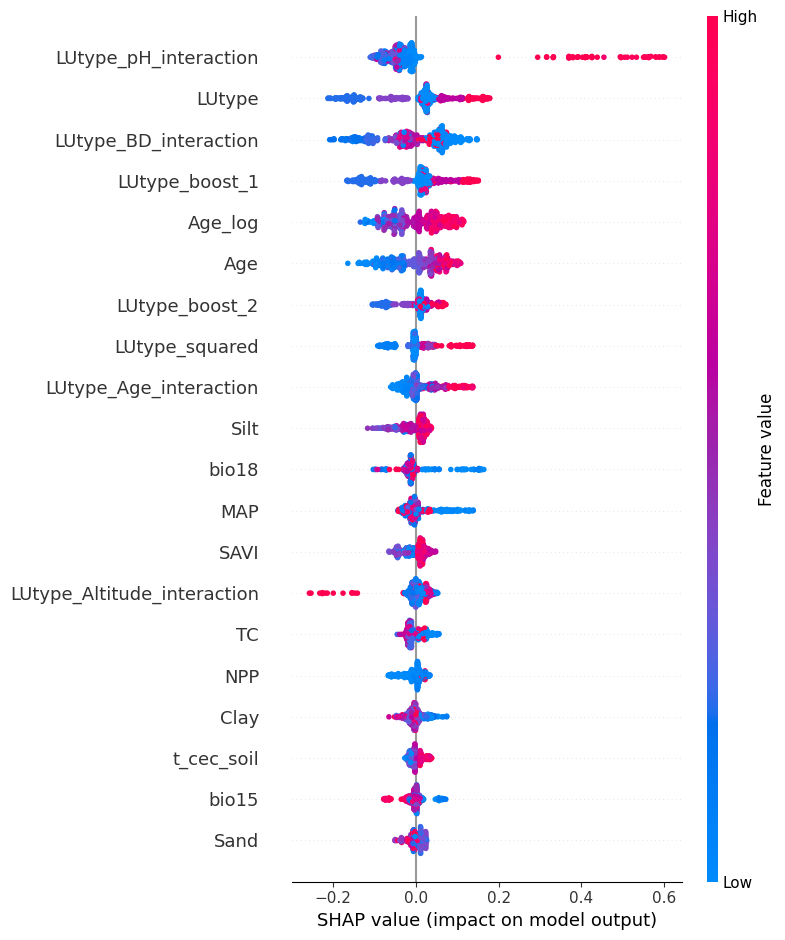

<Figure size 640x480 with 0 Axes>


Saving results...
Saved detailed CV results to: F:/model/results/cv_summary.csv

=== Model Training Summary ===
✓ Fixed data leakage issues
✓ Added outlier detection and handling
✓ Safe feature engineering (avoided data leakage)
✓ Created multiple LUtype feature copies
✓ Added LUtype interaction features with other important variables
✓ Added LUtype squared term (non-linear effect)
✓ Improved hyperparameter search space for better handling of categorical features
✓ Test set uses original data (no augmentation noise)
✓ Implemented 10 repetitions of 5-fold cross-validation for robust evaluation

=== Complete! ===


In [59]:
# active top 1201#
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import joblib
import os
import re
from pathlib import Path
import warnings
import builtins
from scipy import stats
open = builtins.open

warnings.filterwarnings('ignore')

# SHAP availability check
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Objective function with enhanced regularization"""
        params = {
            'eta': trial.suggest_float('eta', 0.005, 0.1, log=True),  # Lower learning rate
            'max_depth': trial.suggest_int('max_depth', 2, 4),  # Shallower trees
            'subsample': trial.suggest_float('subsample', 0.4, 0.7),  # Lower subsampling
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.7),  # Lower feature sampling
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 0.7),
            'min_child_weight': trial.suggest_int('min_child_weight', 10, 20),  # Higher min child weight
            'lambda': trial.suggest_float('lambda', 10, 25.0),  # Stronger L2 regularization
            'alpha': trial.suggest_float('alpha', 5.0, 15.0),  # Stronger L1 regularization
            'gamma': trial.suggest_float('gamma', 0.5, 2.0),  # Higher pruning parameter
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 1),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=800,  # More rounds but more conservative early stopping
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=25,  # More conservative early stopping
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        # Stronger overfitting penalty
        train_rmse = cv_results['train-rmse-mean'].iloc[-1]
        val_rmse = cv_results['test-rmse-mean'].iloc[-1]
        
        # Calculate overfitting degree
        overfitting_ratio = (train_rmse - val_rmse) / train_rmse
        gap_penalty = max(0, overfitting_ratio) * 0.3  # Stronger penalty
        
        # Add extra penalty if severe overfitting
        if overfitting_ratio > 0.1:
            gap_penalty += (overfitting_ratio - 0.1) * 0.5
            
        return val_rmse + gap_penalty
    
    def tune_hyperparameters(self, dtrain, n_trials=20):  # Increased number of trials
        """Hyperparameter tuning focused on generalization"""
        study = optuna.create_study(direction='minimize')
        
        print("Tuning hyperparameters with aggressive overfitting prevention...")
        print("Using very strong regularization and shallow trees")

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials//5)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        print(f"Best parameters found: {self.best_params}")
        return self.best_params


    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Train model with focus on preventing overfitting"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=25,  # More conservative early stopping
            verbose_eval=100,  # Reduced output frequency
            evals_result=evals_result
        )

        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models', n_repeats=10): 
        """Enhanced CV with 10 repetitions of 5-fold cross-validation and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        all_cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': [],
            'repeat': [],
            'fold': []
        }

        def process_fold(repeat_idx, fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_repeat_{repeat_idx}_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else params.get('num_boost_round', 500),
                model_path,
                model.feature_names,
                repeat_idx,
                fold_idx
            )
        
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for repeat_idx in range(n_repeats):
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed + repeat_idx)
                for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                    futures.append(executor.submit(
                        process_fold, repeat_idx, fold_idx, train_idx, val_idx
                    ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names, repeat_idx, fold_idx = future.result()
                all_cv_results['train_rmse'].append(train_rmse)
                all_cv_results['val_rmse'].append(val_rmse)
                all_cv_results['train_r2'].append(train_r2)
                all_cv_results['val_r2'].append(val_r2)
                all_cv_results['best_iterations'].append(best_iter)
                all_cv_results['model_paths'].append(model_path)
                all_cv_results['feature_names'].append(feature_names)
                all_cv_results['repeat'].append(repeat_idx)
                all_cv_results['fold'].append(fold_idx)
        # Create summary statistics
        cv_results_summary = {
            'train_rmse_mean': np.mean(all_cv_results['train_rmse']),
            'train_rmse_std': np.std(all_cv_results['train_rmse']),
            'val_rmse_mean': np.mean(all_cv_results['val_rmse']),
            'val_rmse_std': np.std(all_cv_results['val_rmse']),
            'train_r2_mean': np.mean(all_cv_results['train_r2']),
            'train_r2_std': np.std(all_cv_results['train_r2']),
            'val_r2_mean': np.mean(all_cv_results['val_r2']),
            'val_r2_std': np.std(all_cv_results['val_r2']),
            'best_iterations_mean': np.mean(all_cv_results['best_iterations']),
            'best_iterations_std': np.std(all_cv_results['best_iterations']),
            'detailed_results': pd.DataFrame(all_cv_results)
        }

        return cv_results_summary

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results_summary):
        """Plot enhanced cross-validation results with both original and new visualization"""
        # Check if it's the new summary format or old list format
        if isinstance(cv_results_summary, dict) and 'detailed_results' in cv_results_summary:
            # New format - use the detailed results
            detailed_results = cv_results_summary['detailed_results']
            
            # Create two visualizations:
            # 1. Original visualization (simple line plot for first repeat)
            plt.figure(figsize=(15, 10))
            
            # Plot 1: Original style - first repeat only
            plt.subplot(2, 2, 1)
            first_repeat = detailed_results[detailed_results['repeat'] == 0]
            plt.plot(first_repeat['train_rmse'], 'o-', label='Train RMSE')
            plt.plot(first_repeat['val_rmse'], 'o-', label='Validation RMSE')
            plt.xlabel('Fold')
            plt.ylabel('RMSE')
            plt.title('Cross-Validation RMSE (First Repeat)')
            plt.legend()
            plt.grid(True)

            # Plot 2: Original style - first repeat R²
            plt.subplot(2, 2, 2)
            plt.plot(first_repeat['train_r2'], 'o-', label='Train R²')
            plt.plot(first_repeat['val_r2'], 'o-', label='Validation R²')
            plt.xlabel('Fold')
            plt.ylabel('R² Score')
            plt.title('Cross-Validation R² Scores (First Repeat)')
            plt.legend()
            plt.grid(True)

            # Plot 3: New visualization - RMSE distribution across all repeats
            plt.subplot(2, 2, 3)
            plt.boxplot([detailed_results['train_rmse'], detailed_results['val_rmse']], 
                       labels=['Train RMSE', 'Validation RMSE'])
            plt.ylabel('RMSE')
            plt.title('RMSE Distribution across 10x5 CV')
            plt.grid(True, alpha=0.3)
            
            # Plot 4: New visualization - R² distribution across all repeats
            plt.subplot(2, 2, 4)
            plt.boxplot([detailed_results['train_r2'], detailed_results['val_r2']], 
                       labels=['Train R²', 'Validation R²'])
            plt.ylabel('R² Score')
            plt.title('R² Distribution across 10x5 CV')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print("\n=== 10x5 Cross-Validation Summary ===")
            print(f"Average Train RMSE: {cv_results_summary['train_rmse_mean']:.4f} (±{cv_results_summary['train_rmse_std']:.4f})")
            print(f"Average Validation RMSE: {cv_results_summary['val_rmse_mean']:.4f} (±{cv_results_summary['val_rmse_std']:.4f})")
            print(f"Average Train R²: {cv_results_summary['train_r2_mean']:.4f} (±{cv_results_summary['train_r2_std']:.4f})")
            print(f"Average Validation R²: {cv_results_summary['val_r2_mean']:.4f} (±{cv_results_summary['val_r2_std']:.4f})")
            print(f"Average Best Iterations: {cv_results_summary['best_iterations_mean']:.1f} (±{cv_results_summary['best_iterations_std']:.1f})")
            
            # Also print the format that main() expects
            print("\n=== 交叉验证结果 (旧格式兼容) ===")
            print(f"平均训练RMSE: {cv_results_summary['train_rmse_mean']:.4f} (±{cv_results_summary['train_rmse_std']:.4f})")
            print(f"平均验证RMSE: {cv_results_summary['val_rmse_mean']:.4f} (±{cv_results_summary['val_rmse_std']:.4f})")
            print(f"平均训练R²: {cv_results_summary['train_r2_mean']:.4f} (±{cv_results_summary['train_r2_std']:.4f})")
            print(f"平均验证R²: {cv_results_summary['val_r2_mean']:.4f} (±{cv_results_summary['val_r2_std']:.4f})")
            
        else:
            # Old format - keep original plotting
            plt.figure(figsize=(15, 5))

            # Plot RMSE
            plt.subplot(1, 2, 1)
            plt.plot(cv_results_summary['train_rmse'], 'o-', label='Train RMSE')
            plt.plot(cv_results_summary['val_rmse'], 'o-', label='Validation RMSE')
            plt.xlabel('Fold')
            plt.ylabel('RMSE')
            plt.title('Cross-Validation RMSE')
            plt.legend()
            plt.grid(True)

            # Plot R2
            plt.subplot(1, 2, 2)
            plt.plot(cv_results_summary['train_r2'], 'o-', label='Train R²')
            plt.plot(cv_results_summary['val_r2'], 'o-', label='Validation R²')
            plt.xlabel('Fold')
            plt.ylabel('R² Score')
            plt.title('Cross-Validation R² Scores')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=30):
        """Plot feature importance without category-specific highlighting"""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # 获取特征重要性
        importance_dict = model.get_score(importance_type=importance_type)
        
        if not importance_dict:
            print("No feature importance data available.")
            return None
            
        # 转换为DataFrame以便排序
        importance_df = pd.DataFrame({
            'feature': list(importance_dict.keys()),
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=True)
        
        # 只显示top_n特征
        if len(importance_df) > top_n:
            importance_df = importance_df.tail(top_n)
        
        # 绘制水平条形图
        y_pos = np.arange(len(importance_df))
        colors = ['lightblue'] * len(importance_df)
        
        ax.barh(y_pos, importance_df['importance'], color=colors, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance')
        
        title = f'Feature Importance ({importance_type})'
        ax.set_title(title)
        
        # 添加LUtype重要性说明
        lu_type_features = importance_df[importance_df['feature'].str.contains('LUtype', na=False)]
        lu_type_importance = lu_type_features['importance'].sum() if not lu_type_features.empty else 0
        
        ax.text(0.7, 0.95, f'LUtype total: {lu_type_importance:.3f}', 
                transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        plt.tight_layout()
        plt.show()
        
        return importance_df

    def analyze_lutype_importance(self, model, X):
        """分析LUtype相关特征的重要性，不关注特定类别"""
        importance_dict = model.get_score(importance_type='weight')
        
        if not importance_dict:
            print("No feature importance data available.")
            return
            
        # 分类统计不同特征
        lutype_features = {k: v for k, v in importance_dict.items() if 'LUtype' in k}
        other_features = {k: v for k, v in importance_dict.items() if 'LUtype' not in k}
        
        print(f"\n=== LUtype Feature Importance Analysis ===")
        print(f"Total LUtype-related features: {len(lutype_features)}")
        print(f"Total importance of LUtype features: {sum(lutype_features.values()):.3f}")
        print(f"Average importance of LUtype features: {np.mean(list(lutype_features.values())) if lutype_features else 0:.3f}")
        
        total_importance = sum(importance_dict.values())
        lu_type_percentage = (sum(lutype_features.values()) / total_importance * 100) if total_importance > 0 else 0
        
        print(f"\nLUtype importance percentage: {lu_type_percentage:.2f}%")
        
        # 打印最重要的LUtype特征
        if lutype_features:
            sorted_lutype = sorted(lutype_features.items(), key=lambda x: x[1], reverse=True)
            print(f"\nTop LUtype-related features:")
            for feature, importance in sorted_lutype[:10]:
                print(f"  {feature}: {importance:.4f}")
        else:
            print("\nNo LUtype-related features found in importance scores.")

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

def detect_outliers_iqr(df, columns, threshold=1.5):
    """Detect outliers using IQR method"""
    outlier_indices = []
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            outlier_indices.extend(outliers)
            
            if len(outliers) > 0:
                print(f"  {col}: Found {len(outliers)} outliers "
                      f"({len(outliers)/len(df)*100:.2f}%)")
    
    return list(set(outlier_indices))

def remove_outliers_robust(df, y, columns, method='iqr', threshold=2.0):
    """Robust outlier handling method"""
    print("Starting outlier detection...")
    
    if method == 'iqr':
        outlier_indices = detect_outliers_iqr(df, columns, threshold)
    elif method == 'zscore':
        # Z-score method
        z_scores = np.abs(stats.zscore(df[columns]))
        outlier_indices = np.where(z_scores > threshold)[0]
        outlier_indices = list(outlier_indices)
    else:
        return df, y, []
    
    print(f"\nTotal outliers found: {len(outlier_indices)}")
    
    if len(outlier_indices) > 0:
        df_clean = df.drop(outlier_indices)
        y_clean = y.drop(outlier_indices)
        print(f"Data size after removing outliers: {len(df_clean)} (removed {len(outlier_indices)} samples)")
        return df_clean, y_clean, outlier_indices
    
    print("No outliers found")
    return df, y, []

def check_data_leakage(X_train, X_test, y_train, y_test):
    """Check for data leakage"""
    print("\n=== Data Leakage Check ===")
    
    # Check for overlap between train and test sets
    train_indices = set(X_train.index)
    test_indices = set(X_test.index)
    overlap = train_indices.intersection(test_indices)
    
    if overlap:
        print(f"❌ Data leakage detected: {len(overlap)} overlapping samples between train and test sets")
    else:
        print("✅ No overlap between train and test sets")
    
    # Check feature distributions
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Number of features: {X_train.shape[1]}")
    
    return len(overlap) == 0

def safe_feature_engineering(X_train, X_test):
    """Safe feature engineering to avoid data leakage"""
    print("Performing safe feature engineering...")
    
    # 1. Logarithmic transformation
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in X_train.columns:
            X_train[col + '_log'] = np.log(X_train[col] + 1e-8)
            X_test[col + '_log'] = np.log(X_test[col] + 1e-8)
            print(f"  Created log feature: {col}_log")
    
    # 2. Binning (based on training set quantiles)
    if 'Altitude' in X_train.columns:
        # Use training set to compute bin boundaries
        alt_bins = pd.cut(X_train['Altitude'], bins=5, retbins=True)[1]
        X_train['Altitude_bins'] = pd.cut(X_train['Altitude'], bins=alt_bins, labels=False)
        X_test['Altitude_bins'] = pd.cut(X_test['Altitude'], bins=alt_bins, labels=False)
        print("  Created binned feature: Altitude_bins")
    
    return X_train, X_test

def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    """Augment continuous features with noise - only for training set"""
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented

def enhanced_load_and_prepare_data(augment=True, augmentation_factor=2, 
                                 lu_type_importance_boost=3.0, 
                                 outlier_threshold=2.0):
    """Fixed data leakage version with outlier handling"""
    
    # Load data
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    # Select target soil layer
    target_layer = "subsoil" ###################################################################################SELECT LAYER
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'subsoil' else 2)].copy()

    # Select features
    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    # Data cleaning
    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    X = df[valid_x_cols].astype('float32').fillna(0)
    y = df['yi'].astype('float32')

    print(f"Original data size: {len(X)}")
    
    # Outlier detection and handling
    continuous_cols = ['Lon', 'Lat', 'Age', 'BD', 'pH', 'Altitude']
    continuous_cols = [col for col in continuous_cols if col in X.columns]
    
    print("\n=== Outlier Handling ===")
    X_clean, y_clean, outliers = remove_outliers_robust(
        X, y, continuous_cols, threshold=outlier_threshold
    )

    # Data splitting
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.3, random_state=42
    )

    # Safe feature engineering
    X_train, X_test = safe_feature_engineering(X_train, X_test)

    # Data leakage check
    check_data_leakage(X_train, X_test, y_train, y_test)

    # LUtype feature enhancement (only for training set)
    if 'LUtype' in X_train.columns:
        print(f"\n=== LUtype Feature Enhancement ===")
        print(f"Original LUtype distribution:")
        print(X_train['LUtype'].value_counts().sort_index())
        
        print(f"\nEnhancing LUtype importance with factor: {lu_type_importance_boost}")
        
        # Create LUtype feature enhancements
        for i in range(int(lu_type_importance_boost) - 1):
            lu_type_col_name = f'LUtype_boost_{i+1}'
            X_train[lu_type_col_name] = X_train['LUtype']
            X_test[lu_type_col_name] = X_test['LUtype']
            print(f"  Created LUtype copy: {lu_type_col_name}")
        
        # Create interaction terms between LUtype and other important features
        important_features = ['pH', 'BD', 'Age', 'Altitude']
        for feature in important_features:
            if feature in X_train.columns:
                interaction_name = f'LUtype_{feature}_interaction'
                X_train[interaction_name] = X_train['LUtype'] * X_train[feature]
                X_test[interaction_name] = X_test['LUtype'] * X_test[feature]
                print(f"  Created interaction feature: {interaction_name}")
        
        # Create LUtype squared term (non-linear effect)
        X_train['LUtype_squared'] = X_train['LUtype'] ** 2
        X_test['LUtype_squared'] = X_test['LUtype'] ** 2
        print("  Created LUtype_squared")
    
    # Data augmentation (only for training set)
    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]
        continuous_cols = [col for col in continuous_cols if col in X_train.columns]
        
        print(f"\n=== Data Augmentation ===")
        print(f"Training set size before augmentation: {len(X_train)}")
        X_train, y_train = augment_continuous_features(
            X=X_train,  # Only augment training set
            y=y_train,  # Only augment training set
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
        print(f"Training set size after augmentation: {len(X_train)}")
    else:
        print("\nSkipping data augmentation")

    print(f"\n=== Final Dataset Statistics ===")
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Total number of features: {len(X_train.columns)}")
    
    # Statistical feature distribution
    lu_type_cols = [col for col in X_train.columns if 'LUtype' in col]
    
    print(f"\nFeature statistics:")
    print(f"LUtype-related features: {len(lu_type_cols)}")

    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, X, y, X_test, y_test, X_train, y_train

def main():
    """Main function with data leakage prevention"""
    outlier_threshold = 2.0  # Outlier detection threshold
    
    print("=== Starting Enhanced XGBoost Modeling (Fixed Data Leakage Version) ===")
    
    # Use fixed data processing (with outlier handling and data leakage prevention)
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = enhanced_load_and_prepare_data(
        augment=True,
        augmentation_factor=3,
        lu_type_importance_boost=3.0,
        outlier_threshold=outlier_threshold
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("\n=== Starting Hyperparameter Tuning ===")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)
    print(f"Best parameters: {best_params}")

    # 2. Enhanced Cross-validation with 10x5 folds and model saving
    print("\n=== Starting 10x5 Cross-Validation ===")
    cv_results_summary = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                              cv_models_dir='F:/model/results/cv_models',
                                              n_repeats=10)  # 10 repetitions of 5-fold CV
    
    print("\nSaved CV models:")
    for path in cv_results_summary['detailed_results']['model_paths'][:5]:  # Show first 5
        print(f"- {path}")
    print(f"... and {len(cv_results_summary['detailed_results']['model_paths']) - 5} more")
    
    # Plot enhanced CV results
    print("\nPlotting enhanced cross-validation results...")
    tuner.plot_cv_results(cv_results_summary)

    # 3. Train final model
    optimal_rounds = int(cv_results_summary['best_iterations_mean'])
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 4. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)

    # 5. Analyze LUtype importance
    print(f"\nAnalyzing LUtype feature importance...")
    importance_df = tuner.plot_feature_importance(final_model, top_n=35)
    
    # Detailed analysis of LUtype importance
    tuner.analyze_lutype_importance(final_model, X_test)
    
    # 6. SHAP analysis
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
        
    # 7. Save results
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    
    # Save CV results summary
    cv_summary_path = 'F:/model/results/cv_summary.csv'
    cv_results_summary['detailed_results'].to_csv(cv_summary_path, index=False)
    print(f"Saved detailed CV results to: {cv_summary_path}")
    
    print(f"\n=== Model Training Summary ===")
    print("✓ Fixed data leakage issues")
    print("✓ Added outlier detection and handling")
    print("✓ Safe feature engineering (avoided data leakage)")
    print("✓ Created multiple LUtype feature copies")
    print("✓ Added LUtype interaction features with other important variables")
    print("✓ Added LUtype squared term (non-linear effect)")
    print("✓ Improved hyperparameter search space for better handling of categorical features")
    print("✓ Test set uses original data (no augmentation noise)")
    print("✓ Implemented 10 repetitions of 5-fold cross-validation for robust evaluation")
    
    print("\n=== Complete! ===")

if __name__ == "__main__":
    main()

In [77]:
# SOC topmapping future
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json' # Updated path
FEATURE_NAMES_PATH = 'F:/model/results/feature_names.txt' # Feature names from training
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'F:/cleaned_tifs_no_extremes_iqr'

# 核心修改：更新输出文件的名称，反映“非OHE手动增强”
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/future_SOC_top.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================

# 移除 create_interaction_features 函数，因为它在非OHE模型中是错误的。


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the NON-OHE model, 
    including manually engineered interaction and enhancement features.
    """
    print("    🛠️ Creating dynamic features (Manual Enhancement/Interaction)...")

    # === 1. Basic feature mapping and cleanup ===
    # 注意：这里的 base_mapping 应该包含 TIF 文件名(或CSV特征名) -> 模型特征名 的映射
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'Sand', 
        't_silt': 'Silt', 
        't_clay': 'Clay', 
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    # 统一特征名称
    # 这一步是为了处理 chunk_data 中可能存在的旧名称，确保模型特征名(model_feat)被创建
    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === 2. Ensure LUtype exists and get clean data ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        lu_data = chunk_data[lu_key]
    else:
        # 如果 LUtype 缺失，则所有 LUtype 派生特征都应为 0
        print("    ⚠️ LUtype feature not found, assuming all 0 for derived features.")
        # 尝试获取数组形状，如果不存在则返回空
        if not chunk_data: return {}
        first_key = next(iter(chunk_data))
        lu_data = np.zeros_like(chunk_data[first_key])
    
    # 核心修正: 填充 LUtype 的 NaN，用于数值乘积特征和增强特征
    lu_data_filled = np.where(np.isnan(lu_data), 0, lu_data)

    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        # 类别特征（如LUtype）如果是整数 tif 存储的，这里 rint 是正确的
        unique_vals = np.unique(np.rint(lu_data[non_nan])) 
        print(f"    📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
    else:
        print("    ⚠️ LUtype all NaN! Derived features will be 0.")

    # === 3. 连续特征的 Log 变换和 Binning ===
    
    # 如果模型期望 Altitude_bins，但输入 TIFs 中没有，则必须在这里重新创建。
    if 'Altitude_bins' in model_feature_names and 'Altitude' in chunk_data:
        # 暂时只对非NaN值进行分箱，NaN值在后续的缺失值填充中处理
        altitude_data = chunk_data['Altitude']
        if np.any(~np.isnan(altitude_data)):
            # 使用训练阶段的预设分箱值 (这里假设5个分箱)
            chunk_data['Altitude_bins'] = pd.cut(
                pd.Series(altitude_data), bins=5, labels=False, duplicates='drop'
            ).values
            chunk_data['Altitude_bins'] = np.where(np.isnan(altitude_data), 0, chunk_data['Altitude_bins'])
        else:
            chunk_data['Altitude_bins'] = np.zeros_like(lu_data_filled)

    # 假设 Log 变换特征已作为独立 TIFs 加载，否则需要在这里创建（这里不重新创建，以免与输入TIF冲突）
    
    # === 4. 手动增强特征 (数值型 LUtype 衍生) ===
    # 注意：这些特征的创建必须与训练代码中的逻辑完全一致！
    print("    🔄 Creating LUtype manual enhancement features...")

    # LUtype 数值增强
    if 'LUtype_boost_1' in model_feature_names:
        chunk_data['LUtype_boost_1'] = lu_data_filled
    if 'LUtype_boost_2' in model_feature_names:
        chunk_data['LUtype_boost_2'] = lu_data_filled * 2 # 假设训练是乘2
    if 'LUtype_squared' in model_feature_names:
        chunk_data['LUtype_squared'] = lu_data_filled ** 2
    print(f"    → Created {len([f for f in model_feature_names if f.startswith('LUtype_boost') or f.startswith('LUtype_squared')])} LUtype enhancement features")

    # === 5. LUtype 数值交互特征 (LUtype value * continuous var) ===
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude', 'S_C', 'TN', 'TC']
    for feat in interaction_feats:
        # 确保连续变量存在
        if feat in chunk_data:
            feat_data = chunk_data[feat]
            # 核心修正: 填充连续变量的 NaN，用于交互项
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            
            interaction_name = f'LUtype_{feat}_interaction'
            if interaction_name in model_feature_names:
                chunk_data[interaction_name] = lu_data_filled * feat_data_filled
                print(f"    → Created feature: {interaction_name}")

    # === 7. Fill missing features ===
    # 找到一个有效的数组来获取形状
    if not chunk_data: return {}
    first_key = next(iter(chunk_data))
    
    missing_features = []
    for feat in model_feature_names:
        # 如果模型需要的特征在 chunk_data 中不存在，则用 0 填充
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
        else:
            # 确保所有特征都是数值类型，否则 XGBoost 会失败
            chunk_data[feat] = chunk_data[feat].astype(np.float32)

    if missing_features:
        print(f"    ⚠️ Created default values (0) for {len(missing_features)} features: {missing_features[:10]}{'...' if len(missing_features) > 10 else ''}")

    # 最终验证所有模型特征都已创建
    for feat in model_feature_names:
        if feat not in chunk_data:
            raise KeyError(f"❌ Feature {feat} still missing after creation and filling.")
        
    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    (简化为只检查关键基准特征)
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check if model unexpectedly contains OHE features
    ohe_features = [f for f in model_feature_names if 'LUtype_' in f and '_' not in f[6:]] # Rough OHE check
    if len(ohe_features) > 1:
        print(f"    ⚠️ WARNING: Model seems to contain {len(ohe_features)} OHE-like features. Code is set to NON-OHE mode.")
    
    # Check required base features for manual enhancement
    # 注意：这里检查的是模型特征名，而不是 TIF 文件名
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat', 'BD', 'pH']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"    ❌ Missing base features: {missing_base}. Check input TIFs.")
        return False
    
    print(f"    ✅ All required base features for manual enhancement are available.")
    
    return True


def check_lutype_coverage(lu_data):
    """
    Check LUtype data quality
    """
    print("    📊 Analyzing LUtype data coverage...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("    ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # 使用四舍五入后的整数来统计类别
    # 这是一个很好的检查，确保 LUtype 是整数值
    valid_lu_data_int = np.rint(valid_lu_data).astype(int)
    
    unique_lutypes, counts = np.unique(valid_lu_data_int, return_counts=True)
    
    print(f"    📈 Valid LUtype values: {unique_lutypes}")
    for lutype_val, count in zip(unique_lutypes, counts):
        print(f"      LUtype {lutype_val}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"    ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0 for derived features")


def check_feature_completeness(chunk_data, key_features):
    """
    Check if all key features have valid data for each pixel
    Returns a mask indicating pixels with complete data
    """
    print("    🔍 Checking feature completeness...")
    
    # Start with all pixels being valid
    if not chunk_data:
        return np.array([], dtype=bool)
    
    first_array_shape = next(iter(chunk_data.values())).shape
    if first_array_shape[0] == 0:
        return np.array([], dtype=bool)
    
    complete_mask = np.ones(first_array_shape, dtype=bool)
    total_pixels = len(complete_mask)
    
    # Check each key feature for missing values
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            # 检查数据是否为 NaN
            feature_valid = ~np.isnan(feature_data)
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"    ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid
            else:
                print(f"    ✅ {feature}: complete")
        else:
            # 如果一个关键特征在 chunk_data 中找不到，则将所有像素标记为不完整
            print(f"    ❌ {feature}: not found in chunk data. All pixels marked incomplete.")
            complete_mask[:] = False
            
    complete_count = np.sum(complete_mask)
    print(f"    📊 Complete data pixels: {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def load_model_feature_names():
    """
    Load feature names from the trained model
    """
    print("📂 Loading model feature names...")
    
    # First try to load from feature_names.txt
    if os.path.exists(FEATURE_NAMES_PATH):
        with open(FEATURE_NAMES_PATH, 'r') as f:
            feature_names = [line.strip() for line in f.readlines() if line.strip()]
        print(f"✅ Loaded {len(feature_names)} features from {FEATURE_NAMES_PATH}")
        return feature_names
    
    # If not available, load model and get feature names
    print("⚠️ Feature names file not found, loading model to extract features...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)
    
    if hasattr(xgb_model, 'feature_names') and xgb_model.feature_names:
        feature_names = xgb_model.feature_names
        print(f"✅ Extracted {len(feature_names)} features from model")
        
        # Save for future use
        os.makedirs(os.path.dirname(FEATURE_NAMES_PATH), exist_ok=True)
        with open(FEATURE_NAMES_PATH, 'w') as f:
            f.write('\n'.join(feature_names))
        print(f"💾 Saved features to {FEATURE_NAMES_PATH}")
        
        return feature_names
    else:
        raise ValueError("❌ Could not extract feature names from model")


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    model_feature_names = load_model_feature_names()
    
    print("📂 Loading select features from CSV...")
    
    # 获取特征映射字典（TIF文件名到模型特征名）
    # 这一步是为了确保加载 TIF 时，我们知道它对应的模型特征名是什么
    model_to_tif_map = {
        'BD': 't_bd', 'pH': 't_ph', 'S_C': 't_sand', 'TC': 't_oc', 'TN': 'TN13', 'TK': 'TK13', 
        'LUtype': 'Landuse_type', 'Vegetype': 'Vege_type', 'Recovmode': 'Recovery_mode'
    }
    # 转换映射，方便查找 TIF 文件名
    tif_to_model_map = {v: k for k, v in model_to_tif_map.items()}

    
    # 确保加载的特征列表只包含单列
    try:
        select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()
    except Exception as e:
        print(f"❌ Error loading {FEATURE_CSV_PATH}: {e}. Trying to load all features.")
        # 如果加载失败，假设所有 tif 文件都是特征
        select_features = [f.replace('.tif', '') for f in os.listdir(INPUT_TIF_FOLDER) if f.endswith('.tif')]

    print("📂 Loading reference layer (Altitude)...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    if not os.path.exists(reference_tif_path):
        print(f"❌ Reference TIF not found: {reference_tif_path}. Exiting.")
        return
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    print(f"📋 Model expected features count: {len(model_feature_names)}")
    
    # Define key features that must be complete for prediction (用于检查完整性)
    key_features = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat', 'BD', 'pH']
    
    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}
        current_chunk_rows = chunk_end - chunk_start
        total_chunk_pixels = current_chunk_rows * ref_shape[1]
        
        # 用于记录加载失败的关键特征
        missing_tifs = []

        # Load all features for this chunk
        for feat in select_features:
            # 1. 尝试以当前名称加载
            tif_name_to_load = f"{feat}.tif"
            model_feat_name = feat
            tif_path = os.path.join(INPUT_TIF_FOLDER, tif_name_to_load)
            
            # 2. 如果文件不存在，检查映射关系，看是否有别名
            if not os.path.exists(tif_path):
                # 检查 feat 是否是模型名 (如 BD)，如果是，检查它是否有 TIF 别名 (如 t_bd)
                if feat in model_to_tif_map:
                    tif_name_to_load = f"{model_to_tif_map[feat]}.tif"
                    tif_path = os.path.join(INPUT_TIF_FOLDER, tif_name_to_load)
                
            # 3. 检查文件是否存在
            if not os.path.exists(tif_path):
                if feat in key_features:
                    missing_tifs.append(feat)
                continue # 跳过不存在的 TIF

            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    
                    # 坐标特殊处理
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (current_chunk_rows, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))
                    else:
                        chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values
                    
                    # 确保将 masked values 转换为 np.nan
                    if np.ma.is_masked(chunk_values):
                        chunk_values = chunk_values.filled(np.nan)

                    flat_values = chunk_values.reshape(-1)
                    
                    # 存储数据时，确保键是模型特征名
                    # 如果 feat 是 tif 文件名 (如 t_bd)，则将其映射回模型特征名 (如 BD)
                    final_key = tif_to_model_map.get(feat, feat)
                    chunk_data[final_key] = flat_values
                    
            except Exception as e:
                print(f"    ❌ Read error {tif_path}: {e}")
                if feat in key_features:
                    missing_tifs.append(feat)
                continue

        # 在所有 TIF 加载完毕后，检查缺失的关键文件
        if missing_tifs:
             print(f"    ❌ Critical TIF files missing in folder: {np.unique(missing_tifs).tolist()}. Skipping chunk.")
             continue # 跳过缺失关键 TIF 的 chunk

        # Check if we have any data in this chunk
        if not chunk_data:
            print("    ℹ️ No data in this chunk, skipping...")
            continue
        
        # --- Validation and Feature Creation ---
        
        # Check LUtype coverage (before feature creation)
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'])

        # Validate base feature compatibility (这将在 chunk_data 中查找 BD, pH 等模型特征名)
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("    ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation (Manual Enhancement)
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)
        
        if not chunk_data:
            print("    ⚠️ Dynamic feature creation resulted in empty data, skipping prediction.")
            continue

        # Check completeness - only predict pixels with complete KEY data
        complete_mask = check_feature_completeness(chunk_data, key_features)

        # Check if we have any complete pixels
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("    ℹ️ No pixels with complete key features data in this chunk, skipping prediction")
            continue

        # --- Prediction ---
        
        # Prepare data for prediction
        # 确保 DataFrame 中的列顺序和名称与模型所需严格一致
        df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        complete_data = df_chunk.iloc[complete_indices]

        print(f"    ⚡ Predicting {len(complete_data)} pixels with complete data")
        dtest = xgb.DMatrix(complete_data.values, feature_names=model_feature_names, nthread=N_JOBS)
        
        # 预测
        predictions = xgb_model.predict(dtest, validate_features=False)

        # Calculate global indices for this chunk
        global_start_idx = chunk_start * ref_shape[1]
        global_indices = np.arange(global_start_idx, global_start_idx + total_chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D global indices to 2D coordinates (y_idx is row index, x_idx is column index)
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"    ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions, chunk_data
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    # 确保设置正确的坐标系和维度
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs(ref_da.rio.crs or "EPSG:4326") # 使用参考文件的CRS

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    # 保存为GeoTIFF，使用LZW压缩，缺失值设置为NaN的nodata值
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"    Total pixels: {total_pixels}")
    print(f"    Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"    Missing pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"    Total processed pixels (Sum of chunk predictions): {total_processed}")
    if valid_pixels > 0:
        print(f"    Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    print("=== SOC Mapping with Manual Enhancement Feature Fixes ===")
    print(f"Model: {MODEL_PATH}")
    print(f"Input: {INPUT_TIF_FOLDER}")
    print(f"Output: {OUTPUT_TIF_PATH}")
    conservative_process()

=== SOC Mapping with Manual Enhancement Feature Fixes ===
Model: F:/model/results/xgb_model.json
Input: F:/cleaned_tifs_no_extremes_iqr
Output: F:/model/results/future_SOC_top.tif
📂 Loading model feature names...
✅ Loaded 46 features from F:/model/results/feature_names.txt
📂 Loading select features from CSV...
📂 Loading reference layer (Altitude)...
🤖 Loading model...
📋 Model expected features count: 46

🔍 Processing row chunk 0-500
    📊 Analyzing LUtype data coverage...
    ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
    ✅ All required base features for manual enhancement are available.
    🛠️ Creating dynamic features (Manual Enhancement/Interaction)...
    ⚠️ LUtype all NaN! Derived features will be 0.
    🔄 Creating LUtype manual enhancement features...
    → Created 3 LUtype enhancement features
    → Created feature: LUtype_pH_interaction
    → Created feature: LUtype_BD_interaction
    → Created feature: LUtype_Age_interaction
    → Created feature: LU

In [78]:
# SOC mapping subsoil

import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json' # Updated path
FEATURE_NAMES_PATH = 'F:/model/results/feature_names.txt' # Feature names from training
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'F:/cleaned_tifs_no_extremes_iqr'

# 核心修改：更新输出文件的名称，反映“非OHE手动增强”
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_sub.tif'

TARGET_CARBON = "active"
TARGET_LAYER = "subsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================

# 移除 create_interaction_features 函数，因为它在非OHE模型中是错误的。


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the NON-OHE model, 
    including manually engineered interaction and enhancement features.
    """
    print("    🛠️ Creating dynamic features (Manual Enhancement/Interaction)...")

    # === 1. Basic feature mapping and cleanup ===
    # 注意：这里的 base_mapping 应该包含 TIF 文件名(或CSV特征名) -> 模型特征名 的映射
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        's_bd': 'BD',
        's_ph': 'pH',
        's_sand': 'Sand', 
        's_silt': 'Silt', 
        's_clay': 'Clay', 
        's_oc': 'TC',
        'TN46': 'TN',
        'TK46': 'TK',
        'Vege_type': 'Vegetype'
    }

    # 统一特征名称
    # 这一步是为了处理 chunk_data 中可能存在的旧名称，确保模型特征名(model_feat)被创建
    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === 2. Ensure LUtype exists and get clean data ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        lu_data = chunk_data[lu_key]
    else:
        # 如果 LUtype 缺失，则所有 LUtype 派生特征都应为 0
        print("    ⚠️ LUtype feature not found, assuming all 0 for derived features.")
        # 尝试获取数组形状，如果不存在则返回空
        if not chunk_data: return {}
        first_key = next(iter(chunk_data))
        lu_data = np.zeros_like(chunk_data[first_key])
    
    # 核心修正: 填充 LUtype 的 NaN，用于数值乘积特征和增强特征
    lu_data_filled = np.where(np.isnan(lu_data), 0, lu_data)

    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        # 类别特征（如LUtype）如果是整数 tif 存储的，这里 rint 是正确的
        unique_vals = np.unique(np.rint(lu_data[non_nan])) 
        print(f"    📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
    else:
        print("    ⚠️ LUtype all NaN! Derived features will be 0.")

    # === 3. 连续特征的 Log 变换和 Binning ===
    
    # 如果模型期望 Altitude_bins，但输入 TIFs 中没有，则必须在这里重新创建。
    if 'Altitude_bins' in model_feature_names and 'Altitude' in chunk_data:
        # 暂时只对非NaN值进行分箱，NaN值在后续的缺失值填充中处理
        altitude_data = chunk_data['Altitude']
        if np.any(~np.isnan(altitude_data)):
            # 使用训练阶段的预设分箱值 (这里假设5个分箱)
            chunk_data['Altitude_bins'] = pd.cut(
                pd.Series(altitude_data), bins=5, labels=False, duplicates='drop'
            ).values
            chunk_data['Altitude_bins'] = np.where(np.isnan(altitude_data), 0, chunk_data['Altitude_bins'])
        else:
            chunk_data['Altitude_bins'] = np.zeros_like(lu_data_filled)

    # 假设 Log 变换特征已作为独立 TIFs 加载，否则需要在这里创建（这里不重新创建，以免与输入TIF冲突）
    
    # === 4. 手动增强特征 (数值型 LUtype 衍生) ===
    # 注意：这些特征的创建必须与训练代码中的逻辑完全一致！
    print("    🔄 Creating LUtype manual enhancement features...")

    # LUtype 数值增强
    if 'LUtype_boost_1' in model_feature_names:
        chunk_data['LUtype_boost_1'] = lu_data_filled
    if 'LUtype_boost_2' in model_feature_names:
        chunk_data['LUtype_boost_2'] = lu_data_filled * 2 # 假设训练是乘2
    if 'LUtype_squared' in model_feature_names:
        chunk_data['LUtype_squared'] = lu_data_filled ** 2
    print(f"    → Created {len([f for f in model_feature_names if f.startswith('LUtype_boost') or f.startswith('LUtype_squared')])} LUtype enhancement features")

    # === 5. LUtype 数值交互特征 (LUtype value * continuous var) ===
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude', 'S_C', 'TN', 'TC']
    for feat in interaction_feats:
        # 确保连续变量存在
        if feat in chunk_data:
            feat_data = chunk_data[feat]
            # 核心修正: 填充连续变量的 NaN，用于交互项
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            
            interaction_name = f'LUtype_{feat}_interaction'
            if interaction_name in model_feature_names:
                chunk_data[interaction_name] = lu_data_filled * feat_data_filled
                print(f"    → Created feature: {interaction_name}")

    # === 6. category_2 enhancement (针对 LUtype 2) ===
    # 核心修正：使用 np.rint 避免浮点数比较问题，并确保 NaN 设为 0
    if 'category_2_indicator' in model_feature_names:
        
        # 使用四舍五入后的整数进行比较
        lu_data_int = np.rint(lu_data)
        # category_2_mask: LUtype=2 且非 NaN 时为 1，否则为 0
        category_2_mask = np.where(
            (~np.isnan(lu_data_int)) & (lu_data_int == 2), 
            1.0, 
            0.0
        )
        
        ratio = np.mean(category_2_mask)
        print(f"    🧩 category_2 proportion: {ratio*100:.2f}% (Valid: {np.sum(category_2_mask)})")

        # 创建 category_2 指标特征
        chunk_data['category_2_indicator'] = category_2_mask
        
        # 创建 category_2 权重和 boost 特征
        if 'category_2_weight' in model_feature_names:
            # 假设权重因子与训练代码一致
            chunk_data['category_2_weight'] = category_2_mask * (1 / max(ratio, 0.001))

        for i in range(1, 5):
            if f'category_2_boost_{i}' in model_feature_names:
                chunk_data[f'category_2_boost_{i}'] = category_2_mask * i

        # Category 2 交互特征
        for feat in interaction_feats:
            if feat in chunk_data:
                feat_data = chunk_data[feat]
                feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
                interaction_name = f'category_2_{feat}_interaction'
                if interaction_name in model_feature_names:
                    chunk_data[interaction_name] = category_2_mask * feat_data_filled
                    print(f"    → Created feature: {interaction_name}")

    # === 7. Fill missing features ===
    # 找到一个有效的数组来获取形状
    if not chunk_data: return {}
    first_key = next(iter(chunk_data))
    
    missing_features = []
    for feat in model_feature_names:
        # 如果模型需要的特征在 chunk_data 中不存在，则用 0 填充
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
        else:
            # 确保所有特征都是数值类型，否则 XGBoost 会失败
            chunk_data[feat] = chunk_data[feat].astype(np.float32)

    if missing_features:
        print(f"    ⚠️ Created default values (0) for {len(missing_features)} features: {missing_features[:10]}{'...' if len(missing_features) > 10 else ''}")

    # 最终验证所有模型特征都已创建
    for feat in model_feature_names:
        if feat not in chunk_data:
            raise KeyError(f"❌ Feature {feat} still missing after creation and filling.")
        
    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    (简化为只检查关键基准特征)
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check if model unexpectedly contains OHE features
    ohe_features = [f for f in model_feature_names if 'LUtype_' in f and '_' not in f[6:]] # Rough OHE check
    if len(ohe_features) > 1:
        print(f"    ⚠️ WARNING: Model seems to contain {len(ohe_features)} OHE-like features. Code is set to NON-OHE mode.")
    
    # Check required base features for manual enhancement
    # 注意：这里检查的是模型特征名，而不是 TIF 文件名
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat', 'BD', 'pH']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"    ❌ Missing base features: {missing_base}. Check input TIFs.")
        return False
    
    print(f"    ✅ All required base features for manual enhancement are available.")
    
    return True


def check_lutype_coverage(lu_data):
    """
    Check LUtype data quality
    """
    print("    📊 Analyzing LUtype data coverage...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("    ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # 使用四舍五入后的整数来统计类别
    # 这是一个很好的检查，确保 LUtype 是整数值
    valid_lu_data_int = np.rint(valid_lu_data).astype(int)
    
    unique_lutypes, counts = np.unique(valid_lu_data_int, return_counts=True)
    
    print(f"    📈 Valid LUtype values: {unique_lutypes}")
    for lutype_val, count in zip(unique_lutypes, counts):
        print(f"      LUtype {lutype_val}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"    ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0 for derived features")


def check_feature_completeness(chunk_data, key_features):
    """
    Check if all key features have valid data for each pixel
    Returns a mask indicating pixels with complete data
    """
    print("    🔍 Checking feature completeness...")
    
    # Start with all pixels being valid
    if not chunk_data:
        return np.array([], dtype=bool)
    
    first_array_shape = next(iter(chunk_data.values())).shape
    if first_array_shape[0] == 0:
        return np.array([], dtype=bool)
    
    complete_mask = np.ones(first_array_shape, dtype=bool)
    total_pixels = len(complete_mask)
    
    # Check each key feature for missing values
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            # 检查数据是否为 NaN
            feature_valid = ~np.isnan(feature_data)
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"    ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid
            else:
                print(f"    ✅ {feature}: complete")
        else:
            # 如果一个关键特征在 chunk_data 中找不到，则将所有像素标记为不完整
            print(f"    ❌ {feature}: not found in chunk data. All pixels marked incomplete.")
            complete_mask[:] = False
            
    complete_count = np.sum(complete_mask)
    print(f"    📊 Complete data pixels: {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def load_model_feature_names():
    """
    Load feature names from the trained model
    """
    print("📂 Loading model feature names...")
    
    # First try to load from feature_names.txt
    if os.path.exists(FEATURE_NAMES_PATH):
        with open(FEATURE_NAMES_PATH, 'r') as f:
            feature_names = [line.strip() for line in f.readlines() if line.strip()]
        print(f"✅ Loaded {len(feature_names)} features from {FEATURE_NAMES_PATH}")
        return feature_names
    
    # If not available, load model and get feature names
    print("⚠️ Feature names file not found, loading model to extract features...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)
    
    if hasattr(xgb_model, 'feature_names') and xgb_model.feature_names:
        feature_names = xgb_model.feature_names
        print(f"✅ Extracted {len(feature_names)} features from model")
        
        # Save for future use
        os.makedirs(os.path.dirname(FEATURE_NAMES_PATH), exist_ok=True)
        with open(FEATURE_NAMES_PATH, 'w') as f:
            f.write('\n'.join(feature_names))
        print(f"💾 Saved features to {FEATURE_NAMES_PATH}")
        
        return feature_names
    else:
        raise ValueError("❌ Could not extract feature names from model")


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    model_feature_names = load_model_feature_names()
    
    print("📂 Loading select features from CSV...")
    
    # 获取特征映射字典（TIF文件名到模型特征名）
    # 这一步是为了确保加载 TIF 时，我们知道它对应的模型特征名是什么
    model_to_tif_map = {
        'BD': 't_bd', 'pH': 't_ph', 'S_C': 't_sand', 'TC': 't_oc', 'TN': 'TN13', 'TK': 'TK13', 
        'LUtype': 'Landuse_type', 'Vegetype': 'Vege_type', 'Recovmode': 'Recovery_mode'
    }
    # 转换映射，方便查找 TIF 文件名
    tif_to_model_map = {v: k for k, v in model_to_tif_map.items()}

    
    # 确保加载的特征列表只包含单列
    try:
        select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()
    except Exception as e:
        print(f"❌ Error loading {FEATURE_CSV_PATH}: {e}. Trying to load all features.")
        # 如果加载失败，假设所有 tif 文件都是特征
        select_features = [f.replace('.tif', '') for f in os.listdir(INPUT_TIF_FOLDER) if f.endswith('.tif')]

    print("📂 Loading reference layer (Altitude)...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    if not os.path.exists(reference_tif_path):
        print(f"❌ Reference TIF not found: {reference_tif_path}. Exiting.")
        return
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    print(f"📋 Model expected features count: {len(model_feature_names)}")
    
    # Define key features that must be complete for prediction (用于检查完整性)
    key_features = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat', 'BD', 'pH']
    
    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}
        current_chunk_rows = chunk_end - chunk_start
        total_chunk_pixels = current_chunk_rows * ref_shape[1]
        
        # 用于记录加载失败的关键特征
        missing_tifs = []

        # Load all features for this chunk
        for feat in select_features:
            # 1. 尝试以当前名称加载
            tif_name_to_load = f"{feat}.tif"
            model_feat_name = feat
            tif_path = os.path.join(INPUT_TIF_FOLDER, tif_name_to_load)
            
            # 2. 如果文件不存在，检查映射关系，看是否有别名
            if not os.path.exists(tif_path):
                # 检查 feat 是否是模型名 (如 BD)，如果是，检查它是否有 TIF 别名 (如 t_bd)
                if feat in model_to_tif_map:
                    tif_name_to_load = f"{model_to_tif_map[feat]}.tif"
                    tif_path = os.path.join(INPUT_TIF_FOLDER, tif_name_to_load)
                
            # 3. 检查文件是否存在
            if not os.path.exists(tif_path):
                if feat in key_features:
                    missing_tifs.append(feat)
                continue # 跳过不存在的 TIF

            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    
                    # 坐标特殊处理
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (current_chunk_rows, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))
                    else:
                        chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values
                    
                    # 确保将 masked values 转换为 np.nan
                    if np.ma.is_masked(chunk_values):
                        chunk_values = chunk_values.filled(np.nan)

                    flat_values = chunk_values.reshape(-1)
                    
                    # 存储数据时，确保键是模型特征名
                    # 如果 feat 是 tif 文件名 (如 t_bd)，则将其映射回模型特征名 (如 BD)
                    final_key = tif_to_model_map.get(feat, feat)
                    chunk_data[final_key] = flat_values
                    
            except Exception as e:
                print(f"    ❌ Read error {tif_path}: {e}")
                if feat in key_features:
                    missing_tifs.append(feat)
                continue

        # 在所有 TIF 加载完毕后，检查缺失的关键文件
        if missing_tifs:
             print(f"    ❌ Critical TIF files missing in folder: {np.unique(missing_tifs).tolist()}. Skipping chunk.")
             continue # 跳过缺失关键 TIF 的 chunk

        # Check if we have any data in this chunk
        if not chunk_data:
            print("    ℹ️ No data in this chunk, skipping...")
            continue
        
        # --- Validation and Feature Creation ---
        
        # Check LUtype coverage (before feature creation)
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'])

        # Validate base feature compatibility (这将在 chunk_data 中查找 BD, pH 等模型特征名)
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("    ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation (Manual Enhancement)
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)
        
        if not chunk_data:
            print("    ⚠️ Dynamic feature creation resulted in empty data, skipping prediction.")
            continue

        # Check completeness - only predict pixels with complete KEY data
        complete_mask = check_feature_completeness(chunk_data, key_features)

        # Check if we have any complete pixels
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("    ℹ️ No pixels with complete key features data in this chunk, skipping prediction")
            continue

        # --- Prediction ---
        
        # Prepare data for prediction
        # 确保 DataFrame 中的列顺序和名称与模型所需严格一致
        df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        complete_data = df_chunk.iloc[complete_indices]

        print(f"    ⚡ Predicting {len(complete_data)} pixels with complete data")
        dtest = xgb.DMatrix(complete_data.values, feature_names=model_feature_names, nthread=N_JOBS)
        
        # 预测
        predictions = xgb_model.predict(dtest, validate_features=False)

        # Calculate global indices for this chunk
        global_start_idx = chunk_start * ref_shape[1]
        global_indices = np.arange(global_start_idx, global_start_idx + total_chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D global indices to 2D coordinates (y_idx is row index, x_idx is column index)
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"    ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions, chunk_data
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    # 确保设置正确的坐标系和维度
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs(ref_da.rio.crs or "EPSG:4326") # 使用参考文件的CRS

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    # 保存为GeoTIFF，使用LZW压缩，缺失值设置为NaN的nodata值
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"    Total pixels: {total_pixels}")
    print(f"    Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"    Missing pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"    Total processed pixels (Sum of chunk predictions): {total_processed}")
    if valid_pixels > 0:
        print(f"    Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    print("=== SOC Mapping with Manual Enhancement Feature Fixes ===")
    print(f"Model: {MODEL_PATH}")
    print(f"Input: {INPUT_TIF_FOLDER}")
    print(f"Output: {OUTPUT_TIF_PATH}")
    conservative_process()

=== SOC Mapping with Manual Enhancement Feature Fixes ===
Model: F:/model/results/xgb_model.json
Input: F:/cleaned_tifs_no_extremes_iqr
Output: F:/model/results/Mapping_active_sub.tif
📂 Loading model feature names...
✅ Loaded 46 features from F:/model/results/feature_names.txt
📂 Loading select features from CSV...
📂 Loading reference layer (Altitude)...
🤖 Loading model...
📋 Model expected features count: 46

🔍 Processing row chunk 0-500
    📊 Analyzing LUtype data coverage...
    ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
    ✅ All required base features for manual enhancement are available.
    🛠️ Creating dynamic features (Manual Enhancement/Interaction)...
    ⚠️ LUtype all NaN! Derived features will be 0.
    🔄 Creating LUtype manual enhancement features...
    → Created 3 LUtype enhancement features
    → Created feature: LUtype_pH_interaction
    → Created feature: LUtype_BD_interaction
    → Created feature: LUtype_Age_interaction
    → Created feature

In [79]:
#clean data
import rasterio
import numpy as np
import os
import glob
from rasterio.windows import Window

def remove_min_max_chunked(input_tif, output_tif, new_nodata=-9999.0, atol_factor=1e-8, extreme_abs_threshold=1e37):
    """
    分块两遍扫描：
      1) 找到全局 min/max（排除 src.nodata、NaN、inf）
      2) 将等于 min 或 max（或绝对值超 large threshold）的像元替换为 new_nodata，并写出到 output_tif

    参数:
      input_tif (str)      : 源文件路径
      output_tif (str)     : 输出文件路径
      new_nodata (float|np.nan) : 替换值，默认 -9999.0（也可设 np.nan）
      atol_factor (float)  : 用于 np.isclose 的相对容差因子（自动根据值大小计算绝对容差）
      extreme_abs_threshold (float) : 若像元绝对值 > threshold 也会被视为异常并替换（默认 1e37）
    """
    with rasterio.open(input_tif) as src:
        profile = src.profile.copy()
        src_nodata = src.nodata
        print(f"源 NoData = {src_nodata}, dtype = {src.dtypes[0]}, shape = {src.width}x{src.height}")

        # 第一遍：计算全局 min/max（排除 src_nodata、NaN、inf）
        global_min = None
        global_max = None
        valid_count = 0

        for _, window in src.block_windows(1):
            data = src.read(1, window=window)
            # 标记无效像元
            mask_invalid = np.zeros_like(data, dtype=bool)
            if src_nodata is not None:
                # 用等号匹配 nodata（对于这种极值 nodata，应能精确相等）
                mask_invalid |= (data == src_nodata)
            mask_invalid |= np.isnan(data)
            mask_invalid |= np.isinf(data)

            valid = data[~mask_invalid]
            if valid.size > 0:
                vmin = valid.min()
                vmax = valid.max()
                if global_min is None or vmin < global_min:
                    global_min = float(vmin)
                if global_max is None or vmax > global_max:
                    global_max = float(vmax)
                valid_count += valid.size

        if valid_count == 0:
            print("⚠️ 未发现有效像元（所有像元都是 src.nodata/NaN/inf）。")
            # 把 src_nodata 作为要被替换的极值（如果 src_nodata 为 None，则基于极端阈值）
            global_min = src_nodata
            global_max = src_nodata
        else:
            print(f"找到全局有效像元：min = {global_min}, max = {global_max} (共 {valid_count} 个有效像元)")

        # 计算用于 isclose 的绝对容差（根据最大绝对值自动设置）
        abs_ref = max(abs(global_min) if global_min is not None else 0,
                      abs(global_max) if global_max is not None else 0, 1.0)
        atol = abs_ref * atol_factor

        # 第二遍：替换并写出（分块）
        profile.update(dtype='float32', nodata=new_nodata)
        with rasterio.open(output_tif, 'w', **profile) as dst:
            for _, window in src.block_windows(1):
                data = src.read(1, window=window).astype('float32')

                # 构建替换掩码
                mask_replace = np.zeros_like(data, dtype=bool)

                # 1) 如果 global_min/global_max 非 None，则替换等于它们的像元（使用 isclose）
                if global_min is not None:
                    mask_replace |= np.isclose(data, global_min, atol=atol, rtol=0)
                if global_max is not None:
                    mask_replace |= np.isclose(data, global_max, atol=atol, rtol=0)

                # 2) 替换极大/极小（例如 -3.4e38 那类）——绝对值超过阈值也替换
                mask_replace |= np.abs(data) > extreme_abs_threshold

                # 3) 也把 NaN/inf 一并替换为 new_nodata
                mask_replace |= np.isnan(data)
                mask_replace |= np.isinf(data)

                # 如果 new_nodata 是 np.nan，我们直接写 NaN；否则写 new_nodata
                out_block = data.copy()
                if np.isnan(new_nodata):
                    out_block[mask_replace] = np.nan
                else:
                    out_block[mask_replace] = np.float32(new_nodata)

                dst.write(out_block.astype('float32'), 1, window=window)

        print(f"✅ 已写入：{output_tif}")
        print(f"替换条件：等于 global min/max（abs atol={atol}），或 abs(value) > {extreme_abs_threshold}，或 NaN/inf")

def process_all_tifs(input_dir, output_dir=None, pattern="*.tif", new_nodata=-9999.0):
    """
    处理目录下的所有TIFF文件
    
    参数:
      input_dir (str): 输入目录路径
      output_dir (str): 输出目录路径，如果为None则在原目录生成
      pattern (str): 文件匹配模式
      new_nodata (float): 替换的nodata值
    """
    # 构建搜索路径
    search_path = os.path.join(input_dir, pattern)
    
    # 获取所有匹配的TIFF文件
    tif_files = glob.glob(search_path)
    
    if not tif_files:
        print(f"在目录 {input_dir} 中未找到匹配 {pattern} 的TIFF文件")
        return
    
    print(f"找到 {len(tif_files)} 个TIFF文件，开始处理...")
    
    for input_tif in tif_files:
        print(f"\n正在处理: {os.path.basename(input_tif)}")
        
        # 构建输出路径
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            filename = os.path.basename(input_tif)
            output_tif = os.path.join(output_dir, filename.replace(".tif", "_cleaned.tif"))
        else:
            output_tif = input_tif.replace(".tif", "_cleaned.tif")
        
        try:
            remove_min_max_chunked(input_tif, output_tif, new_nodata=new_nodata)
        except Exception as e:
            print(f"❌ 处理文件 {input_tif} 时出错: {e}")

if __name__ == "__main__":
    # 方法1：处理单个目录下的所有TIFF文件
    input_directory = r"F:/model/results"
    output_directory = r"F:/model/results/current/raw"  # 可选：指定输出目录
    
    process_all_tifs(input_directory, output_directory, new_nodata=-9999.0)
    
    # 方法2：如果只想处理原目录，不指定输出目录
    # process_all_tifs(input_directory, new_nodata=-9999.0)
    
    # 方法3：处理其他格式的栅格文件（如.img文件）
    # process_all_tifs(input_directory, pattern="*.img", new_nodata=-9999.0)

找到 6 个TIFF文件，开始处理...

正在处理: future_active_top.tif
源 NoData = None, dtype = float32, shape = 43200x18000
找到全局有效像元：min = -0.9624178409576416, max = 1.7838836908340454 (共 78055464 个有效像元)
✅ 已写入：F:/model/results/current/raw\future_active_top_cleaned.tif
替换条件：等于 global min/max（abs atol=1.7838836908340453e-08），或 abs(value) > 1e+37，或 NaN/inf

正在处理: future_passive_top.tif
源 NoData = None, dtype = float32, shape = 43200x18000
找到全局有效像元：min = -0.854588508605957, max = 1.7879726886749268 (共 78055464 个有效像元)
✅ 已写入：F:/model/results/current/raw\future_passive_top_cleaned.tif
替换条件：等于 global min/max（abs atol=1.7879726886749267e-08），或 abs(value) > 1e+37，或 NaN/inf

正在处理: future_SOC_sub.tif
源 NoData = None, dtype = float32, shape = 43200x18000
找到全局有效像元：min = -0.4974476099014282, max = 1.82954740524292 (共 77905590 个有效像元)
✅ 已写入：F:/model/results/current/raw\future_SOC_sub_cleaned.tif
替换条件：等于 global min/max（abs atol=1.82954740524292e-08），或 abs(value) > 1e+37，或 NaN/inf

正在处理: future_SOC_top.tif
源 NoData = None, 